In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from statsmodels.stats.outliers_influence import variance_inflation_factor

import statsmodels.api as sm

import calendar

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
consumer_electronics_df = pd.read_csv("/content/gdrive/My Drive/Ecommerce capstone/ConsumerElectronics.csv", na_values=['\\N', ' '])

In [4]:
consumer_electronics_df.head(10)

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla
0,ACCCX3S58G7B5F6P,2015-10-17 15:11:54,2015,10,3.419301e+15,3.419301e+15,6400.0,1,NaN,NaN,COD,5,-1.012991e+18,-7.791756e+18,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0
1,ACCCX3S58G7B5F6P,2015-10-19 10:07:22,2015,10,1.420831e+15,1.420831e+15,6900.0,1,NaN,NaN,COD,7,-8.990325e+18,7.335411e+18,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0
2,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,2.421913e+15,2.421913e+15,1990.0,1,NaN,NaN,COD,10,-1.040443e+18,-7.477688e+18,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4.416592e+15,4.416592e+15,1690.0,1,NaN,NaN,Prepaid,4,-7.604961e+18,-5.835932e+18,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3
4,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4.419525e+15,4.419525e+15,1618.0,1,NaN,NaN,Prepaid,6,2.894557e+18,5.347354e+17,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3
5,ACCCX3S5JGAJETYR,2015-10-17 12:07:24,2015,10,3.419189e+15,3.419189e+15,3324.0,1,NaN,NaN,Prepaid,5,-7.641546e+18,-1.919053e+18,CE,CameraAccessory,CameraAccessory,CameraTripod,4044,5
6,ACCCX3S5JGAJETYR,2015-10-16 14:59:57,2015,10,3.418429e+15,3.418429e+15,3695.0,1,NaN,NaN,Prepaid,6,-7.156140e+16,6.404913e+18,CE,CameraAccessory,CameraAccessory,CameraTripod,4044,5
7,ACCCX3S5JGAJETYR,2015-10-15 23:41:39,2015,10,3.417799e+15,3.417799e+15,3695.0,1,NaN,NaN,COD,5,9.173276e+18,-1.606303e+18,CE,CameraAccessory,CameraAccessory,CameraTripod,4044,5
8,ACCCX3S5JGAJETYR,2015-10-16 00:49:14,2015,10,2.417870e+15,2.417870e+15,NaN,1,NaN,NaN,Prepaid,9,NaN,NaN,CE,CameraAccessory,CameraAccessory,CameraTripod,4044,5
9,ACCCX3S5JGAJETYR,2015-10-25 22:52:34,2015,10,4.426482e+15,4.426482e+15,3695.0,1,NaN,NaN,COD,7,-7.809156e+18,-9.779010e+17,CE,CameraAccessory,CameraAccessory,CameraTripod,4044,5


In [5]:
consumer_electronics_df.shape

(1648824, 20)

In [6]:
consumer_electronics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648824 entries, 0 to 1648823
Data columns (total 20 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   fsn_id                           1648824 non-null  object 
 1   order_date                       1648824 non-null  object 
 2   Year                             1648824 non-null  int64  
 3   Month                            1648824 non-null  int64  
 4   order_id                         1648824 non-null  float64
 5   order_item_id                    1648824 non-null  float64
 6   gmv                              1643920 non-null  float64
 7   units                            1648824 non-null  int64  
 8   deliverybdays                    335852 non-null   float64
 9   deliverycdays                    335853 non-null   float64
 10  s1_fact.order_payment_type       1648824 non-null  object 
 11  sla                              1648824 non-null 

# **Data Cleaning**

## **Fixing Invalid values**

### **GMV should be less than equal to Product_mrp * Units i.e. gmv <= product_mrp * units.**

In [7]:
consumer_electronics_df.loc[consumer_electronics_df.gmv > (consumer_electronics_df.product_mrp * consumer_electronics_df.units)]

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla
511,ACCCX3SGJRUGH99Z,2015-10-06 04:41:01,2015,10,4.409414e+15,4.409414e+15,38839.0,1,NaN,NaN,Prepaid,6,-1.617885e+18,-5.488422e+18,CE,CameraAccessory,CameraAccessory,Lens,34980,0
512,ACCCX3SGN4BGZGQY,2015-10-16 05:36:04,2015,10,2.417955e+15,2.417955e+15,30155.0,1,NaN,NaN,Prepaid,4,7.810252e+18,-3.845370e+18,CE,CameraAccessory,CameraAccessory,Lens,24696,1
818,ACCCX3SUBDTT3GMA,2015-10-08 23:12:54,2015,10,1.411811e+15,1.411811e+15,450.0,1,NaN,NaN,COD,7,1.094225e+18,-4.625296e+18,CE,CameraAccessory,CameraAccessory,Lens,405,0
819,ACCCX3SUBDTT3GMA,2015-10-22 11:23:26,2015,10,4.423484e+15,4.423484e+15,900.0,2,NaN,NaN,Prepaid,8,6.138353e+18,-6.222871e+18,CE,CameraAccessory,CameraAccessory,Lens,405,0
820,ACCCX3SUBXAF4QRK,2015-10-07 13:31:33,2015,10,1.410601e+15,1.410601e+15,380.0,1,NaN,NaN,COD,5,-8.616461e+18,1.948276e+18,CE,CameraAccessory,CameraAccessory,Lens,285,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648736,VPLEAFCSDSGDN3MQ,2015-09-26 12:25:44,2015,9,3.401056e+15,3.401056e+15,2090.0,1,NaN,NaN,COD,9,1.223068e+18,-4.064396e+18,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,1990,5
1648737,VPLEAFCSDSGDN3MQ,2015-09-30 18:33:06,2015,9,3.404734e+15,3.404734e+15,2090.0,1,NaN,NaN,COD,5,-5.351941e+18,-1.947801e+18,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,1990,5
1648738,VPLEAFCSDSGDN3MQ,2015-09-01 22:03:47,2015,9,2.378843e+15,2.378843e+15,2090.0,1,NaN,NaN,COD,4,9.580945e+17,3.186508e+18,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,1990,5
1648739,VPLEAFCSDSGDN3MQ,2015-09-20 13:08:17,2015,9,3.395899e+15,3.395899e+15,2090.0,1,NaN,NaN,COD,6,1.636912e+18,-6.698071e+18,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,1990,5


In [8]:
len(consumer_electronics_df.loc[consumer_electronics_df.gmv > (consumer_electronics_df.product_mrp * consumer_electronics_df.units)])*100/len(consumer_electronics_df)

2.339182350572287

These faulty mrp values will be imputed with gmv/units(assumption that discount % is 0)

In [9]:
# Removing records where gmv > product_mrp * units
#consumer_electronics_df= consumer_electronics_df.loc[consumer_electronics_df.gmv <= (consumer_electronics_df.product_mrp * consumer_electronics_df.units)]
consumer_electronics_df.product_mrp = np.where(consumer_electronics_df['product_mrp'] * consumer_electronics_df['units'] < consumer_electronics_df['gmv'] , \
                                   consumer_electronics_df['gmv'] / consumer_electronics_df['units'], consumer_electronics_df['product_mrp'])

In [10]:
consumer_electronics_df.loc[consumer_electronics_df.gmv > (consumer_electronics_df.product_mrp * consumer_electronics_df.units)]

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla


## **Sanity checks**

In [11]:
consumer_electronics_df['order_date'] = pd.to_datetime(consumer_electronics_df['order_date'], format='%Y-%m-%d %H:%M:%S')

In [12]:
consumer_electronics_df.loc[(consumer_electronics_df['order_date'].dt.month!=consumer_electronics_df['Month'])]

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla


In [13]:
consumer_electronics_df.loc[(consumer_electronics_df['order_date'].dt.year!=consumer_electronics_df['Year'])]

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla


## **Treating Missing Values**

In [14]:
consumer_electronics_df.isnull().sum()*100/len(consumer_electronics_df)

fsn_id                              0.000000
order_date                          0.000000
Year                                0.000000
Month                               0.000000
order_id                            0.000000
order_item_id                       0.000000
gmv                                 0.297424
units                               0.000000
deliverybdays                      79.630816
deliverycdays                      79.630755
s1_fact.order_payment_type          0.000000
sla                                 0.000000
cust_id                             0.297424
pincode                             0.297424
product_analytic_super_category     0.000000
product_analytic_category           0.000000
product_analytic_sub_category       0.000000
product_analytic_vertical           0.353464
product_mrp                         0.000000
product_procurement_sla             0.000000
dtype: float64

**Dropping columns with missing values more than 50%, because it will not be sensible to impute deliverybdays and delivercdays missing values with 0 for 79.63% values especially when sla is much more for these same orders.**

In [15]:
consumer_electronics_df.dropna(thresh=consumer_electronics_df.shape[0]*0.5,how='all',axis=1, inplace=True)

In [16]:
consumer_electronics_df.isnull().sum()*100/len(consumer_electronics_df)

fsn_id                             0.000000
order_date                         0.000000
Year                               0.000000
Month                              0.000000
order_id                           0.000000
order_item_id                      0.000000
gmv                                0.297424
units                              0.000000
s1_fact.order_payment_type         0.000000
sla                                0.000000
cust_id                            0.297424
pincode                            0.297424
product_analytic_super_category    0.000000
product_analytic_category          0.000000
product_analytic_sub_category      0.000000
product_analytic_vertical          0.353464
product_mrp                        0.000000
product_procurement_sla            0.000000
dtype: float64

In [17]:
consumer_electronics_df.isnull().sum()

fsn_id                                0
order_date                            0
Year                                  0
Month                                 0
order_id                              0
order_item_id                         0
gmv                                4904
units                                 0
s1_fact.order_payment_type            0
sla                                   0
cust_id                            4904
pincode                            4904
product_analytic_super_category       0
product_analytic_category             0
product_analytic_sub_category         0
product_analytic_vertical          5828
product_mrp                           0
product_procurement_sla               0
dtype: int64

In [18]:
# Checking GMV column missing values
consumer_electronics_df[consumer_electronics_df.gmv.isnull()]

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla
8,ACCCX3S5JGAJETYR,2015-10-16 00:49:14,2015,10,2.417870e+15,2.417870e+15,NaN,1,Prepaid,9,NaN,NaN,CE,CameraAccessory,CameraAccessory,CameraTripod,4044.0,5
95,ACCCX3SGAR6NNBMR,2015-10-05 13:25:48,2015,10,2.408842e+15,2.408842e+15,NaN,1,Prepaid,3,NaN,NaN,CE,CameraAccessory,CameraAccessory,Lens,7150.0,5
124,ACCCX3SGDGPZAQXD,2015-10-16 01:49:30,2015,10,4.417909e+15,4.417909e+15,NaN,1,Prepaid,6,NaN,NaN,CE,CameraAccessory,CameraAccessory,Lens,17995.0,5
142,ACCCX3SGDGPZAQXD,2015-10-16 22:59:20,2015,10,4.418717e+15,4.418717e+15,NaN,1,Prepaid,6,NaN,NaN,CE,CameraAccessory,CameraAccessory,Lens,17995.0,5
186,ACCCX3SGDGPZAQXD,2015-10-16 07:30:25,2015,10,4.418158e+15,4.418158e+15,NaN,1,Prepaid,6,NaN,NaN,CE,CameraAccessory,CameraAccessory,Lens,17995.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648226,VPLDHZ59HGHGDG2J,2015-09-09 19:45:18,2015,9,3.381988e+15,3.000373e+17,NaN,1,Prepaid,6,NaN,NaN,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,3390.0,1
1648270,VPLDHZ59HGHGDG2J,2015-09-21 15:28:23,2015,9,4.396847e+15,4.396847e+15,NaN,1,Prepaid,6,NaN,NaN,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,3390.0,1
1648448,VPLDZHJDCYVSHDNH,2015-09-27 15:04:23,2015,9,3.402011e+15,3.402011e+15,NaN,1,Prepaid,2,NaN,NaN,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499.0,3
1648536,VPLE2FPJGDQYZ8WK,2015-09-21 21:23:48,2015,9,3.397060e+15,3.397060e+15,NaN,1,Prepaid,6,NaN,NaN,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499.0,4


In [19]:
# Since GMV is the dependent variable, we must not have missing values for it, we can either impute or remove records where GMV value is missing. Since the missing values are much less as compared to total records, it is safe to remove them without affecting overall statistics
consumer_electronics_df.dropna(subset=['gmv'],axis=0,inplace=True)

In [20]:
consumer_electronics_df.isnull().sum()

fsn_id                                0
order_date                            0
Year                                  0
Month                                 0
order_id                              0
order_item_id                         0
gmv                                   0
units                                 0
s1_fact.order_payment_type            0
sla                                   0
cust_id                               0
pincode                               0
product_analytic_super_category       0
product_analytic_category             0
product_analytic_sub_category         0
product_analytic_vertical          5814
product_mrp                           0
product_procurement_sla               0
dtype: int64

In [21]:
# Checking product_analytic_vertical column missing values
consumer_electronics_df[consumer_electronics_df.product_analytic_vertical.isnull()]

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla
17174,ACCDKPSPPEWCAWVR,2015-10-21 11:48:33,2015,10,4.422634e+15,4.422634e+15,14990.0,1,COD,9,2.892084e+17,-1.244306e+18,CE,EntertainmentSmall,Speaker,NaN,29990.0,5
17175,ACCDKPSPPEWCAWVR,2015-10-22 09:24:39,2015,10,2.423405e+15,2.423405e+15,14990.0,1,Prepaid,7,6.503437e+18,-5.804767e+18,CE,EntertainmentSmall,Speaker,NaN,29990.0,5
27992,ACCDUUFFGQHDKH77,2015-10-04 22:59:27,2015,10,3.408347e+15,3.408347e+15,1899.0,1,COD,5,-3.209810e+18,-2.661254e+17,CE,EntertainmentSmall,Speaker,NaN,2987.0,2
27993,ACCDUUFFGQHDKH77,2015-10-03 20:03:26,2015,10,2.407372e+15,2.407372e+15,1899.0,1,Prepaid,3,-8.789058e+17,2.083607e+18,CE,EntertainmentSmall,Speaker,NaN,2987.0,2
27994,ACCDUUFFGQHDKH77,2015-10-16 18:17:38,2015,10,3.418547e+15,3.418547e+15,2995.0,1,Prepaid,4,4.527550e+17,7.409351e+18,CE,EntertainmentSmall,Speaker,NaN,2995.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1598918,ACCE93HHYH5XF62H,2015-09-08 05:46:44,2015,9,3.381988e+15,3.000373e+17,2390.0,1,COD,9,-2.065338e+18,-7.282767e+18,CE,EntertainmentSmall,Speaker,NaN,3675.0,4
1598919,ACCE93HHYH5XF62H,2015-09-08 22:05:53,2015,9,3.381988e+15,3.000373e+17,2390.0,1,COD,8,-3.018908e+17,4.245963e+18,CE,EntertainmentSmall,Speaker,NaN,3675.0,4
1598920,ACCE93HHYH5XF62H,2015-09-22 13:04:11,2015,9,2.397624e+15,2.397624e+15,2390.0,1,COD,9,-2.065338e+18,-7.282767e+18,CE,EntertainmentSmall,Speaker,NaN,3675.0,4
1598921,ACCE93HHYH5XF62H,2015-09-08 22:04:02,2015,9,3.381988e+15,3.000373e+17,2390.0,1,COD,8,-3.018908e+17,4.245963e+18,CE,EntertainmentSmall,Speaker,NaN,3675.0,4


**These null values are actually not missing values but a vertical '\N' under 'EntertainmentSmall' category and 'Speaker' subcategory. We will impute them with 'Others'.**

In [22]:
consumer_electronics_df.product_analytic_vertical.fillna('Others',axis=0,inplace=True)

In [23]:
consumer_electronics_df.isnull().sum()

fsn_id                             0
order_date                         0
Year                               0
Month                              0
order_id                           0
order_item_id                      0
gmv                                0
units                              0
s1_fact.order_payment_type         0
sla                                0
cust_id                            0
pincode                            0
product_analytic_super_category    0
product_analytic_category          0
product_analytic_sub_category      0
product_analytic_vertical          0
product_mrp                        0
product_procurement_sla            0
dtype: int64

# **Data Preprocessing**

## **Pre processing of numerical columns**

**Product_mrp**

In [24]:
consumer_electronics_df.product_mrp.describe()

count    1.643920e+06
mean     4.128487e+03
std      8.532319e+03
min      0.000000e+00
25%      7.990000e+02
50%      1.599000e+03
75%      3.499000e+03
max      2.999990e+05
Name: product_mrp, dtype: float64

product_mrp = 0 doesn't make sense

In [25]:
consumer_electronics_df[consumer_electronics_df.product_mrp==0]

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla
18616,ACCDMWRZXKRGMDS9,2015-10-07 11:01:47,2015,10,2.410512e+15,2.410512e+15,0.0,3,COD,3,-5.550979e+17,-2.939466e+18,CE,CameraAccessory,CameraAccessory,CameraBattery,0.0,-1
18617,ACCDMWRZXKRGMDS9,2015-10-09 07:49:25,2015,10,3.412033e+15,3.412033e+15,0.0,1,Prepaid,4,-1.044282e+18,-7.389339e+18,CE,CameraAccessory,CameraAccessory,CameraBattery,0.0,-1
18618,ACCDMWRZXKRGMDS9,2015-10-09 14:58:23,2015,10,4.412365e+15,4.412365e+15,0.0,1,Prepaid,3,-3.086922e+18,-1.780508e+18,CE,CameraAccessory,CameraAccessory,CameraBattery,0.0,-1
18619,ACCDMWRZXKRGMDS9,2015-10-10 02:53:51,2015,10,1.412808e+15,1.412808e+15,0.0,1,Prepaid,6,3.650299e+18,3.774092e+18,CE,CameraAccessory,CameraAccessory,CameraBattery,0.0,-1
18620,ACCDMWRZXKRGMDS9,2015-10-10 10:45:57,2015,10,1.413091e+15,1.413091e+15,0.0,1,Prepaid,4,-6.999129e+18,-3.452192e+18,CE,CameraAccessory,CameraAccessory,CameraBattery,0.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558221,ACCDMWRZXKRGMDS9,2015-09-05 22:53:02,2015,9,3.381988e+15,3.000373e+17,0.0,1,Prepaid,4,1.224625e+18,7.190040e+18,CE,CameraAccessory,CameraAccessory,CameraBattery,0.0,-1
1558226,ACCDMWRZXKRGMDS9,2015-09-06 11:18:50,2015,9,3.381988e+15,3.000373e+17,0.0,1,COD,3,-1.843142e+18,8.052948e+18,CE,CameraAccessory,CameraAccessory,CameraBattery,0.0,-1
1558227,ACCDMWRZXKRGMDS9,2015-09-05 11:25:02,2015,9,3.381988e+15,3.000373e+17,0.0,1,COD,5,3.389604e+17,2.495196e+18,CE,CameraAccessory,CameraAccessory,CameraBattery,0.0,-1
1558228,ACCDMWRZXKRGMDS9,2015-09-05 12:08:47,2015,9,3.381988e+15,3.000373e+17,0.0,1,Prepaid,5,8.529703e+18,-9.031043e+18,CE,CameraAccessory,CameraAccessory,CameraBattery,0.0,-1


In [26]:
# Dropping these records as it doesn't make sense and are negligible as compared to total records
consumer_electronics_df = consumer_electronics_df[consumer_electronics_df.product_mrp>0]

**GMV**

In [27]:
consumer_electronics_df.gmv.describe()

count    1.643556e+06
mean     2.461669e+03
std      5.619345e+03
min      0.000000e+00
25%      3.400000e+02
50%      7.500000e+02
75%      1.999000e+03
max      2.269470e+05
Name: gmv, dtype: float64

GMV = 0 doesn't make sense

In [28]:
consumer_electronics_df[consumer_electronics_df.gmv==0]

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla
146744,AUDE9THNRJSGXEC9,2015-10-10 22:51:11,2015,10,2.413529e+15,2.413529e+15,0.0,1,COD,5,1.877198e+18,-3.855908e+18,CE,EntertainmentSmall,AudioMP3Player,AudioMP3Player,699.0,1
146745,AUDE9THNRJSGXEC9,2015-10-10 16:34:55,2015,10,3.413300e+15,3.413300e+15,0.0,1,Prepaid,4,-1.512840e+18,-6.028129e+17,CE,EntertainmentSmall,AudioMP3Player,AudioMP3Player,699.0,1
146746,AUDE9THNRJSGXEC9,2015-10-07 19:09:11,2015,10,1.410798e+15,1.410798e+15,0.0,1,COD,5,3.028971e+18,2.159736e+18,CE,EntertainmentSmall,AudioMP3Player,AudioMP3Player,699.0,1
146747,AUDE9THNRJSGXEC9,2015-10-15 03:02:36,2015,10,4.417087e+15,4.417087e+15,0.0,1,COD,4,7.565929e+18,-7.081270e+18,CE,EntertainmentSmall,AudioMP3Player,AudioMP3Player,699.0,1
146748,AUDE9THNRJSGXEC9,2015-10-11 19:44:11,2015,10,2.414252e+15,2.414252e+15,0.0,1,COD,4,-6.175114e+18,-2.947388e+18,CE,EntertainmentSmall,AudioMP3Player,AudioMP3Player,699.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645787,VGLE6HZVHDARXXFD,2015-09-05 00:02:05,2015,9,3.381988e+15,3.000373e+17,0.0,1,COD,5,2.643243e+18,1.723008e+18,CE,EntertainmentSmall,TVVideoSmall,VideoGlasses,100.0,5
1645788,VGLE6HZVHDARXXFD,2015-09-02 00:52:01,2015,9,2.378843e+15,2.378843e+15,0.0,1,COD,4,-6.602213e+18,8.521875e+17,CE,EntertainmentSmall,TVVideoSmall,VideoGlasses,100.0,5
1645789,VGLE6HZVHDARXXFD,2015-09-03 10:35:16,2015,9,2.378843e+15,2.378843e+15,0.0,1,COD,4,8.921588e+18,8.474285e+18,CE,EntertainmentSmall,TVVideoSmall,VideoGlasses,100.0,5
1645790,VGLE6HZVHDARXXFD,2015-09-05 16:39:49,2015,9,3.381988e+15,3.000373e+17,0.0,1,COD,7,-3.345931e+18,1.021460e+18,CE,EntertainmentSmall,TVVideoSmall,VideoGlasses,100.0,5


In [29]:
# Imputing gmv(dependent variable) might affect the analysis. It is safe to drop these records.
consumer_electronics_df = consumer_electronics_df[consumer_electronics_df.gmv>0]

**Units**

In [30]:
consumer_electronics_df.units.describe()

count    1.642571e+06
mean     1.022074e+00
std      2.533251e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      5.000000e+01
Name: units, dtype: float64

**SLA**

In [31]:
consumer_electronics_df.sla.describe()

count    1.642571e+06
mean     5.687722e+00
std      2.983723e+00
min      0.000000e+00
25%      4.000000e+00
50%      6.000000e+00
75%      7.000000e+00
max      1.006000e+03
Name: sla, dtype: float64

SLA > 60 doesn't make sense and is impractical for an ecommerce firm. We will handle this while treating outliers

**Product_procurement_sla**

In [32]:
consumer_electronics_df.product_procurement_sla.describe()

count    1.642571e+06
mean     5.409421e+00
std      5.351108e+01
min     -1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      1.000000e+03
Name: product_procurement_sla, dtype: float64

In [33]:
consumer_electronics_df.product_procurement_sla.value_counts(normalize=True)

 2       0.320753
 1       0.187180
 3       0.184118
 5       0.134636
 4       0.072918
-1       0.045810
 0       0.025578
 6       0.011263
 7       0.007135
 15      0.003750
 14      0.003200
 1000    0.002883
 13      0.000318
 8       0.000318
 9       0.000059
 10      0.000044
 12      0.000037
Name: product_procurement_sla, dtype: float64

In [34]:
consumer_electronics_df[(consumer_electronics_df.product_procurement_sla < 0) | (consumer_electronics_df.product_procurement_sla == 1000)]

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla
429,ACCCX3SGDZFGCGHX,2015-10-19 08:50:22,2015,10,2.420796e+15,2.420796e+15,21669.0,1,COD,4,3.653245e+18,2.381384e+18,CE,CameraAccessory,CameraAccessory,Lens,23700.0,-1
430,ACCCX3SGDZFGCGHX,2015-10-12 14:03:26,2015,10,4.414940e+15,4.414940e+15,21690.0,1,COD,3,-3.724406e+18,-8.379281e+18,CE,CameraAccessory,CameraAccessory,Lens,23700.0,-1
431,ACCCX3SGDZFGCGHX,2015-10-18 13:10:37,2015,10,3.420092e+15,3.420092e+15,21495.0,1,Prepaid,8,-6.891927e+18,5.880641e+18,CE,CameraAccessory,CameraAccessory,Lens,23700.0,-1
432,ACCCX3SGDZFGCGHX,2015-10-16 19:28:27,2015,10,2.418591e+15,2.418591e+15,19919.0,1,Prepaid,5,-5.342523e+18,-8.271593e+18,CE,CameraAccessory,CameraAccessory,Lens,23700.0,-1
433,ACCCX3SGDZFGCGHX,2015-10-16 21:16:25,2015,10,2.418656e+15,2.418656e+15,21370.0,1,Prepaid,6,7.189102e+18,-4.383812e+18,CE,CameraAccessory,CameraAccessory,Lens,23700.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638392,MICD7KK3X55EAF4Z,2015-09-18 23:19:52,2015,9,3.394539e+15,3.394539e+15,750.0,1,COD,13,-2.375837e+17,-3.949970e+17,CE,EntertainmentSmall,AudioAccessory,Microphone,750.0,-1
1638393,MICD7KK3X55EAF4Z,2015-09-19 19:32:31,2015,9,1.395264e+15,1.395264e+15,750.0,1,COD,11,7.415673e+17,-3.256944e+18,CE,EntertainmentSmall,AudioAccessory,Microphone,750.0,-1
1638497,MICDPYMD6UVVUMF9,2015-09-21 20:27:54,2015,9,3.397023e+15,3.397023e+15,3725.0,1,Prepaid,11,-5.591429e+18,-3.555083e+18,CE,EntertainmentSmall,AudioAccessory,Microphone,3725.0,-1
1638498,MICDPYMD6UVVUMF9,2015-09-18 17:01:37,2015,9,4.394308e+15,4.394308e+15,3725.0,1,COD,12,-2.322308e+18,-7.204916e+17,CE,EntertainmentSmall,AudioAccessory,Microphone,3725.0,-1


In [35]:
len(consumer_electronics_df[consumer_electronics_df.product_procurement_sla < 0])*100/len(consumer_electronics_df)

4.580989193161209

product_procurement_sla being negative or 1000 doesn't make sense. We will handle the negative values now by dropping them.

In [36]:
consumer_electronics_df = consumer_electronics_df.loc[(consumer_electronics_df.product_procurement_sla >= 0) & (consumer_electronics_df.product_procurement_sla<1000)]

In [37]:
consumer_electronics_df[(consumer_electronics_df.product_procurement_sla < 0) | (consumer_electronics_df.product_procurement_sla == 1000)]

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla


## **Pre Processing of categorical columns**

**Product_analytic_super_category**

In [38]:
consumer_electronics_df.product_analytic_super_category.value_counts()

CE    1562590
Name: product_analytic_super_category, dtype: int64

Since there is only 1 unique value in this column, it doesn't add any information. We will drop this column

In [39]:
consumer_electronics_df.drop('product_analytic_super_category',axis=1,inplace=True)

**Product_analytic_category**

In [40]:
consumer_electronics_df.product_analytic_category.value_counts()

EntertainmentSmall    893813
CameraAccessory       249432
GamingHardware        225648
GameCDDVD             102133
Camera                 91564
Name: product_analytic_category, dtype: int64

**Product_analytic_sub_category**

In [41]:
consumer_electronics_df.product_analytic_sub_category.value_counts(normalize=True)

Speaker                0.319911
CameraAccessory        0.148233
GamingAccessory        0.126321
TVVideoSmall           0.091151
HomeAudio              0.076893
AudioMP3Player         0.071300
Game                   0.065299
Camera                 0.058598
GamingConsole          0.018085
CameraStorage          0.011395
AudioAccessory         0.007449
HomeTheatre            0.002717
AmplifierReceiver      0.002587
GameMembershipCards    0.000062
Name: product_analytic_sub_category, dtype: float64

We will be filtering this column anyway later during data preparation for model. 

**Product_analytic_vertical**

In [42]:
consumer_electronics_df.product_analytic_vertical.value_counts()

MobileSpeaker        248233
LaptopSpeaker        245845
AudioMP3Player       111413
PhysicalGame          92705
HomeAudioSpeaker      81895
                      ...  
ReflectorUmbrella         3
FlashShoeAdapter          2
Teleconverter             1
GameControlMount          1
KaraokePlayer             1
Name: product_analytic_vertical, Length: 73, dtype: int64

**Removing scientific notations of IDs**



In [43]:
consumer_electronics_df['cust_id']=  consumer_electronics_df['cust_id'].apply(lambda x: '{:.0f}'.format(x))
consumer_electronics_df['order_id']=  consumer_electronics_df['order_id'].apply(lambda x: '{:.0f}'.format(x))
consumer_electronics_df['order_item_id']=  consumer_electronics_df['order_item_id'].apply(lambda x: '{:.0f}'.format(x))
consumer_electronics_df['pincode']=  consumer_electronics_df['pincode'].apply(lambda x: '{:.0f}'.format(x))

## **Finding Duplicates**

In [44]:
# Checking if there are any duplicate rows for same orders
consumer_electronics_df[consumer_electronics_df.duplicated(keep='first')]

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla
76506,ACCE6YVWVHXXKCHW,2016-02-22 14:52:12,2016,2,3417290135521600,3417290135521600,350.0,1,Prepaid,8,-1070357817353149952,8456408856164330496,GamingHardware,GamingAccessory,JoystickGamingWheel,599.0,2
675305,ACCE7AV9TZHHAESC,2016-04-27 07:03:09,2016,4,2532857872757300,2532857872757300,4090.0,1,Prepaid,5,233114630667481984,-4071447699433639936,GamingHardware,GamingAccessory,GamePad,4990.0,2
863407,ACCEEHPA7NNKCAME,2016-04-27 00:36:42,2016,4,2560763032511400,2560763032511400,798.0,1,Prepaid,6,-4645405676797639680,479427064452622016,CameraAccessory,CameraStorage,CameraStorageMemoryCard,1599.0,3
932794,VGLE6NYDQZHZFB3A,2016-04-27 00:15:53,2016,4,1559543157127200,1559543157127200,290.0,1,Prepaid,12,7385644561775210496,4501710668747489792,EntertainmentSmall,TVVideoSmall,VideoGlasses,999.0,5
944830,ACCDH7MFZJGRWJCW,2016-04-27 00:19:25,2016,4,3575842474884000,300037347717633984,287.0,1,Prepaid,5,8788006738130379776,2175163142166510080,GamingHardware,GamingAccessory,GamePad,410.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648819,VPLEYAP3ZYYUVESU,2015-09-27 19:20:31,2015,9,4402170060025800,4402170060025800,2200.0,1,COD,7,-990634340213633024,7894758988776739840,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499.0,2
1648820,VPLEYAP3ZYYUVESU,2015-09-28 01:32:58,2015,9,1402393217090200,1402393217090200,2098.0,1,COD,10,3048923454530769920,-1457585741085720064,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499.0,2
1648821,VPLEYAP3ZYYUVESU,2015-09-29 07:07:57,2015,9,4403459511294400,4403459511294400,2098.0,1,COD,5,-4531403794551830016,5746490147213649920,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499.0,2
1648822,VPLEYAP3ZYYUVESU,2015-09-29 18:15:45,2015,9,4403860318235600,4403860318235600,2200.0,1,COD,3,-8940464181802330112,2572948140797179904,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499.0,2


In [45]:
consumer_electronics_df.drop_duplicates(keep='first',inplace=True)

In [46]:
consumer_electronics_df.shape

(1464029, 17)

In [47]:
# No duplicates left
consumer_electronics_df[consumer_electronics_df.duplicated(keep=False)]

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla


## **Removing columns which we will never use**

In [48]:
consumer_electronics_df.drop(['fsn_id','cust_id','pincode'], axis=1,inplace=True)

In [49]:
consumer_electronics_df.head()

,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla
0,2015-10-17 15:11:54,2015,10,3419300926147000,3419300926147000,6400.0,1,COD,5,CameraAccessory,CameraAccessory,CameraTripod,7190.0,0
1,2015-10-19 10:07:22,2015,10,1420830839915200,1420830839915200,6900.0,1,COD,7,CameraAccessory,CameraAccessory,CameraTripod,7190.0,0
2,2015-10-20 15:45:56,2015,10,2421912925714800,2421912925714800,1990.0,1,COD,10,CameraAccessory,CameraAccessory,CameraTripod,2099.0,3
3,2015-10-14 12:05:15,2015,10,4416592101738400,4416592101738400,1690.0,1,Prepaid,4,CameraAccessory,CameraAccessory,CameraTripod,2099.0,3
4,2015-10-17 21:25:03,2015,10,4419525153426400,4419525153426400,1618.0,1,Prepaid,6,CameraAccessory,CameraAccessory,CameraTripod,2099.0,3


# **Treating Outliers**

**Product_mrp**

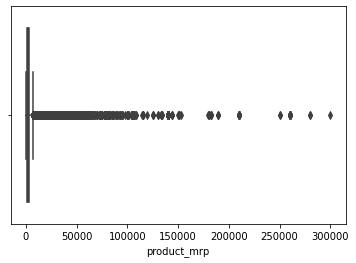

In [50]:
sns.boxplot(consumer_electronics_df.product_mrp)
plt.show()

In [51]:
len(consumer_electronics_df[consumer_electronics_df.product_mrp>155000])

38

We can drop these outliers as it may bias the model and the number of records are negligible as compared to total records

In [52]:
consumer_electronics_df = consumer_electronics_df[consumer_electronics_df.product_mrp<155000]

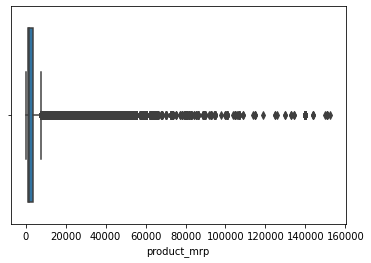

In [53]:
# The outliers are continuous, nothing to do now
sns.boxplot(consumer_electronics_df.product_mrp)
plt.show()

**GMV**

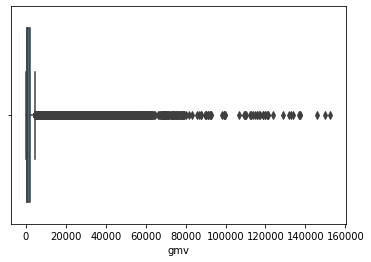

In [54]:
sns.boxplot(consumer_electronics_df.gmv)
plt.show()

**Units**

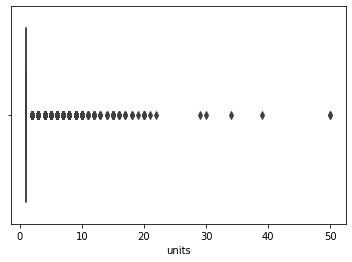

In [55]:
sns.boxplot(consumer_electronics_df.units)
plt.show()

In [56]:
consumer_electronics_df[consumer_electronics_df.units>30]
# Sometimes there might be cases where products are bought in large. Since gmv values for these records is low, no need to drop them. Also units might not be considered when modelling

,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla
9174,2015-10-15 11:17:20,2015,10,1417398718303800,1417398718303800,51950.0,50,Prepaid,9,EntertainmentSmall,Speaker,LaptopSpeaker,2990.0,3
17942,2015-10-18 19:46:37,2015,10,4420323073206100,4420323073206100,18530.0,34,COD,7,CameraAccessory,CameraAccessory,CameraBattery,895.0,5
264155,2015-11-07 23:22:43,2015,11,2437740521881700,2437740521881700,15210.0,39,COD,5,CameraAccessory,CameraAccessory,CameraTripod,2990.0,5
446649,2015-12-23 21:32:31,2015,12,4477416913251300,4477416913251300,87500.0,50,Prepaid,3,EntertainmentSmall,AudioMP3Player,AudioMP3Player,2500.0,2


**SLA**

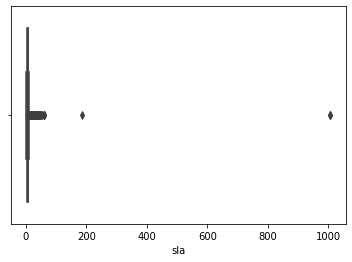

In [57]:
sns.boxplot(consumer_electronics_df.sla)
plt.show()

In [58]:
consumer_electronics_df[consumer_electronics_df.sla>180]

,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla
181991,2016-04-27 00:13:11,2016,4,4410726581427400,4410726581427400,2499.0,1,Prepaid,184,GameCDDVD,Game,PhysicalGame,2499.0,2
1049977,2016-04-27 00:15:43,2016,4,1573983211456200,1573983211456200,3999.0,1,COD,1004,GameCDDVD,Game,PhysicalGame,3999.0,1
1050173,2016-04-27 02:23:19,2016,4,2574018294601400,2574018294601400,3999.0,1,Prepaid,1006,GameCDDVD,Game,PhysicalGame,3999.0,1


We shall drop these records as this sla doesn't make sense for an ecommerce firm.

In [59]:
consumer_electronics_df = consumer_electronics_df[consumer_electronics_df.sla<180]

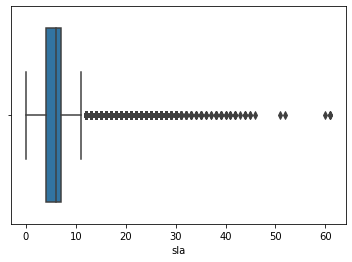

In [60]:
sns.boxplot(consumer_electronics_df.sla)
plt.show()

In [61]:
consumer_electronics_df[consumer_electronics_df.sla>60]

,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla
1128699,2016-05-09 10:59:43,2016,5,1596267940130600,1596267940130600,240.0,1,COD,61,EntertainmentSmall,Speaker,MobileSpeaker,900.0,2
1165021,2016-05-09 09:28:06,2016,5,3596214127902200,3596214127902200,230.0,1,COD,61,EntertainmentSmall,Speaker,MobileSpeaker,499.0,2
1295026,2016-06-24 19:42:15,2016,6,4636327749093600,4636327749093600,429.0,1,COD,61,EntertainmentSmall,Speaker,MobileSpeaker,999.0,1


Even sla>60 is a lot when business is concerned for an ecommerce firm. This might skew our data. Removing them is a good option

In [62]:
consumer_electronics_df = consumer_electronics_df[consumer_electronics_df.sla<=60]

**Product_procurement_sla**

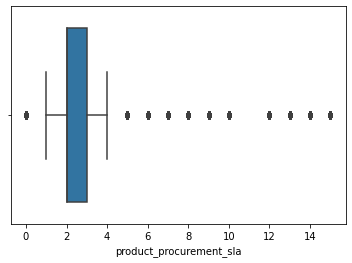

In [63]:
sns.boxplot(consumer_electronics_df.product_procurement_sla)
plt.show()

In [64]:
consumer_electronics_df.shape

(1463985, 14)

# **Filtering Data for 3 product sub categories for which we have to build market mix models**

In [65]:
consumer_electronics_df_subcat=consumer_electronics_df.loc[(consumer_electronics_df['product_analytic_sub_category'] =='CameraAccessory') | (consumer_electronics_df['product_analytic_sub_category']=='GamingAccessory') | (consumer_electronics_df['product_analytic_sub_category']=='HomeAudio')]

In [66]:
consumer_electronics_df_subcat.head()

,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla
0,2015-10-17 15:11:54,2015,10,3419300926147000,3419300926147000,6400.0,1,COD,5,CameraAccessory,CameraAccessory,CameraTripod,7190.0,0
1,2015-10-19 10:07:22,2015,10,1420830839915200,1420830839915200,6900.0,1,COD,7,CameraAccessory,CameraAccessory,CameraTripod,7190.0,0
2,2015-10-20 15:45:56,2015,10,2421912925714800,2421912925714800,1990.0,1,COD,10,CameraAccessory,CameraAccessory,CameraTripod,2099.0,3
3,2015-10-14 12:05:15,2015,10,4416592101738400,4416592101738400,1690.0,1,Prepaid,4,CameraAccessory,CameraAccessory,CameraTripod,2099.0,3
4,2015-10-17 21:25:03,2015,10,4419525153426400,4419525153426400,1618.0,1,Prepaid,6,CameraAccessory,CameraAccessory,CameraTripod,2099.0,3


In [67]:
consumer_electronics_df_subcat.product_analytic_sub_category.value_counts()

CameraAccessory    215980
GamingAccessory    185720
HomeAudio          111135
Name: product_analytic_sub_category, dtype: int64

We can drop the product_analytic_category as we know that each subcategory belong to their own single category, hence adding no new information

In [68]:
consumer_electronics_df_subcat.drop('product_analytic_category',axis=1,inplace=True)

In [69]:
consumer_electronics_df_subcat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 512835 entries, 0 to 1542378
Data columns (total 13 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_date                     512835 non-null  datetime64[ns]
 1   Year                           512835 non-null  int64         
 2   Month                          512835 non-null  int64         
 3   order_id                       512835 non-null  object        
 4   order_item_id                  512835 non-null  object        
 5   gmv                            512835 non-null  float64       
 6   units                          512835 non-null  int64         
 7   s1_fact.order_payment_type     512835 non-null  object        
 8   sla                            512835 non-null  int64         
 9   product_analytic_sub_category  512835 non-null  object        
 10  product_analytic_vertical      512835 non-null  object        
 11 

In [70]:
consumer_electronics_df_subcat.loc[(consumer_electronics_df_subcat['order_date'].dt.floor("d") < '2015-07-01') | (consumer_electronics_df_subcat['order_date'].dt.floor("d") >= '2016-07-01')]

,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla
1071934,2016-07-01 01:07:36,2016,7,1611380362751500,1611380362751500,9999.0,1,COD,6,CameraAccessory,Lens,19500.0,2
1080123,2016-07-02 07:04:29,2016,7,3612045698494600,3612045698494600,949.0,1,COD,1,CameraAccessory,CameraTripod,1499.0,2
1082641,2016-07-02 06:49:00,2016,7,4609992565256700,4609992565256700,1050.0,1,Prepaid,1,GamingAccessory,GamingHeadset,1792.0,1
1084813,2016-07-02 07:03:53,2016,7,3612078345378800,3612078345378800,539.0,1,COD,2,GamingAccessory,GamePad,899.0,5
1085073,2016-07-02 05:59:50,2016,7,3611050099412000,3611050099412000,799.0,1,COD,1,GamingAccessory,GamingMouse,1370.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1343782,2016-07-05 12:05:06,2016,7,1640574293935700,1640574293935700,2100.0,1,COD,7,CameraAccessory,Telescope,3000.0,1
1348417,2016-07-01 18:58:15,2016,7,3633598266571100,3633598266571100,4274.0,1,COD,4,HomeAudio,VoiceRecorder,6359.0,2
1376093,2015-05-19 13:42:09,2015,5,146499482,188485029,3149.0,1,COD,6,HomeAudio,HomeAudioSpeaker,6990.0,4
1402659,2015-06-26 17:33:10,2015,6,163411313,207714163,2800.0,1,COD,11,HomeAudio,HomeAudioSpeaker,3000.0,3


Removing the records where order_date is out of the required analysis

In [71]:
consumer_electronics_df_subcat = consumer_electronics_df_subcat.loc[(consumer_electronics_df_subcat['order_date'].dt.floor("d") >= '2015-07-01') & (consumer_electronics_df_subcat['order_date'].dt.floor("d") < '2016-07-01')]

In [72]:
consumer_electronics_df_subcat.loc[(consumer_electronics_df_subcat['order_date'].dt.floor("d") < '2015-07-01') | (consumer_electronics_df_subcat['order_date'].dt.floor("d") >= '2016-07-01')]

,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla


# **Feature Engineering and Creating KPIs**

**Week: Extracting week from order_date**

In [73]:
consumer_electronics_df_subcat['Week'] = consumer_electronics_df_subcat.order_date.dt.week

In [74]:
consumer_electronics_df_subcat.head()

,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,Week
0,2015-10-17 15:11:54,2015,10,3419300926147000,3419300926147000,6400.0,1,COD,5,CameraAccessory,CameraTripod,7190.0,0,42
1,2015-10-19 10:07:22,2015,10,1420830839915200,1420830839915200,6900.0,1,COD,7,CameraAccessory,CameraTripod,7190.0,0,43
2,2015-10-20 15:45:56,2015,10,2421912925714800,2421912925714800,1990.0,1,COD,10,CameraAccessory,CameraTripod,2099.0,3,43
3,2015-10-14 12:05:15,2015,10,4416592101738400,4416592101738400,1690.0,1,Prepaid,4,CameraAccessory,CameraTripod,2099.0,3,42
4,2015-10-17 21:25:03,2015,10,4419525153426400,4419525153426400,1618.0,1,Prepaid,6,CameraAccessory,CameraTripod,2099.0,3,42


In [75]:
consumer_electronics_df_subcat.Week.value_counts()

42    29640
17    18319
7     15258
10    14594
21    13823
8     13248
3     13236
52    13156
1     13037
5     12882
45    12783
9     12576
19    12186
18    11622
50    11558
20    11448
22    11338
44    11268
23    11187
13    10698
53    10660
14    10623
6     10300
11    10274
2     10047
12    10014
24     9998
46     9964
40     9404
49     9385
4      9331
51     9286
48     8998
15     8802
43     8556
29     8216
37     8183
39     8158
25     7951
28     7834
30     7713
38     7636
36     7551
47     7454
41     7334
31     5362
16     5162
26     4472
27       93
32        9
35        7
33        5
34        2
Name: Week, dtype: int64

**is_paydate: First or Fifteenth of a month**

In [76]:
#consumer_electronics_df_subcat.loc[(consumer_electronics_df_subcat.order_date.dt.day==1) | (consumer_electronics_df_subcat.order_date.dt.day==15)]
def paydate(x):
  if x['order_date'].day == 1 or x['order_date'].day == 15:
    return 1
  else:
    return 0

consumer_electronics_df_subcat['ispaydate'] = consumer_electronics_df_subcat.apply(lambda x: paydate(x),axis=1)

In [77]:
consumer_electronics_df_subcat.head(20)

,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,Week,ispaydate
0,2015-10-17 15:11:54,2015,10,3419300926147000,3419300926147000,6400.0,1,COD,5,CameraAccessory,CameraTripod,7190.0,0,42,0
1,2015-10-19 10:07:22,2015,10,1420830839915200,1420830839915200,6900.0,1,COD,7,CameraAccessory,CameraTripod,7190.0,0,43,0
2,2015-10-20 15:45:56,2015,10,2421912925714800,2421912925714800,1990.0,1,COD,10,CameraAccessory,CameraTripod,2099.0,3,43,0
3,2015-10-14 12:05:15,2015,10,4416592101738400,4416592101738400,1690.0,1,Prepaid,4,CameraAccessory,CameraTripod,2099.0,3,42,0
4,2015-10-17 21:25:03,2015,10,4419525153426400,4419525153426400,1618.0,1,Prepaid,6,CameraAccessory,CameraTripod,2099.0,3,42,0
5,2015-10-17 12:07:24,2015,10,3419188825145600,3419188825145600,3324.0,1,Prepaid,5,CameraAccessory,CameraTripod,4044.0,5,42,0
6,2015-10-16 14:59:57,2015,10,3418428515041500,3418428515041500,3695.0,1,Prepaid,6,CameraAccessory,CameraTripod,4044.0,5,42,0
7,2015-10-15 23:41:39,2015,10,3417799002820700,3417799002820700,3695.0,1,COD,5,CameraAccessory,CameraTripod,4044.0,5,42,1
9,2015-10-25 22:52:34,2015,10,4426481574167600,4426481574167600,3695.0,1,COD,7,CameraAccessory,CameraTripod,4044.0,5,43,0
10,2015-10-19 09:37:06,2015,10,2420828677270800,2420828677270800,3695.0,1,COD,8,CameraAccessory,CameraTripod,4044.0,5,43,0


**isholiday**

In [78]:
import holidays
from datetime import date

CA_holidays_2015 = holidays.Canada(years=2015, state="ON")
CA_holidays_2016 = holidays.Canada(years=2016, state="ON")

for holiday in CA_holidays_2015.items():
    print(holiday)
for holiday in CA_holidays_2016.items():
    print(holiday)

(datetime.date(2015, 1, 1), "New Year's Day")
(datetime.date(2015, 2, 16), 'Family Day')
(datetime.date(2015, 4, 3), 'Good Friday')
(datetime.date(2015, 5, 18), 'Victoria Day')
(datetime.date(2015, 7, 1), 'Canada Day')
(datetime.date(2015, 8, 3), 'Civic Holiday')
(datetime.date(2015, 9, 7), 'Labour Day')
(datetime.date(2015, 10, 12), 'Thanksgiving')
(datetime.date(2015, 12, 25), 'Christmas Day')
(datetime.date(2015, 12, 28), 'Boxing Day (Observed)')
(datetime.date(2016, 1, 1), "New Year's Day")
(datetime.date(2016, 2, 15), 'Family Day')
(datetime.date(2016, 3, 25), 'Good Friday')
(datetime.date(2016, 5, 23), 'Victoria Day')
(datetime.date(2016, 7, 1), 'Canada Day')
(datetime.date(2016, 8, 1), 'Civic Holiday')
(datetime.date(2016, 9, 5), 'Labour Day')
(datetime.date(2016, 10, 10), 'Thanksgiving')
(datetime.date(2016, 12, 25), 'Christmas Day')
(datetime.date(2016, 12, 26), 'Christmas Day (Observed)')
(datetime.date(2016, 12, 27), 'Boxing Day (Observed)')


In [79]:
consumer_electronics_df_subcat['is_holiday']=consumer_electronics_df_subcat.order_date.apply(lambda x: 1 if str(x.date()) in ["2015-07-01","2015-08-03","2015-09-07","2015-10-12","2015-12-25","2015-12-28","2016-01-01","2016-02-15","2016-03-25","2016-05-23"] else 0)

In [80]:
consumer_electronics_df_subcat.head(60)

,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,Week,ispaydate,is_holiday
0,2015-10-17 15:11:54,2015,10,3419300926147000,3419300926147000,6400.0,1,COD,5,CameraAccessory,CameraTripod,7190.0,0,42,0,0
1,2015-10-19 10:07:22,2015,10,1420830839915200,1420830839915200,6900.0,1,COD,7,CameraAccessory,CameraTripod,7190.0,0,43,0,0
2,2015-10-20 15:45:56,2015,10,2421912925714800,2421912925714800,1990.0,1,COD,10,CameraAccessory,CameraTripod,2099.0,3,43,0,0
3,2015-10-14 12:05:15,2015,10,4416592101738400,4416592101738400,1690.0,1,Prepaid,4,CameraAccessory,CameraTripod,2099.0,3,42,0,0
4,2015-10-17 21:25:03,2015,10,4419525153426400,4419525153426400,1618.0,1,Prepaid,6,CameraAccessory,CameraTripod,2099.0,3,42,0,0
5,2015-10-17 12:07:24,2015,10,3419188825145600,3419188825145600,3324.0,1,Prepaid,5,CameraAccessory,CameraTripod,4044.0,5,42,0,0
6,2015-10-16 14:59:57,2015,10,3418428515041500,3418428515041500,3695.0,1,Prepaid,6,CameraAccessory,CameraTripod,4044.0,5,42,0,0
7,2015-10-15 23:41:39,2015,10,3417799002820700,3417799002820700,3695.0,1,COD,5,CameraAccessory,CameraTripod,4044.0,5,42,1,0
9,2015-10-25 22:52:34,2015,10,4426481574167600,4426481574167600,3695.0,1,COD,7,CameraAccessory,CameraTripod,4044.0,5,43,0,0
10,2015-10-19 09:37:06,2015,10,2420828677270800,2420828677270800,3695.0,1,COD,8,CameraAccessory,CameraTripod,4044.0,5,43,0,0


## **KPI 1 :- List_Price = GMV/Units**

In [81]:
consumer_electronics_df_subcat['List_Price'] = consumer_electronics_df_subcat.gmv/consumer_electronics_df_subcat.units

In [82]:
consumer_electronics_df_subcat.head()

,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,Week,ispaydate,is_holiday,List_Price
0,2015-10-17 15:11:54,2015,10,3419300926147000,3419300926147000,6400.0,1,COD,5,CameraAccessory,CameraTripod,7190.0,0,42,0,0,6400.0
1,2015-10-19 10:07:22,2015,10,1420830839915200,1420830839915200,6900.0,1,COD,7,CameraAccessory,CameraTripod,7190.0,0,43,0,0,6900.0
2,2015-10-20 15:45:56,2015,10,2421912925714800,2421912925714800,1990.0,1,COD,10,CameraAccessory,CameraTripod,2099.0,3,43,0,0,1990.0
3,2015-10-14 12:05:15,2015,10,4416592101738400,4416592101738400,1690.0,1,Prepaid,4,CameraAccessory,CameraTripod,2099.0,3,42,0,0,1690.0
4,2015-10-17 21:25:03,2015,10,4419525153426400,4419525153426400,1618.0,1,Prepaid,6,CameraAccessory,CameraTripod,2099.0,3,42,0,0,1618.0


## **KPI 2 :- Discount_Percent = (product_mrp - list_price)*100/product_mrp**

In [83]:
consumer_electronics_df_subcat['Discount_Percent'] = (consumer_electronics_df_subcat.product_mrp - consumer_electronics_df_subcat.List_Price) * 100.0/consumer_electronics_df_subcat.product_mrp

In [84]:
consumer_electronics_df_subcat.head()

,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,Week,ispaydate,is_holiday,List_Price,Discount_Percent
0,2015-10-17 15:11:54,2015,10,3419300926147000,3419300926147000,6400.0,1,COD,5,CameraAccessory,CameraTripod,7190.0,0,42,0,0,6400.0,10.987483
1,2015-10-19 10:07:22,2015,10,1420830839915200,1420830839915200,6900.0,1,COD,7,CameraAccessory,CameraTripod,7190.0,0,43,0,0,6900.0,4.033380
2,2015-10-20 15:45:56,2015,10,2421912925714800,2421912925714800,1990.0,1,COD,10,CameraAccessory,CameraTripod,2099.0,3,43,0,0,1990.0,5.192949
3,2015-10-14 12:05:15,2015,10,4416592101738400,4416592101738400,1690.0,1,Prepaid,4,CameraAccessory,CameraTripod,2099.0,3,42,0,0,1690.0,19.485469
4,2015-10-17 21:25:03,2015,10,4419525153426400,4419525153426400,1618.0,1,Prepaid,6,CameraAccessory,CameraTripod,2099.0,3,42,0,0,1618.0,22.915674


## **KPI 3 :- Product Type :- Luxury/MassMarket**

**If GMV value is greater than 80 percentile, then luxury, else mass_market**

**We will calculate gmv cutoffs for each subcategory separately as their gmv range values differ**

In [85]:
pd.DataFrame(consumer_electronics_df_subcat[consumer_electronics_df_subcat['product_analytic_sub_category']=='CameraAccessory']['gmv']).describe(percentiles=[.70,.80,.90]).T

,count,mean,std,min,50%,70%,80%,90%,max
gmv,215894.0,1171.382742,3040.237247,10.0,388.0,699.0,999.0,1999.0,119000.0


In [86]:
pd.DataFrame(consumer_electronics_df_subcat[consumer_electronics_df_subcat['product_analytic_sub_category']=='GamingAccessory']['gmv']).describe(percentiles=[.70,.80,.90]).T

,count,mean,std,min,50%,70%,80%,90%,max
gmv,185649.0,845.137845,1223.06469,39.0,449.0,759.0,1138.0,1998.0,49999.0


In [87]:
pd.DataFrame(consumer_electronics_df_subcat[consumer_electronics_df_subcat['product_analytic_sub_category']=='HomeAudio']['gmv']).describe(percentiles=[.70,.80,.90]).T

,count,mean,std,min,50%,70%,80%,90%,max
gmv,111098.0,2147.082725,1986.186243,129.0,1900.0,2499.0,2860.0,3449.0,75000.0


In [88]:
def gmv_cutoff(x):
  if x['product_analytic_sub_category'] == 'CameraAccessory':
    if x['gmv'] > 999:
      return 'Luxury'
    else:
      return 'Massmarket'
  if x['product_analytic_sub_category'] == 'GamingAccessory':
    if x['gmv'] > 1138:
      return 'Luxury'
    else:
      return 'Massmarket'
  if x['product_analytic_sub_category'] == 'HomeAudio':
    if x['gmv'] > 2860:
      return 'Luxury'
    else:
      return 'Massmarket'
    
consumer_electronics_df_subcat['product_type'] = consumer_electronics_df_subcat.apply(lambda x: gmv_cutoff(x),axis=1)

In [89]:
consumer_electronics_df_subcat.head()

,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,Week,ispaydate,is_holiday,List_Price,Discount_Percent,product_type
0,2015-10-17 15:11:54,2015,10,3419300926147000,3419300926147000,6400.0,1,COD,5,CameraAccessory,CameraTripod,7190.0,0,42,0,0,6400.0,10.987483,Luxury
1,2015-10-19 10:07:22,2015,10,1420830839915200,1420830839915200,6900.0,1,COD,7,CameraAccessory,CameraTripod,7190.0,0,43,0,0,6900.0,4.033380,Luxury
2,2015-10-20 15:45:56,2015,10,2421912925714800,2421912925714800,1990.0,1,COD,10,CameraAccessory,CameraTripod,2099.0,3,43,0,0,1990.0,5.192949,Luxury
3,2015-10-14 12:05:15,2015,10,4416592101738400,4416592101738400,1690.0,1,Prepaid,4,CameraAccessory,CameraTripod,2099.0,3,42,0,0,1690.0,19.485469,Luxury
4,2015-10-17 21:25:03,2015,10,4419525153426400,4419525153426400,1618.0,1,Prepaid,6,CameraAccessory,CameraTripod,2099.0,3,42,0,0,1618.0,22.915674,Luxury


In [90]:
consumer_electronics_df_subcat[(consumer_electronics_df_subcat['Year']==2016) & (consumer_electronics_df_subcat['Month']==1) & (consumer_electronics_df_subcat['order_date'].dt.day==2)]

,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,Week,ispaydate,is_holiday,List_Price,Discount_Percent,product_type
208759,2016-01-02 11:50:36,2016,1,3454686695553000,3454686695553000,999.0,1,COD,6,GamingAccessory,GamePad,3500.0,1,53,0,0,999.0,71.457143,Massmarket
361474,2016-01-02 09:13:41,2016,1,3463527140463700,3463527140463700,2299.0,1,COD,2,HomeAudio,HomeAudioSpeaker,6990.0,4,53,0,0,2299.0,67.110157,Massmarket
408341,2016-01-02 18:01:15,2016,1,3482256030348500,3482256030348500,385.0,1,COD,6,GamingAccessory,GamingMouse,399.0,2,53,0,0,385.0,3.508772,Massmarket
433291,2016-01-02 21:54:36,2016,1,4480597011920300,4480597011920300,148.0,1,COD,5,GamingAccessory,GamingHeadset,2000.0,2,53,0,0,148.0,92.600000,Massmarket
495964,2016-01-02 12:46:10,2016,1,1485740494937400,1485740494937400,6990.0,1,Prepaid,4,CameraAccessory,Lens,7150.0,0,53,0,0,6990.0,2.237762,Luxury
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637857,2016-01-02 23:49:31,2016,1,1486140078860400,1486140078860400,4599.0,1,COD,8,HomeAudio,VoiceRecorder,7499.0,2,53,0,0,4599.0,38.671823,Luxury
637875,2016-01-02 10:27:28,2016,1,2485654736528600,2485654736528600,4599.0,1,COD,8,HomeAudio,VoiceRecorder,6500.0,3,53,0,0,4599.0,29.246154,Luxury
637896,2016-01-02 20:46:07,2016,1,2486028257913600,2486028257913600,1099.0,1,COD,12,HomeAudio,VoiceRecorder,2100.0,2,53,0,0,1099.0,47.666667,Massmarket
637900,2016-01-02 12:26:35,2016,1,3485729351304700,3485729351304700,4099.0,1,COD,10,HomeAudio,VoiceRecorder,5499.0,2,53,0,0,4099.0,25.459174,Luxury


In [91]:
pd.to_datetime('2016-05-31').week

22

# **EDA on filtered data day wise**

## **Univariate Analysis**

### **Univariate analysis - Numerical columns**

In [92]:
consumer_electronics_df_subcat.head()

,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,Week,ispaydate,is_holiday,List_Price,Discount_Percent,product_type
0,2015-10-17 15:11:54,2015,10,3419300926147000,3419300926147000,6400.0,1,COD,5,CameraAccessory,CameraTripod,7190.0,0,42,0,0,6400.0,10.987483,Luxury
1,2015-10-19 10:07:22,2015,10,1420830839915200,1420830839915200,6900.0,1,COD,7,CameraAccessory,CameraTripod,7190.0,0,43,0,0,6900.0,4.033380,Luxury
2,2015-10-20 15:45:56,2015,10,2421912925714800,2421912925714800,1990.0,1,COD,10,CameraAccessory,CameraTripod,2099.0,3,43,0,0,1990.0,5.192949,Luxury
3,2015-10-14 12:05:15,2015,10,4416592101738400,4416592101738400,1690.0,1,Prepaid,4,CameraAccessory,CameraTripod,2099.0,3,42,0,0,1690.0,19.485469,Luxury
4,2015-10-17 21:25:03,2015,10,4419525153426400,4419525153426400,1618.0,1,Prepaid,6,CameraAccessory,CameraTripod,2099.0,3,42,0,0,1618.0,22.915674,Luxury


In [93]:
consumer_electronics_df_subcat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 512641 entries, 0 to 1542378
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_date                     512641 non-null  datetime64[ns]
 1   Year                           512641 non-null  int64         
 2   Month                          512641 non-null  int64         
 3   order_id                       512641 non-null  object        
 4   order_item_id                  512641 non-null  object        
 5   gmv                            512641 non-null  float64       
 6   units                          512641 non-null  int64         
 7   s1_fact.order_payment_type     512641 non-null  object        
 8   sla                            512641 non-null  int64         
 9   product_analytic_sub_category  512641 non-null  object        
 10  product_analytic_vertical      512641 non-null  object        
 11 

In [94]:
consumer_electronics_df_subcat.gmv.value_counts()

299.0      10133
339.0       8800
199.0       7647
399.0       6211
2499.0      5811
           ...  
1402.0         1
1886.0         1
2803.0         1
11205.0        1
8191.0         1
Name: gmv, Length: 6327, dtype: int64

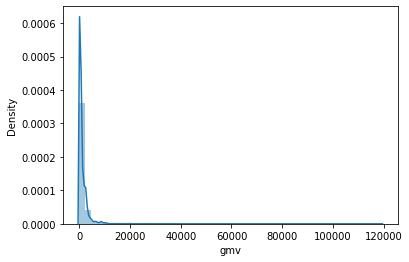

In [95]:
sns.distplot(consumer_electronics_df_subcat["gmv"])
plt.show();

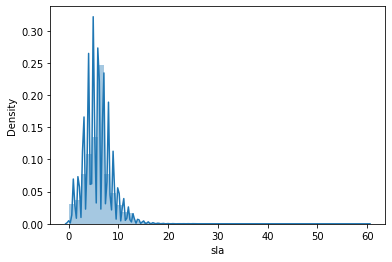

In [96]:
sns.distplot(consumer_electronics_df_subcat["sla"])
plt.show();

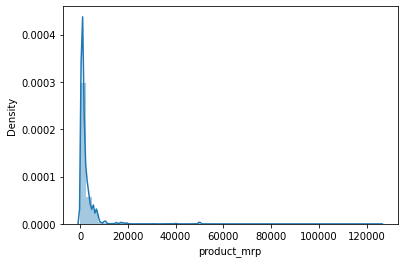

In [97]:
sns.distplot(consumer_electronics_df_subcat["product_mrp"])
plt.show();

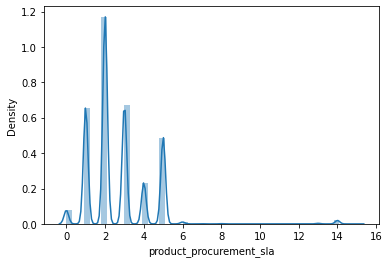

In [98]:
sns.distplot(consumer_electronics_df_subcat["product_procurement_sla"])
plt.show();

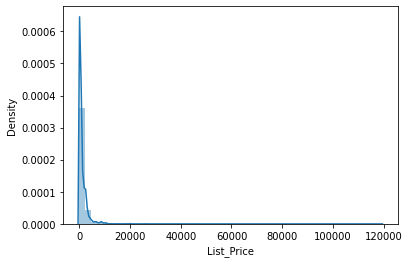

In [99]:
sns.distplot(consumer_electronics_df_subcat["List_Price"])
plt.show();

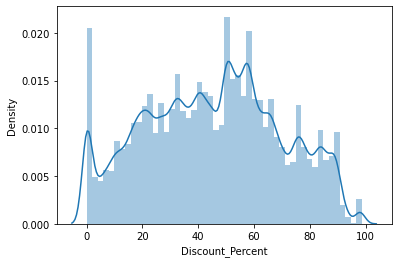

In [100]:
sns.distplot(consumer_electronics_df_subcat["Discount_Percent"])
plt.show();

### **Univariate analysis - Categorical columns**

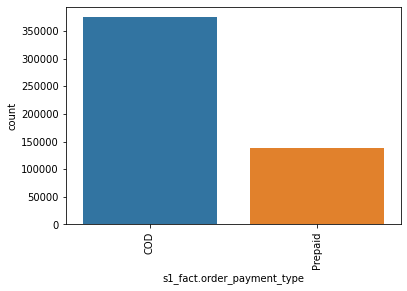

In [101]:
sns.countplot(x="s1_fact.order_payment_type", data=consumer_electronics_df_subcat)
plt.xticks(rotation=90)
plt.show();


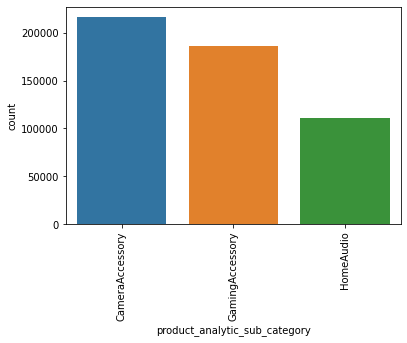

In [102]:
sns.countplot(x="product_analytic_sub_category", data=consumer_electronics_df_subcat)
plt.xticks(rotation=90)
plt.show();

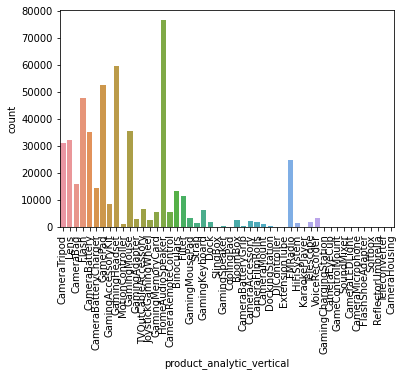

In [103]:
sns.countplot(x="product_analytic_vertical", data=consumer_electronics_df_subcat)
plt.xticks(rotation=90)
plt.show();

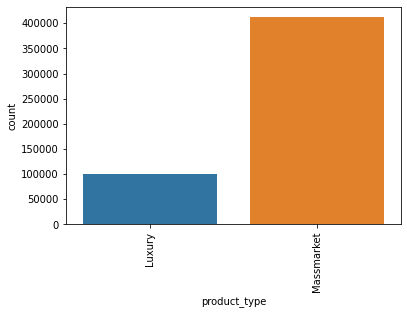

In [104]:
sns.countplot(x="product_type", data=consumer_electronics_df_subcat)
plt.xticks(rotation=90)
plt.show();

## **Bivariate analysis**

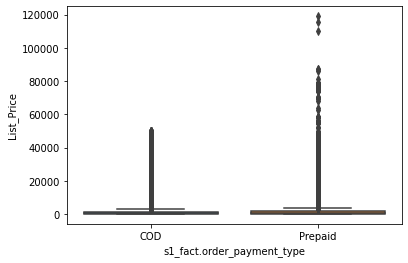

In [105]:
 sns.boxplot(y="List_Price", x="s1_fact.order_payment_type", data=consumer_electronics_df_subcat)
plt.show()

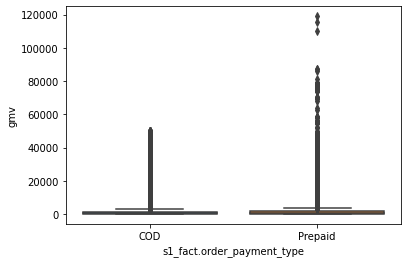

In [106]:
 sns.boxplot(x="s1_fact.order_payment_type", y="gmv", data=consumer_electronics_df_subcat)
plt.show()

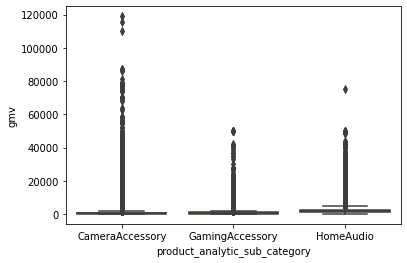

In [107]:
 sns.boxplot(x="product_analytic_sub_category", y="gmv", data=consumer_electronics_df_subcat)
plt.show()

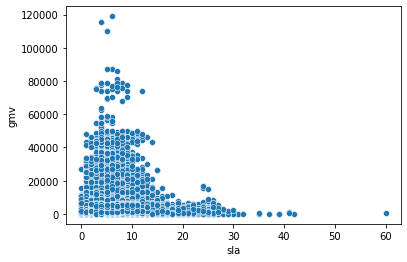

In [109]:
sns.scatterplot(x='sla',y='gmv',data=consumer_electronics_df_subcat)
plt.show()

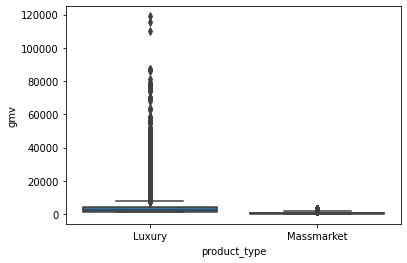

In [110]:
sns.boxplot(x="product_type", y="gmv", data=consumer_electronics_df_subcat)
plt.show()

## **Multivariate Analysis**

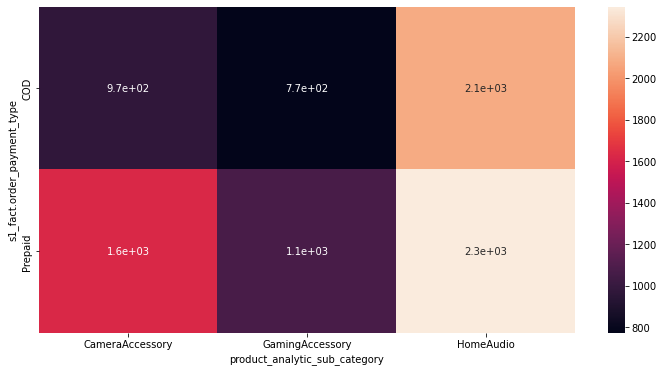

In [111]:
plt.figure(figsize=[12,6])
Product_payment_type = pd.pivot_table(data=consumer_electronics_df_subcat,values="gmv",index="s1_fact.order_payment_type",columns="product_analytic_sub_category")
sns.heatmap(Product_payment_type,annot=True)
plt.show()


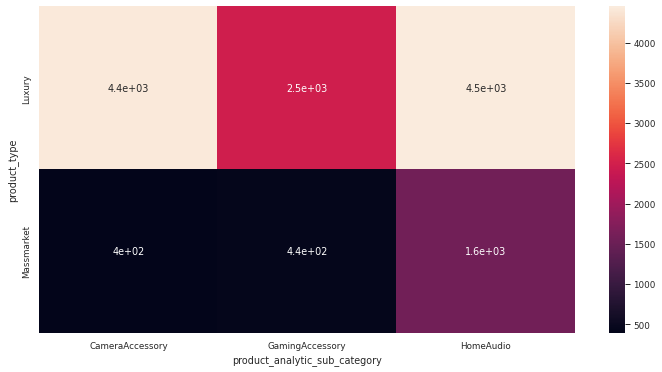

In [462]:
plt.figure(figsize=[12,6])
Product_type = pd.pivot_table(data=consumer_electronics_df_subcat,values="gmv",index="product_type",columns="product_analytic_sub_category")
sns.heatmap(Product_type,annot=True)
plt.show()

## **Further Analysis**

In [466]:
#Top 5 earning verticals
consumer_electronics_df_subcat[consumer_electronics_df_subcat['product_analytic_sub_category']=='CameraAccessory'].groupby(by=['product_analytic_vertical'])[['gmv']].sum().sort_values(by='gmv',ascending=False).head(5)

,gmv
product_analytic_vertical,
Lens,108247118.000
Binoculars,26584680.000
CameraBattery,23561155.257
CameraBag,22499452.000
Flash,22281512.000


In [467]:
#Top 5 earning verticals
consumer_electronics_df_subcat[consumer_electronics_df_subcat['product_analytic_sub_category']=='GamingAccessory'].groupby(by=['product_analytic_vertical'])[['gmv']].sum().sort_values(by='gmv',ascending=False).head()

,gmv
product_analytic_vertical,
GamePad,61885306.209
GamingHeadset,32001153.933
GamingMouse,26333146.952
GamingKeyboard,9357397.814
JoystickGamingWheel,5565376.000


In [468]:
#Top 5 earning verticals
consumer_electronics_df_subcat[consumer_electronics_df_subcat['product_analytic_sub_category']=='HomeAudio'].groupby(by=['product_analytic_vertical'])[['gmv']].sum().sort_values(by='gmv',ascending=False).head()

,gmv
product_analytic_vertical,
HomeAudioSpeaker,187396759.549
FMRadio,22224236.000
VoiceRecorder,10830770.000
BoomBox,8005985.000
HiFiSystem,5518797.000


In [469]:
product_sub = consumer_electronics_df_subcat.loc[(consumer_electronics_df_subcat['product_analytic_sub_category']=='CameraAccessory') | (consumer_electronics_df_subcat['product_analytic_sub_category']=='GamingAccessory') | (consumer_electronics_df_subcat['product_analytic_sub_category']=='HomeAudio')]

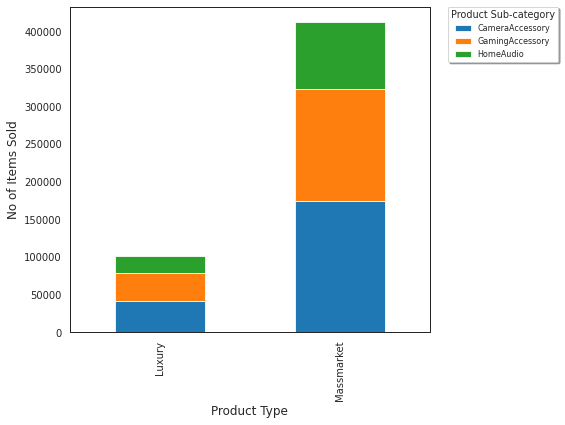

In [470]:
product_sub.groupby(["product_type", "product_analytic_sub_category"]).size().unstack().plot(kind='bar', \
                                                                                             stacked=True, figsize=(8,6), \
                                                                                             fontsize = 10) 
# plot x axis label
plt.xlabel('Product Type', fontsize = 12)
# plot y axis label
plt.ylabel('No of Items Sold', fontsize = 12)
# plot legend
plt.legend(frameon=True, fontsize='small', shadow='True', title='Product Sub-category', \
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

**Analyzing how Sales Amount and Revenue vary based on Discount%**

In [472]:
def discount_binning(df,cut_points,label_names):
    column_index = df.columns.get_loc('Discount_Percent') + 1
    df.insert(loc=column_index,column='Discount Bins',value=pd.cut(df['Discount_Percent'],cut_points,labels=label_names, include_lowest=True))
    return df

cut_points = [0,10,20,30,40,50,60,70,80,90,100]
label_names = ["Below 10%","Between 10-20%","Between 20-30%","Between 30-40%","Between 40-50%","Between 50-60%", \
              "Between 60-70%","Between 70-80%","Between 80-90%","Between 90-100%"]

product_sub = discount_binning(product_sub,cut_points,label_names)
product_sub.head()

,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,Week,ispaydate,is_holiday,List_Price,Discount_Percent,Discount Bins,product_type
0,2015-10-17 15:11:54,2015,10,3419300926147000,3419300926147000,6400.000,1,COD,5,CameraAccessory,CameraTripod,7190.000,0,42,0,0,6400.000,10.987,Between 10-20%,Luxury
1,2015-10-19 10:07:22,2015,10,1420830839915200,1420830839915200,6900.000,1,COD,7,CameraAccessory,CameraTripod,7190.000,0,43,0,0,6900.000,4.033,Below 10%,Luxury
2,2015-10-20 15:45:56,2015,10,2421912925714800,2421912925714800,1990.000,1,COD,10,CameraAccessory,CameraTripod,2099.000,3,43,0,0,1990.000,5.193,Below 10%,Luxury
3,2015-10-14 12:05:15,2015,10,4416592101738400,4416592101738400,1690.000,1,Prepaid,4,CameraAccessory,CameraTripod,2099.000,3,42,0,0,1690.000,19.485,Between 10-20%,Luxury
4,2015-10-17 21:25:03,2015,10,4419525153426400,4419525153426400,1618.000,1,Prepaid,6,CameraAccessory,CameraTripod,2099.000,3,42,0,0,1618.000,22.916,Between 20-30%,Luxury


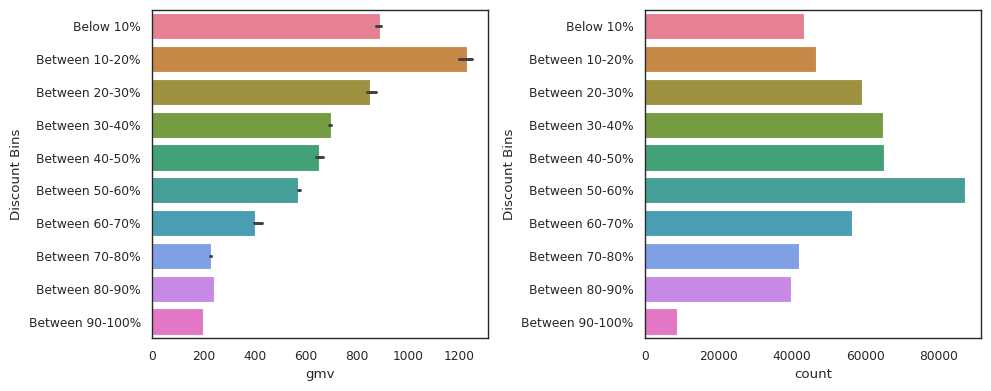

In [473]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(10,4), dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.set_style("white") # white/whitegrid/dark/ticks
sns.set_context("paper") # talk/poster

# subplot 1
plt.subplot(1, 2, 1)
sns.barplot(x='gmv', y='Discount Bins', palette='husl', data=product_sub, estimator=np.median)

# subplot 2
plt.subplot(1, 2, 2)
sns.countplot(y='Discount Bins', palette='husl', data=product_sub)

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

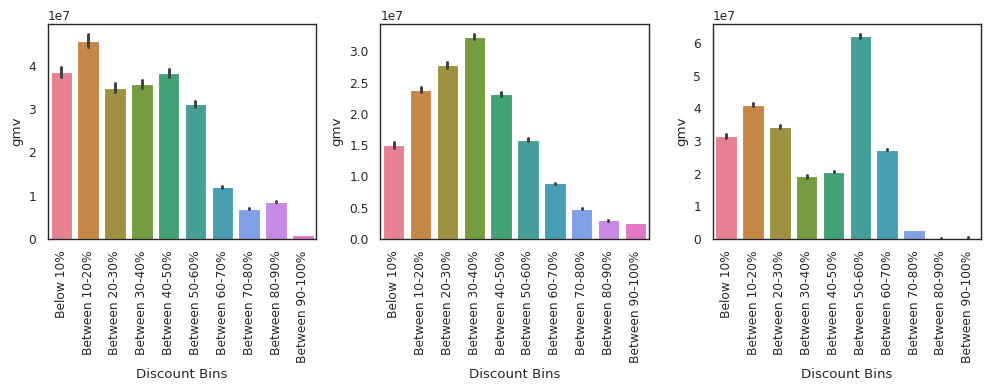

In [476]:
plt.figure(figsize=(10,4), dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.set_style("white") # white/whitegrid/dark/ticks
sns.set_context("paper") # talk/poster

# subplot 1
plt.subplot(1, 3, 1)
sns.barplot(x='Discount Bins', y='gmv', palette='husl', data=product_sub[product_sub['product_analytic_sub_category']=='CameraAccessory'], estimator=np.sum)
plt.xticks(rotation=90)
# subplot 2
plt.subplot(1, 3, 2)
sns.barplot(x='Discount Bins', y='gmv', palette='husl', data=product_sub[product_sub['product_analytic_sub_category']=='GamingAccessory'], estimator=np.sum)
plt.xticks(rotation=90)

# subplot 3
plt.subplot(1, 3, 3)
sns.barplot(x='Discount Bins', y='gmv', palette='husl', data=product_sub[product_sub['product_analytic_sub_category']=='HomeAudio'], estimator=np.sum)
plt.xticks(rotation=90)
# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

# **Preparing other datasets for week level to be then merged with consumer data**

## **Creating Weekly temporary dataframe**

In [112]:
import calendar
import datetime
from calendar import monthrange

In [113]:
def find_start_date(x):
  if x['Year']==2015:
    if pd.DatetimeIndex([datetime.datetime.strptime(f'{x["Year"]}-W{int(x["Week"])- 1}-1', "%Y-W%W-%w").date()])[0].month != int(x['Month']):
      return pd.to_datetime(str(x['Year'])+'-'+str(x['Month']) +'-01')
    else:
      return pd.DatetimeIndex([datetime.datetime.strptime(f'{x["Year"]}-W{int(x["Week"])-1}-1', "%Y-W%W-%w").date()])[0]
  if x['Year']==2016 :
    if x['Week'] == 53:
      return pd.to_datetime(str(x['Year'])+'-'+str(x['Month']) +'-01')
    if pd.DatetimeIndex([datetime.datetime.strptime(f'{x["Year"]}-W{int(x["Week"])}-1', "%Y-W%W-%w").date()])[0].month != int(x['Month']):
      return pd.to_datetime(str(x['Year'])+'-'+str(x['Month']) +'-01')
    else:
      return pd.DatetimeIndex([datetime.datetime.strptime(f'{x["Year"]}-W{int(x["Week"])}-1', "%Y-W%W-%w").date()])[0]

In [114]:
def create_weeks_df():
  weeks_df = pd.DataFrame(consumer_electronics_df_subcat.groupby(['Year', 'Month','Week']).size()).reset_index().iloc[:,:-1]
  weeks_df.iloc[36] = weeks_df.iloc[35]
  weeks_df.iloc[35] = weeks_df.iloc[34]
  weeks_df.iloc[34] = weeks_df.iloc[33]
  weeks_df.iloc[33] = weeks_df.iloc[32]
  weeks_df.iloc[32] = (2016,1,53)
  weeks_df['Month'] = weeks_df['Month'].apply(lambda x: '{:02d}'.format(x))
  weeks_df['Start_date'] = weeks_df.apply(lambda x:find_start_date(x),axis=1)
  weeks_df['num_of_days_per_week'] = abs(weeks_df.Start_date.diff(periods=-1))
  weeks_df.iloc[62] = (weeks_df.iloc[62]['Year'], weeks_df.iloc[62]['Month'], weeks_df.iloc[62]['Week'], weeks_df.iloc[62]['Start_date'], pd.DatetimeIndex([consumer_electronics_df_subcat['order_date'].dt.date.max()])[0] - weeks_df.iloc[62]['Start_date'] + datetime.timedelta(days=1))
  weeks_df['num_of_days_per_week'] = weeks_df['num_of_days_per_week'].dt.days
  weeks_df['num_of_days_per_month'] = weeks_df.apply(lambda x:monthrange(int(x['Year']), int(x['Month']))[1],axis=1)
  weeks_df['days_share'] = weeks_df['num_of_days_per_week']/weeks_df['num_of_days_per_month']

  return weeks_df

In [115]:
weeks_df = create_weeks_df()

In [116]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(weeks_df)

    Year Month  Week Start_date  num_of_days_per_week  num_of_days_per_month  \
0   2015    07    27 2015-07-01                     5                     31   
1   2015    07    28 2015-07-06                     7                     31   
2   2015    07    29 2015-07-13                     7                     31   
3   2015    07    30 2015-07-20                     7                     31   
4   2015    07    31 2015-07-27                     5                     31   
5   2015    08    31 2015-08-01                     2                     31   
6   2015    08    32 2015-08-03                     7                     31   
7   2015    08    33 2015-08-10                     7                     31   
8   2015    08    34 2015-08-17                     7                     31   
9   2015    08    35 2015-08-24                     7                     31   
10  2015    08    36 2015-08-31                     1                     31   
11  2015    09    36 2015-09-01         

In [117]:
weeks_df.head()

,Year,Month,Week,Start_date,num_of_days_per_week,num_of_days_per_month,days_share
0,2015,07,27,2015-07-01,5,31,0.161290
1,2015,07,28,2015-07-06,7,31,0.225806
2,2015,07,29,2015-07-13,7,31,0.225806
3,2015,07,30,2015-07-20,7,31,0.225806
4,2015,07,31,2015-07-27,5,31,0.161290


## **Media Investment**

**Reading the excel file**

In [118]:
media_investment = pd.read_excel('/content/gdrive/My Drive/Ecommerce capstone/Media data and other information.xlsx', sheet_name='Media Investment', skiprows=2)
media_investment.head()

,Unnamed: 0,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
0,NaN,2015.0,7.0,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,NaN,NaN
1,NaN,2015.0,8.0,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,NaN,NaN
2,NaN,2015.0,9.0,96.254380,3.879504,1.356528,62.787651,0.610292,16.379990,5.038266,6.202149,NaN,NaN
3,NaN,2015.0,10.0,170.156297,6.144711,12.622480,84.672532,3.444075,24.371778,6.973711,31.927011,NaN,NaN
4,NaN,2015.0,11.0,51.216220,4.220630,1.275469,14.172116,0.168633,19.561574,6.595767,5.222032,NaN,NaN


In [119]:
media_investment.drop(media_investment.columns[0], axis=1, inplace = True)

In [120]:
media_investment.columns

Index(['Year', 'Month', 'Total Investment', 'TV', 'Digital', 'Sponsorship',
       'Content Marketing', 'Online marketing', ' Affiliates', 'SEM', 'Radio',
       'Other'],
      dtype='object')

In [121]:
media_investment.columns = media_investment.columns.str.strip()

In [122]:
media_investment.head()

,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
0,2015.0,7.0,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,NaN,NaN
1,2015.0,8.0,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,NaN,NaN
2,2015.0,9.0,96.254380,3.879504,1.356528,62.787651,0.610292,16.379990,5.038266,6.202149,NaN,NaN
3,2015.0,10.0,170.156297,6.144711,12.622480,84.672532,3.444075,24.371778,6.973711,31.927011,NaN,NaN
4,2015.0,11.0,51.216220,4.220630,1.275469,14.172116,0.168633,19.561574,6.595767,5.222032,NaN,NaN


**Handling Nulls**

In [123]:
media_investment.isnull().sum()

Year                  4
Month                 4
Total Investment      4
TV                    3
Digital               4
Sponsorship           4
Content Marketing     4
Online marketing      4
Affiliates            4
SEM                   4
Radio                13
Other                13
dtype: int64

In [124]:
media_investment['Radio'].fillna(value=0, inplace=True)
media_investment['Other'].fillna(value=0, inplace=True)

media_investment.head()

,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
0,2015.0,7.0,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,0.0,0.0
1,2015.0,8.0,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,0.0,0.0
2,2015.0,9.0,96.254380,3.879504,1.356528,62.787651,0.610292,16.379990,5.038266,6.202149,0.0,0.0
3,2015.0,10.0,170.156297,6.144711,12.622480,84.672532,3.444075,24.371778,6.973711,31.927011,0.0,0.0
4,2015.0,11.0,51.216220,4.220630,1.275469,14.172116,0.168633,19.561574,6.595767,5.222032,0.0,0.0


In [125]:
media_investment[media_investment['Year'].isnull()]

,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
15,NaN,NaN,NaN,18.549,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


Dropping unnecessary rows

In [126]:
media_investment.dropna(thresh=4,inplace=True)

In [127]:
media_investment.head()

,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
0,2015.0,7.0,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,0.0,0.0
1,2015.0,8.0,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,0.0,0.0
2,2015.0,9.0,96.254380,3.879504,1.356528,62.787651,0.610292,16.379990,5.038266,6.202149,0.0,0.0
3,2015.0,10.0,170.156297,6.144711,12.622480,84.672532,3.444075,24.371778,6.973711,31.927011,0.0,0.0
4,2015.0,11.0,51.216220,4.220630,1.275469,14.172116,0.168633,19.561574,6.595767,5.222032,0.0,0.0


**Weekly Media Investment**

In [128]:
temp_media_investment = pd.DataFrame(index=range(len(weeks_df)), columns=['Year', 'Month', 'Week', 'Total Investment', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', 'Online marketing', 'Affiliates', 'SEM', 'Radio', 'Other'])

In [129]:
temp_media_investment[['Year', 'Month', 'Week']] = weeks_df[['Year', 'Month', 'Week']]

In [130]:
temp_media_investment.head()

,Year,Month,Week,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
0,2015,07,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,07,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,07,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,07,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,07,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
for index, row in temp_media_investment.iterrows():
    temp_media_investment['Total Investment'].iloc[index] = media_investment.loc[(media_investment['Year'] == row['Year']) & (media_investment['Month'] == int(row['Month'])),'Total Investment'].values[0] * weeks_df.loc[(weeks_df['Year'] == row['Year']) & (weeks_df['Month'].astype(int) == int(row['Month'])) & (weeks_df['Week'] == row['Week']),'days_share'].values[0]
    temp_media_investment['TV'].iloc[index] = media_investment.loc[(media_investment['Year'] == row['Year']) & (media_investment['Month'] == int(row['Month'])),'TV'].values[0] * weeks_df.loc[(weeks_df['Year'] == row['Year']) & (weeks_df['Month'].astype(int) == int(row['Month'])) & (weeks_df['Week'] == row['Week']),'days_share'].values[0]
    temp_media_investment['Digital'].iloc[index] = media_investment.loc[(media_investment['Year'] == row['Year']) & (media_investment['Month'] == int(row['Month'])),'Digital'].values[0] * weeks_df.loc[(weeks_df['Year'] == row['Year']) & (weeks_df['Month'].astype(int) == int(row['Month'])) & (weeks_df['Week'] == row['Week']),'days_share'].values[0]
    temp_media_investment['Sponsorship'].iloc[index] = media_investment.loc[(media_investment['Year'] == row['Year']) & (media_investment['Month'] == int(row['Month'])),'Sponsorship'].values[0] * weeks_df.loc[(weeks_df['Year'] == row['Year']) & (weeks_df['Month'].astype(int) == int(row['Month'])) & (weeks_df['Week'] == row['Week']),'days_share'].values[0]
    temp_media_investment['Content Marketing'].iloc[index] = media_investment.loc[(media_investment['Year'] == row['Year']) & (media_investment['Month'] == int(row['Month'])),'Content Marketing'].values[0] * weeks_df.loc[(weeks_df['Year'] == row['Year']) & (weeks_df['Month'].astype(int) == int(row['Month'])) & (weeks_df['Week'] == row['Week']),'days_share'].values[0]
    temp_media_investment['Online marketing'].iloc[index] = media_investment.loc[(media_investment['Year'] == row['Year']) & (media_investment['Month'] == int(row['Month'])),'Online marketing'].values[0] * weeks_df.loc[(weeks_df['Year'] == row['Year']) & (weeks_df['Month'].astype(int) == int(row['Month'])) & (weeks_df['Week'] == row['Week']),'days_share'].values[0]
    temp_media_investment['Affiliates'].iloc[index] = media_investment.loc[(media_investment['Year'] == row['Year']) & (media_investment['Month'] == int(row['Month'])),'Affiliates'].values[0] * weeks_df.loc[(weeks_df['Year'] == row['Year']) & (weeks_df['Month'].astype(int) == int(row['Month'])) & (weeks_df['Week'] == row['Week']),'days_share'].values[0]
    temp_media_investment['SEM'].iloc[index] = media_investment.loc[(media_investment['Year'] == row['Year']) & (media_investment['Month'] == int(row['Month'])),'SEM'].values[0] * weeks_df.loc[(weeks_df['Year'] == row['Year']) & (weeks_df['Month'].astype(int) == int(row['Month'])) & (weeks_df['Week'] == row['Week']),'days_share'].values[0]
    temp_media_investment['Radio'].iloc[index] = media_investment.loc[(media_investment['Year'] == row['Year']) & (media_investment['Month'] == int(row['Month'])),'Radio'].values[0] * weeks_df.loc[(weeks_df['Year'] == row['Year']) & (weeks_df['Month'].astype(int) == int(row['Month'])) & (weeks_df['Week'] == row['Week']),'days_share'].values[0]
    temp_media_investment['Other'].iloc[index] = media_investment.loc[(media_investment['Year'] == row['Year']) & (media_investment['Month'] == int(row['Month'])),'Other'].values[0] * weeks_df.loc[(weeks_df['Year'] == row['Year']) & (weeks_df['Month'].astype(int) == int(row['Month'])) & (weeks_df['Week'] == row['Week']),'days_share'].values[0]

In [132]:
temp_media_investment.head(10)

,Year,Month,Week,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
0,2015,07,27,2.7519,0.0347307,0.408551,1.19585,0.000150467,0.214077,0.0882668,0.810274,0,0
1,2015,07,28,3.85266,0.0486229,0.571971,1.67419,0.000210654,0.299708,0.123573,1.13438,0,0
2,2015,07,29,3.85266,0.0486229,0.571971,1.67419,0.000210654,0.299708,0.123573,1.13438,0,0
3,2015,07,30,3.85266,0.0486229,0.571971,1.67419,0.000210654,0.299708,0.123573,1.13438,0,0
4,2015,07,31,2.7519,0.0347307,0.408551,1.19585,0.000150467,0.214077,0.0882668,0.810274,0,0
5,2015,08,31,0.326729,0.00041536,0.0824564,0.068602,4.08073e-07,0.00833834,0.00475381,0.162163,0,0
6,2015,08,32,1.14355,0.00145376,0.288597,0.240107,1.42826e-06,0.0291842,0.0166383,0.567571,0,0
7,2015,08,33,1.14355,0.00145376,0.288597,0.240107,1.42826e-06,0.0291842,0.0166383,0.567571,0,0
8,2015,08,34,1.14355,0.00145376,0.288597,0.240107,1.42826e-06,0.0291842,0.0166383,0.567571,0,0
9,2015,08,35,1.14355,0.00145376,0.288597,0.240107,1.42826e-06,0.0291842,0.0166383,0.567571,0,0


In [133]:
media_investment_weekly = temp_media_investment.groupby(by=["Week"])[temp_media_investment.columns[3:]].sum().reset_index()

In [134]:
media_investment_weekly.head(64)

,Week,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
0,1,16.753935,0.989032,0.102968,0.948387,0.203226,5.170968,1.664194,0.948387,0.609677,6.117097
1,2,16.753935,0.989032,0.102968,0.948387,0.203226,5.170968,1.664194,0.948387,0.609677,6.117097
2,3,16.753935,0.989032,0.102968,0.948387,0.203226,5.170968,1.664194,0.948387,0.609677,6.117097
3,4,16.753935,0.989032,0.102968,0.948387,0.203226,5.170968,1.664194,0.948387,0.609677,6.117097
4,5,11.598759,0.624209,0.461674,2.830306,0.144048,4.801606,1.560522,1.176393,0.000000,0.000000
5,6,11.598759,0.624209,0.461674,2.830306,0.144048,4.801606,1.560522,1.176393,0.000000,0.000000
6,7,11.598759,0.624209,0.461674,2.830306,0.144048,4.801606,1.560522,1.176393,0.000000,0.000000
7,8,11.598759,0.624209,0.461674,2.830306,0.144048,4.801606,1.560522,1.176393,0.000000,0.000000
8,9,21.016570,1.889173,0.472405,8.454007,0.092191,4.254554,1.426351,1.173267,0.168387,3.086235
9,10,22.586205,2.100000,0.474194,9.391290,0.083548,4.163378,1.403989,1.172746,0.196452,3.600607


In [135]:
#Arranging them in chronological order
media_investment_weekly = pd.concat([media_investment_weekly[26:],media_investment_weekly[:26]],axis=0)
media_investment_weekly.head()

,Week,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
26,27,2.751899,0.034731,0.408551,1.195850,0.000150,0.214077,0.088267,0.810274,0.0,0.0
27,28,3.852659,0.048623,0.571971,1.674190,0.000211,0.299708,0.123573,1.134383,0.0,0.0
28,29,3.852659,0.048623,0.571971,1.674190,0.000211,0.299708,0.123573,1.134383,0.0,0.0
29,30,3.852659,0.048623,0.571971,1.674190,0.000211,0.299708,0.123573,1.134383,0.0,0.0
30,31,3.078629,0.035146,0.491007,1.264452,0.000151,0.222415,0.093021,0.972437,0.0,0.0


In [136]:
media_investment_weekly_kpi = media_investment_weekly.copy()

In [137]:
cols = media_investment.columns[2:]
cols

Index(['Total Investment', 'TV', 'Digital', 'Sponsorship', 'Content Marketing',
       'Online marketing', 'Affiliates', 'SEM', 'Radio', 'Other'],
      dtype='object')

In [138]:
def SMA_variables(df,var,n):
    for i in var:
        loc_index = df.columns.get_loc(i) + 1
        df.insert(loc=loc_index,column= i+'_SMA_'+np.str(n),value=df[i].rolling(window=n).mean())
    return df

In [139]:
def EMA_variables(df,var,n):
    for i in var:
        loc_index = df.columns.get_loc(i) + 1
        df.insert(loc=loc_index,column= i+'_EMA_'+np.str(n),value=df[i].ewm(span=n, adjust=False).mean())
    return df

In [140]:
media_investment_weekly_kpi = EMA_variables(media_investment_weekly_kpi,cols,7)
media_investment_weekly_kpi = SMA_variables(media_investment_weekly_kpi,cols,5)
media_investment_weekly_kpi = SMA_variables(media_investment_weekly_kpi,cols,3) 
media_investment_weekly_kpi.head()


,Week,Total Investment,Total Investment_SMA_3,Total Investment_SMA_5,Total Investment_EMA_7,TV,TV_SMA_3,TV_SMA_5,TV_EMA_7,Digital,Digital_SMA_3,Digital_SMA_5,Digital_EMA_7,Sponsorship,Sponsorship_SMA_3,Sponsorship_SMA_5,Sponsorship_EMA_7,Content Marketing,Content Marketing_SMA_3,Content Marketing_SMA_5,Content Marketing_EMA_7,Online marketing,Online marketing_SMA_3,Online marketing_SMA_5,Online marketing_EMA_7,Affiliates,Affiliates_SMA_3,Affiliates_SMA_5,Affiliates_EMA_7,SEM,SEM_SMA_3,SEM_SMA_5,SEM_EMA_7,Radio,Radio_SMA_3,Radio_SMA_5,Radio_EMA_7,Other,Other_SMA_3,Other_SMA_5,Other_EMA_7
26,27,2.751899,NaN,NaN,2.751899,0.034731,NaN,NaN,0.034731,0.408551,NaN,NaN,0.408551,1.195850,NaN,NaN,1.195850,0.000150,NaN,NaN,0.000150,0.214077,NaN,NaN,0.214077,0.088267,NaN,NaN,0.088267,0.810274,NaN,NaN,0.810274,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0
27,28,3.852659,NaN,NaN,3.027089,0.048623,NaN,NaN,0.038204,0.571971,NaN,NaN,0.449406,1.674190,NaN,NaN,1.315435,0.000211,NaN,NaN,0.000166,0.299708,NaN,NaN,0.235485,0.123573,NaN,NaN,0.097093,1.134383,NaN,NaN,0.891301,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0
28,29,3.852659,3.485739,NaN,3.233482,0.048623,0.043992,NaN,0.040809,0.571971,0.517497,NaN,0.480047,1.674190,1.514743,NaN,1.405124,0.000211,0.000191,NaN,0.000177,0.299708,0.271164,NaN,0.251541,0.123573,0.111805,NaN,0.103713,1.134383,1.026347,NaN,0.952072,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0
29,30,3.852659,3.852659,NaN,3.388276,0.048623,0.048623,NaN,0.042762,0.571971,0.571971,NaN,0.503028,1.674190,1.674190,NaN,1.472390,0.000211,0.000211,NaN,0.000185,0.299708,0.299708,NaN,0.263582,0.123573,0.123573,NaN,0.108678,1.134383,1.134383,NaN,0.997650,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0
30,31,3.078629,3.594649,3.477701,3.310864,0.035146,0.044131,0.043149,0.040858,0.491007,0.544983,0.523094,0.500023,1.264452,1.537611,1.496574,1.420406,0.000151,0.000191,0.000187,0.000177,0.222415,0.273944,0.267123,0.253291,0.093021,0.113389,0.110402,0.104764,0.972437,1.080401,1.037172,0.991346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [141]:
def calculate_ad_stocks(data, engagement_factor):
    
    """initialize ad stock vectors"""
    TV_ad_stock_vector = []                     
    Digital_ad_stock_vector = []
    Sponsorship_ad_stock_vector = []
    Content_Marketing_ad_stock_vector = []
    Online_marketing_ad_stock_vector = []
    Affiliates_ad_stock_vector = []
    SEM_ad_stock_vector = []
    Radio_ad_stock_vector = []
    Other_ad_stock_vector = []
    Total_Investment_ad_stock_vector = []
    
    """initialize ad_stock_value"""
    tv_ad_stock_value = 0 
    Digital_ad_stock_value = 0
    Sponsorship_ad_stock_value = 0
    Content_Marketing_ad_stock_value = 0
    Online_marketing_ad_stock_value = 0
    Affiliates_ad_stock_value = 0
    SEM_ad_stock_value = 0
    Radio_ad_stock_value = 0
    Other_ad_stock_value = 0
    Total_Investment_ad_stock_value = 0
    
    """loop through dataset to calculate adstock values. The formula for adstock is: At = Xt + adstock rate * At-1."""
    for index, row in data.iterrows():
        tv_ad_stock_value = row['TV'] + engagement_factor * tv_ad_stock_value
        TV_ad_stock_vector.append(tv_ad_stock_value)
        Digital_ad_stock_value = row['Digital'] + engagement_factor * Digital_ad_stock_value
        Digital_ad_stock_vector.append(Digital_ad_stock_value)
        Sponsorship_ad_stock_value = row['Sponsorship'] + engagement_factor * Sponsorship_ad_stock_value
        Sponsorship_ad_stock_vector.append(Sponsorship_ad_stock_value)
        Content_Marketing_ad_stock_value = row['Content Marketing'] + engagement_factor * Content_Marketing_ad_stock_value
        Content_Marketing_ad_stock_vector.append(Content_Marketing_ad_stock_value)    
        Online_marketing_ad_stock_value = row['Online marketing'] + engagement_factor * Online_marketing_ad_stock_value
        Online_marketing_ad_stock_vector.append(Online_marketing_ad_stock_value)
        Affiliates_ad_stock_value = row['Affiliates'] + engagement_factor * Affiliates_ad_stock_value
        Affiliates_ad_stock_vector.append(Affiliates_ad_stock_value)
        SEM_ad_stock_value = row['SEM'] + engagement_factor * SEM_ad_stock_value
        SEM_ad_stock_vector.append(SEM_ad_stock_value)
        Radio_ad_stock_value = row['Radio'] + engagement_factor * Radio_ad_stock_value
        Radio_ad_stock_vector.append(Radio_ad_stock_value)
        Other_ad_stock_value = row['Other'] + engagement_factor * Other_ad_stock_value
        Other_ad_stock_vector.append(Other_ad_stock_value)
        Total_Investment_ad_stock_value = row['Total Investment'] + engagement_factor * Total_Investment_ad_stock_value
        Total_Investment_ad_stock_vector.append(Total_Investment_ad_stock_value)
    
    """add ad stock vector to dataset"""
    loc_index = data.columns.get_loc('TV_EMA_7') + 1
    data.insert(loc=loc_index,column='TV_Ad_Stock',value=TV_ad_stock_vector)
    loc_index = data.columns.get_loc('Digital_EMA_7') + 1
    data.insert(loc=loc_index,column='Digital_Ad_Stock',value=Digital_ad_stock_vector)
    loc_index = data.columns.get_loc('Sponsorship_EMA_7') + 1
    data.insert(loc=loc_index,column='Sponsorship_Ad_Stock',value=Sponsorship_ad_stock_vector)
    loc_index = data.columns.get_loc('Content Marketing_EMA_7') + 1
    data.insert(loc=loc_index,column='Content_Marketing_Ad_Stock',value=Content_Marketing_ad_stock_vector)
    loc_index = data.columns.get_loc('Online marketing_EMA_7') + 1
    data.insert(loc=loc_index,column='Online_marketing_Ad_Stock',value=Online_marketing_ad_stock_vector)
    loc_index = data.columns.get_loc('Affiliates_EMA_7') + 1
    data.insert(loc=loc_index,column='Affiliates_Ad_Stock',value=Affiliates_ad_stock_vector)
    loc_index = data.columns.get_loc('SEM_EMA_7') + 1
    data.insert(loc=loc_index,column='SEM_Ad_Stock',value=SEM_ad_stock_vector)
    loc_index = data.columns.get_loc('Radio_EMA_7') + 1
    data.insert(loc=loc_index,column='Radio_Ad_Stock',value=Radio_ad_stock_vector)
    loc_index = data.columns.get_loc('Other_EMA_7') + 1
    data.insert(loc=loc_index,column='Other_Ad_Stock',value=Other_ad_stock_vector)
    loc_index = data.columns.get_loc('Total Investment_EMA_7') + 1
    data.insert(loc=loc_index,column='Total_Investment_Ad_Stock',value=Total_Investment_ad_stock_vector)
    
    return data

In [142]:
media_investment_weekly_kpi = calculate_ad_stocks(media_investment_weekly_kpi, 0.6)
media_investment_weekly_kpi.head()

,Week,Total Investment,Total Investment_SMA_3,Total Investment_SMA_5,Total Investment_EMA_7,Total_Investment_Ad_Stock,TV,TV_SMA_3,TV_SMA_5,TV_EMA_7,TV_Ad_Stock,Digital,Digital_SMA_3,Digital_SMA_5,Digital_EMA_7,Digital_Ad_Stock,Sponsorship,Sponsorship_SMA_3,Sponsorship_SMA_5,Sponsorship_EMA_7,Sponsorship_Ad_Stock,Content Marketing,Content Marketing_SMA_3,Content Marketing_SMA_5,Content Marketing_EMA_7,Content_Marketing_Ad_Stock,Online marketing,Online marketing_SMA_3,Online marketing_SMA_5,Online marketing_EMA_7,Online_marketing_Ad_Stock,Affiliates,Affiliates_SMA_3,Affiliates_SMA_5,Affiliates_EMA_7,Affiliates_Ad_Stock,SEM,SEM_SMA_3,SEM_SMA_5,SEM_EMA_7,SEM_Ad_Stock,Radio,Radio_SMA_3,Radio_SMA_5,Radio_EMA_7,Radio_Ad_Stock,Other,Other_SMA_3,Other_SMA_5,Other_EMA_7,Other_Ad_Stock
26,27,2.751899,NaN,NaN,2.751899,2.751899,0.034731,NaN,NaN,0.034731,0.034731,0.408551,NaN,NaN,0.408551,0.408551,1.195850,NaN,NaN,1.195850,1.195850,0.000150,NaN,NaN,0.000150,0.000150,0.214077,NaN,NaN,0.214077,0.214077,0.088267,NaN,NaN,0.088267,0.088267,0.810274,NaN,NaN,0.810274,0.810274,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0
27,28,3.852659,NaN,NaN,3.027089,5.503799,0.048623,NaN,NaN,0.038204,0.069461,0.571971,NaN,NaN,0.449406,0.817101,1.674190,NaN,NaN,1.315435,2.391700,0.000211,NaN,NaN,0.000166,0.000301,0.299708,NaN,NaN,0.235485,0.428154,0.123573,NaN,NaN,0.097093,0.176534,1.134383,NaN,NaN,0.891301,1.620548,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0
28,29,3.852659,3.485739,NaN,3.233482,7.154938,0.048623,0.043992,NaN,0.040809,0.090300,0.571971,0.517497,NaN,0.480047,1.062232,1.674190,1.514743,NaN,1.405124,3.109210,0.000211,0.000191,NaN,0.000177,0.000391,0.299708,0.271164,NaN,0.251541,0.556600,0.123573,0.111805,NaN,0.103713,0.229494,1.134383,1.026347,NaN,0.952072,2.106712,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0
29,30,3.852659,3.852659,NaN,3.388276,8.145622,0.048623,0.048623,NaN,0.042762,0.102803,0.571971,0.571971,NaN,0.503028,1.209310,1.674190,1.674190,NaN,1.472390,3.539716,0.000211,0.000211,NaN,0.000185,0.000445,0.299708,0.299708,NaN,0.263582,0.633668,0.123573,0.123573,NaN,0.108678,0.261270,1.134383,1.134383,NaN,0.997650,2.398410,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0
30,31,3.078629,3.594649,3.477701,3.310864,7.966002,0.035146,0.044131,0.043149,0.040858,0.096828,0.491007,0.544983,0.523094,0.500023,1.216593,1.264452,1.537611,1.496574,1.420406,3.388282,0.000151,0.000191,0.000187,0.000177,0.000418,0.222415,0.273944,0.267123,0.253291,0.602616,0.093021,0.113389,0.110402,0.104764,0.249782,0.972437,1.080401,1.037172,0.991346,2.411483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [143]:
media_investment_weekly_kpi.fillna(value=0, inplace=True)
media_investment_weekly_kpi.head(10)

,Week,Total Investment,Total Investment_SMA_3,Total Investment_SMA_5,Total Investment_EMA_7,Total_Investment_Ad_Stock,TV,TV_SMA_3,TV_SMA_5,TV_EMA_7,TV_Ad_Stock,Digital,Digital_SMA_3,Digital_SMA_5,Digital_EMA_7,Digital_Ad_Stock,Sponsorship,Sponsorship_SMA_3,Sponsorship_SMA_5,Sponsorship_EMA_7,Sponsorship_Ad_Stock,Content Marketing,Content Marketing_SMA_3,Content Marketing_SMA_5,Content Marketing_EMA_7,Content_Marketing_Ad_Stock,Online marketing,Online marketing_SMA_3,Online marketing_SMA_5,Online marketing_EMA_7,Online_marketing_Ad_Stock,Affiliates,Affiliates_SMA_3,Affiliates_SMA_5,Affiliates_EMA_7,Affiliates_Ad_Stock,SEM,SEM_SMA_3,SEM_SMA_5,SEM_EMA_7,SEM_Ad_Stock,Radio,Radio_SMA_3,Radio_SMA_5,Radio_EMA_7,Radio_Ad_Stock,Other,Other_SMA_3,Other_SMA_5,Other_EMA_7,Other_Ad_Stock
26,27,2.751899,0.000000,0.000000,2.751899,2.751899,0.034731,0.000000,0.000000,0.034731,0.034731,0.408551,0.000000,0.000000,0.408551,0.408551,1.195850,0.000000,0.000000,1.195850,1.195850,0.000150,0.000000,0.000000,0.000150,0.000150,0.214077,0.000000,0.000000,0.214077,0.214077,0.088267,0.000000,0.000000,0.088267,0.088267,0.810274,0.000000,0.000000,0.810274,0.810274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,28,3.852659,0.000000,0.000000,3.027089,5.503799,0.048623,0.000000,0.000000,0.038204,0.069461,0.571971,0.000000,0.000000,0.449406,0.817101,1.674190,0.000000,0.000000,1.315435,2.391700,0.000211,0.000000,0.000000,0.000166,0.000301,0.299708,0.000000,0.000000,0.235485,0.428154,0.123573,0.000000,0.000000,0.097093,0.176534,1.134383,0.000000,0.000000,0.891301,1.620548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,29,3.852659,3.485739,0.000000,3.233482,7.154938,0.048623,0.043992,0.000000,0.040809,0.090300,0.571971,0.517497,0.000000,0.480047,1.062232,1.674190,1.514743,0.000000,1.405124,3.109210,0.000211,0.000191,0.000000,0.000177,0.000391,0.299708,0.271164,0.000000,0.251541,0.556600,0.123573,0.111805,0.000000,0.103713,0.229494,1.134383,1.026347,0.000000,0.952072,2.106712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,30,3.852659,3.852659,0.000000,3.388276,8.145622,0.048623,0.048623,0.000000,0.042762,0.102803,0.571971,0.571971,0.000000,0.503028,1.209310,1.674190,1.674190,0.000000,1.472390,3.539716,0.000211,0.000211,0.000000,0.000185,0.000445,0.299708,0.299708,0.000000,0.263582,0.633668,0.123573,0.123573,0.000000,0.108678,0.261270,1.134383,1.134383,0.000000,0.997650,2.398410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,31,3.078629,3.594649,3.477701,3.310864,7.966002,0.035146,0.044131,0.043149,0.040858,0.096828,0.491007,0.544983,0.523094,0.500023,1.216593,1.264452,1.537611,1.496574,1.420406,3.388282,0.000151,0.000191,0.000187,0.000177,0.000418,0.222415,0.273944,0.267123,0.253291,0.602616,0.093021,0.113389,0.110402,0.104764,0.249782,0.972437,1.080401,1.037172,0.991346,2.411483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,32,1.143553,2.691614,3.156032,2.769036,5.923154,0.001454,0.028408,0.036494,0.031007,0.059550,0.288597,0.450525,0.499103,0.447166,1.018553,0.240107,1.059583,1.305426,1.125331,2.273076,0.000001,0.000121,0.000157,0.000133,0.000252,0.029184,0.183769,0.230145,0.197264,0.390754,0.016638,0.077744,0.096076,0.082733,0.166508,0.567571,0.891464,0.988632,0.885403,2.014461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,33,1.143553,1.788578,2.614211,2.362666,4.697445,0.001454,0.012685,0.027060,0.023619,0.037184,0.288597,0.356067,0.442429,0.407524,0.899729,0.240107,0.581555,1.018609,0.904025,1.603953,0.000001,0.000051,0.000115,0.000100,0.000153,0.029184,0.093595,0.176040,0.155244,0.263637,0.016638,0.042099,0.074689,0.066209,0.116543,0.567571,0.702526,0.875269,0.805945,1.776247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,34,1.143553,1.143553,2.072389,2.057887,3.962020,0.001454,0.001454,0.017626,0.018077,0.023764,0.288597,0.288597,0.385754,0.377792,0.828435,0.240107,0.240107,0.731793,0.738046,1.202479,0.000001,0.000001,0.000073,0.000075,0.000093,0.029184,0.029184,0.121935,0.123729,0.187366,0.016638,0.016638,0.053302,0.053816,0.086564,0.567571,0.567571,0.761907,0.746351,1.633319,0.0,0.

In [144]:
media_investment_weekly_kpi.head()

,Week,Total Investment,Total Investment_SMA_3,Total Investment_SMA_5,Total Investment_EMA_7,Total_Investment_Ad_Stock,TV,TV_SMA_3,TV_SMA_5,TV_EMA_7,TV_Ad_Stock,Digital,Digital_SMA_3,Digital_SMA_5,Digital_EMA_7,Digital_Ad_Stock,Sponsorship,Sponsorship_SMA_3,Sponsorship_SMA_5,Sponsorship_EMA_7,Sponsorship_Ad_Stock,Content Marketing,Content Marketing_SMA_3,Content Marketing_SMA_5,Content Marketing_EMA_7,Content_Marketing_Ad_Stock,Online marketing,Online marketing_SMA_3,Online marketing_SMA_5,Online marketing_EMA_7,Online_marketing_Ad_Stock,Affiliates,Affiliates_SMA_3,Affiliates_SMA_5,Affiliates_EMA_7,Affiliates_Ad_Stock,SEM,SEM_SMA_3,SEM_SMA_5,SEM_EMA_7,SEM_Ad_Stock,Radio,Radio_SMA_3,Radio_SMA_5,Radio_EMA_7,Radio_Ad_Stock,Other,Other_SMA_3,Other_SMA_5,Other_EMA_7,Other_Ad_Stock
26,27,2.751899,0.000000,0.000000,2.751899,2.751899,0.034731,0.000000,0.000000,0.034731,0.034731,0.408551,0.000000,0.000000,0.408551,0.408551,1.195850,0.000000,0.000000,1.195850,1.195850,0.000150,0.000000,0.000000,0.000150,0.000150,0.214077,0.000000,0.000000,0.214077,0.214077,0.088267,0.000000,0.000000,0.088267,0.088267,0.810274,0.000000,0.000000,0.810274,0.810274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,28,3.852659,0.000000,0.000000,3.027089,5.503799,0.048623,0.000000,0.000000,0.038204,0.069461,0.571971,0.000000,0.000000,0.449406,0.817101,1.674190,0.000000,0.000000,1.315435,2.391700,0.000211,0.000000,0.000000,0.000166,0.000301,0.299708,0.000000,0.000000,0.235485,0.428154,0.123573,0.000000,0.000000,0.097093,0.176534,1.134383,0.000000,0.000000,0.891301,1.620548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,29,3.852659,3.485739,0.000000,3.233482,7.154938,0.048623,0.043992,0.000000,0.040809,0.090300,0.571971,0.517497,0.000000,0.480047,1.062232,1.674190,1.514743,0.000000,1.405124,3.109210,0.000211,0.000191,0.000000,0.000177,0.000391,0.299708,0.271164,0.000000,0.251541,0.556600,0.123573,0.111805,0.000000,0.103713,0.229494,1.134383,1.026347,0.000000,0.952072,2.106712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,30,3.852659,3.852659,0.000000,3.388276,8.145622,0.048623,0.048623,0.000000,0.042762,0.102803,0.571971,0.571971,0.000000,0.503028,1.209310,1.674190,1.674190,0.000000,1.472390,3.539716,0.000211,0.000211,0.000000,0.000185,0.000445,0.299708,0.299708,0.000000,0.263582,0.633668,0.123573,0.123573,0.000000,0.108678,0.261270,1.134383,1.134383,0.000000,0.997650,2.398410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,31,3.078629,3.594649,3.477701,3.310864,7.966002,0.035146,0.044131,0.043149,0.040858,0.096828,0.491007,0.544983,0.523094,0.500023,1.216593,1.264452,1.537611,1.496574,1.420406,3.388282,0.000151,0.000191,0.000187,0.000177,0.000418,0.222415,0.273944,0.267123,0.253291,0.602616,0.093021,0.113389,0.110402,0.104764,0.249782,0.972437,1.080401,1.037172,0.991346,2.411483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **Sale calendar**

In [145]:
sale_calendar = pd.read_excel('/content/gdrive/My Drive/Ecommerce capstone/Media data and other information.xlsx', sheet_name='Special Sale Calendar', \
                              skiprows=0)

In [146]:
sale_calendar

,Unnamed: 0,Unnamed: 1,Sales Calendar
0,NaN,2015.0,(18-19th July)
1,NaN,NaN,(15-17th Aug)
2,NaN,NaN,(28-30th Aug)
3,NaN,NaN,(15-17th Oct)
4,NaN,NaN,(7-14th Nov)
5,NaN,NaN,(25th Dec'15 - 3rd Jan'16)
6,NaN,2016.0,(20-22 Jan)
7,NaN,NaN,(1-2 Feb)
8,NaN,NaN,(20-21 Feb)
9,NaN,NaN,(14-15 Feb)


In [147]:
sale_calendar.drop(sale_calendar.columns[0], axis=1, inplace = True)

sale_calendar.iloc[1:6, 0] = sale_calendar.iloc[0, 0]
sale_calendar.iloc[7:, 0] = sale_calendar.iloc[6, 0]

sale_calendar.columns = ['Year','Salesdate']

sale_calendar

,Year,Salesdate
0,2015.0,(18-19th July)
1,2015.0,(15-17th Aug)
2,2015.0,(28-30th Aug)
3,2015.0,(15-17th Oct)
4,2015.0,(7-14th Nov)
5,2015.0,(25th Dec'15 - 3rd Jan'16)
6,2016.0,(20-22 Jan)
7,2016.0,(1-2 Feb)
8,2016.0,(20-21 Feb)
9,2016.0,(14-15 Feb)


In [148]:
sale_calendar.Year = sale_calendar.Year.astype(int)
sale_calendar.Salesdate = sale_calendar.Salesdate.apply(lambda x: x.replace('th','').strip())
sale_calendar.Salesdate = sale_calendar.Salesdate.apply(lambda x: x.replace('rd','').strip())
sale_calendar.Salesdate = sale_calendar.Salesdate.apply(lambda x: x.replace('(','').strip())
sale_calendar.Salesdate = sale_calendar.Salesdate.apply(lambda x: x.replace(')','').strip())

# Splitting 25-31 Dec into two different rows for the ease of weekly data generation

sale_calendar.iloc[5, sale_calendar.columns.get_loc('Salesdate')] = '25-31 Dec'
line = pd.DataFrame({'Year' : 2016 , 'Salesdate' : '1-3 Jan'}, index=[6])
sale_calendar = pd.concat([sale_calendar.iloc[:6], line, sale_calendar.iloc[6:]]).reset_index(drop=True)

sale_calendar

,Year,Salesdate
0,2015,18-19 July
1,2015,15-17 Aug
2,2015,28-30 Aug
3,2015,15-17 Oct
4,2015,7-14 Nov
5,2015,25-31 Dec
6,2016,1-3 Jan
7,2016,20-22 Jan
8,2016,1-2 Feb
9,2016,20-21 Feb


In [149]:
sale_dates = []
for index, row in sale_calendar.iterrows():
  year = row['Year']
  month = row['Salesdate'].split()[1]
  month_num = list(calendar.month_abbr).index(month[:3])
  startday = row['Salesdate'].split()[0].split('-')[0]
  endday = row['Salesdate'].split()[0].split('-')[1]
  startdate = pd.to_datetime(str(year) + '-' + str(month_num) + '-' + str(startday))
  enddate = pd.to_datetime(str(year) + '-' + str(month_num) + '-' + str(endday))
  sale_dates.extend(list(pd.date_range(startdate,enddate,freq='d').strftime("%Y-%m-%d")))

sale_dates

['2015-07-18',
 '2015-07-19',
 '2015-08-15',
 '2015-08-16',
 '2015-08-17',
 '2015-08-28',
 '2015-08-29',
 '2015-08-30',
 '2015-10-15',
 '2015-10-16',
 '2015-10-17',
 '2015-11-07',
 '2015-11-08',
 '2015-11-09',
 '2015-11-10',
 '2015-11-11',
 '2015-11-12',
 '2015-11-13',
 '2015-11-14',
 '2015-12-25',
 '2015-12-26',
 '2015-12-27',
 '2015-12-28',
 '2015-12-29',
 '2015-12-30',
 '2015-12-31',
 '2016-01-01',
 '2016-01-02',
 '2016-01-03',
 '2016-01-20',
 '2016-01-21',
 '2016-01-22',
 '2016-02-01',
 '2016-02-02',
 '2016-02-20',
 '2016-02-21',
 '2016-02-14',
 '2016-02-15',
 '2016-03-07',
 '2016-03-08',
 '2016-03-09',
 '2016-05-25',
 '2016-05-26',
 '2016-05-27']

In [150]:
sales_df = pd.DataFrame(sale_dates, columns=['Sale_Dates'])
sales_df.head()

,Sale_Dates
0,2015-07-18
1,2015-07-19
2,2015-08-15
3,2015-08-16
4,2015-08-17


In [151]:
sales_df['Sale_Dates'] = pd.to_datetime(sales_df['Sale_Dates'])

In [152]:
sales_df['Week'] = sales_df.Sale_Dates.dt.week

In [153]:
sales_df = sales_df.groupby(by=['Week']).count().reset_index()

In [154]:
sales_df = pd.concat([sales_df[6:],sales_df[:6]],axis=0)
sales_df

,Week,Sale_Dates
6,29,2
7,33,2
8,34,1
9,35,3
10,42,3
11,45,2
12,46,6
13,52,3
14,53,7
0,3,3


## **NPS Stock**

In [155]:
net_promoter_score = pd.read_excel('/content/gdrive/My Drive/Ecommerce capstone/Media data and other information.xlsx', sheet_name='Monthly NPS Score', \
                              skiprows=0)

net_promoter_score.head()

,Unnamed: 0,July'15,Aug'15,Sept'15,Oct'15,Nov'15,Dec'15,Jan'16,Feb'16,Mar'16,Apr'16,May'16,June'16
0,NPS,54.599588,59.987101,46.925419,44.398389,47.0,45.8,47.093031,50.327406,49.02055,51.827605,47.306951,50.516687
1,Stock Index,1177.000000,1206.000000,1101.000000,1210.000000,1233.0,1038.0,1052.000000,1222.000000,1015.00000,1242.000000,1228.000000,1194.000000


In [156]:
net_promoter_score.columns.values[0]='score'

In [157]:
# resetting index
net_promoter_score.reset_index(drop=True, inplace=True)

# Transposing the dataframe
net_promoter_score = net_promoter_score.T

# resetting index
net_promoter_score.reset_index(drop=False, inplace=True)

# renaming columns
net_promoter_score.columns = ['Month', 'NPS', 'Stock Index']
net_promoter_score.drop(net_promoter_score.index[0], inplace=True)
net_promoter_score

,Month,NPS,Stock Index
1,July'15,54.5996,1177
2,Aug'15,59.9871,1206
3,Sept'15,46.9254,1101
4,Oct'15,44.3984,1210
5,Nov'15,47,1233
6,Dec'15,45.8,1038
7,Jan'16,47.093,1052
8,Feb'16,50.3274,1222
9,Mar'16,49.0206,1015
10,Apr'16,51.8276,1242


In [158]:
temp_nps = pd.DataFrame(index=range(len(weeks_df)), columns=['Year', 'Month', 'Week', 'NPS', 'Stock Index'])

temp_nps

,Year,Month,Week,NPS,Stock Index
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
58,NaN,NaN,NaN,NaN,NaN
59,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN
61,NaN,NaN,NaN,NaN,NaN


In [159]:
temp_nps[['Year', 'Month', 'Week']] = weeks_df[['Year', 'Month', 'Week']]

In [160]:
months_num = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'June',7:'July',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'}

In [161]:
months_num[7]

'July'

In [162]:
import re
for index, row in temp_nps.iterrows():
    month = months_num[int(row['Month'])]
    temp_nps['NPS'].iloc[index] = net_promoter_score.loc[net_promoter_score['Month'].str.contains(month),'NPS'].values[0]
    temp_nps['Stock Index'].iloc[index] = net_promoter_score.loc[net_promoter_score['Month'].str.contains(month),'Stock Index'].values[0]

In [163]:
temp_nps

,Year,Month,Week,NPS,Stock Index
0,2015,07,27,54.5996,1177
1,2015,07,28,54.5996,1177
2,2015,07,29,54.5996,1177
3,2015,07,30,54.5996,1177
4,2015,07,31,54.5996,1177
...,...,...,...,...,...
58,2016,06,22,50.5167,1194
59,2016,06,23,50.5167,1194
60,2016,06,24,50.5167,1194
61,2016,06,25,50.5167,1194


In [164]:
temp_nps.NPS = temp_nps.NPS.astype(float)
temp_nps['Stock Index'] = temp_nps['Stock Index'].astype(float)

In [165]:
nps_stock_weekly = temp_nps.groupby(by=["Week"])[temp_nps.columns[3:]].mean().reset_index()

In [166]:
nps_stock_weekly.head(63)

,Week,NPS,Stock Index
0,1,47.093031,1052.0
1,2,47.093031,1052.0
2,3,47.093031,1052.0
3,4,47.093031,1052.0
4,5,50.327406,1222.0
5,6,50.327406,1222.0
6,7,50.327406,1222.0
7,8,50.327406,1222.0
8,9,49.673978,1118.5
9,10,49.020550,1015.0


In [167]:
#Arranging them in chronological order
nps_stock_weekly = pd.concat([nps_stock_weekly[26:],nps_stock_weekly[:26]],axis=0)
nps_stock_weekly.head()

,Week,NPS,Stock Index
26,27,54.599588,1177.0
27,28,54.599588,1177.0
28,29,54.599588,1177.0
29,30,54.599588,1177.0
30,31,57.293345,1191.5


## **Climate**

### **Climate_2015**

In [168]:
# Skipping the first 24 rows while reading the data to ignore the metadata

climate_2015 = pd.read_excel('/content/gdrive/My Drive/Ecommerce capstone/ONTARIO-2015.xlsx', skiprows=24)

climate_2015.head()

,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),Mean Temp Flag,Heat Deg Days (°C),Heat Deg Days Flag,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,2015-01-01,2015,1,1,†,0.0,NaN,-8.5,NaN,-4.3,NaN,22.3,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,2015,1,2,†,3.0,NaN,-3.0,NaN,0.0,NaN,18.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,2015-01-03,2015,1,3,†,2.5,NaN,-4.0,NaN,-0.8,NaN,18.8,NaN,0.0,NaN,24.0,NaN,0.0,NaN,24.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,2015-01-04,2015,1,4,†,2.5,NaN,0.0,NaN,1.3,NaN,16.7,NaN,0.0,NaN,0.0,NaN,1.0,NaN,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,2015-01-05,2015,1,5,†,-10.0,NaN,-13.5,NaN,-11.8,NaN,29.8,NaN,0.0,NaN,0.0,NaN,3.0,NaN,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [169]:
climate_2015.shape

(365, 27)

**Handling missing values**

In [170]:
climate_2015.isnull().sum()*100/len(climate_2015)

Date/Time                      0.000000
Year                           0.000000
Month                          0.000000
Day                            0.000000
Data Quality                  37.260274
Max Temp (°C)                 40.821918
Max Temp Flag                 96.438356
Min Temp (°C)                 47.945205
Min Temp Flag                 89.315068
Mean Temp (°C)                47.945205
Mean Temp Flag                89.315068
Heat Deg Days (°C)            47.945205
Heat Deg Days Flag            89.315068
Cool Deg Days (°C)            47.945205
Cool Deg Days Flag            89.315068
Total Rain (mm)               37.260274
Total Rain Flag               98.082192
Total Snow (cm)               37.260274
Total Snow Flag               97.534247
Total Precip (mm)             37.260274
Total Precip Flag             96.712329
Snow on Grnd (cm)             37.260274
Snow on Grnd Flag             99.452055
Dir of Max Gust (10s deg)    100.000000
Dir of Max Gust Flag         100.000000


According to the legend given, 'M' means data is missing, which is the same as NaN. Many of the columns have NaN or 'M' values which means altogether as it has 100% missing values. We will remove such columns. Also some of them have >90% missing values. We will remove them too.

In [171]:
climate_2015.dropna(thresh=climate_2015.shape[0]*0.5,how='all',axis=1, inplace=True)

In [172]:
climate_2015.isnull().sum()*100/len(climate_2015)

Date/Time              0.000000
Year                   0.000000
Month                  0.000000
Day                    0.000000
Data Quality          37.260274
Max Temp (°C)         40.821918
Min Temp (°C)         47.945205
Mean Temp (°C)        47.945205
Heat Deg Days (°C)    47.945205
Cool Deg Days (°C)    47.945205
Total Rain (mm)       37.260274
Total Snow (cm)       37.260274
Total Precip (mm)     37.260274
Snow on Grnd (cm)     37.260274
dtype: float64

In [173]:
climate_2015[~climate_2015['Data Quality'].isnull()]

,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Heat Deg Days (°C),Cool Deg Days (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm)
0,2015-01-01,2015,1,1,†,0.0,-8.5,-4.3,22.3,0.0,0.0,0.0,0.0,0.0
1,2015-01-02,2015,1,2,†,3.0,-3.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0
2,2015-01-03,2015,1,3,†,2.5,-4.0,-0.8,18.8,0.0,24.0,0.0,24.0,0.0
3,2015-01-04,2015,1,4,†,2.5,0.0,1.3,16.7,0.0,0.0,1.0,1.0,0.0
4,2015-01-05,2015,1,5,†,-10.0,-13.5,-11.8,29.8,0.0,0.0,3.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,2015-12-22,2015,12,22,†,11.5,4.0,7.8,10.2,0.0,0.0,0.0,0.0,0.0
356,2015-12-23,2015,12,23,†,15.5,1.0,8.3,9.7,0.0,10.4,0.0,10.4,0.0
358,2015-12-25,2015,12,25,†,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
359,2015-12-26,2015,12,26,†,9.5,NaN,NaN,NaN,NaN,18.4,0.0,18.4,0.0


In [174]:
#Dropping Data Quality column as it may not be needed for analysis
climate_2015.drop('Data Quality',axis=1,inplace=True)

In [175]:
climate_2015.columns = [col.replace(' (°C)','').strip() for col in climate_2015.columns]

In [176]:
climate_2015.isnull().sum()*100/len(climate_2015)

Date/Time             0.000000
Year                  0.000000
Month                 0.000000
Day                   0.000000
Max Temp             40.821918
Min Temp             47.945205
Mean Temp            47.945205
Heat Deg Days        47.945205
Cool Deg Days        47.945205
Total Rain (mm)      37.260274
Total Snow (cm)      37.260274
Total Precip (mm)    37.260274
Snow on Grnd (cm)    37.260274
dtype: float64

In [177]:
climate_2015[climate_2015['Max Temp'].isnull()]

,Date/Time,Year,Month,Day,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm)
5,2015-01-06,2015,1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2015-01-07,2015,1,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2015-01-08,2015,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,2015-01-11,2015,1,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2015-01-12,2015,1,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,2015-12-25,2015,12,25,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
360,2015-12-27,2015,12,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
361,2015-12-28,2015,12,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
363,2015-12-30,2015,12,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Dropping rows where most of the columns have nulls. Since this is weather data, it is difficult to impute anything. Safe to remove these rows.**

In [178]:
cols = ['Max Temp',
 'Min Temp',
 'Mean Temp',
 'Heat Deg Days',
 'Cool Deg Days',
 'Total Rain (mm)',
 'Total Snow (cm)',
 'Total Precip (mm)',
 'Snow on Grnd (cm)']

climate_2015.dropna(subset=cols,inplace=True)

In [179]:
climate_2015.head()

,Date/Time,Year,Month,Day,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm)
0,2015-01-01,2015,1,1,0.0,-8.5,-4.3,22.3,0.0,0.0,0.0,0.0,0.0
1,2015-01-02,2015,1,2,3.0,-3.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0
2,2015-01-03,2015,1,3,2.5,-4.0,-0.8,18.8,0.0,24.0,0.0,24.0,0.0
3,2015-01-04,2015,1,4,2.5,0.0,1.3,16.7,0.0,0.0,1.0,1.0,0.0
4,2015-01-05,2015,1,5,-10.0,-13.5,-11.8,29.8,0.0,0.0,3.0,3.0,1.0


**Extracting July to Dec data**

In [180]:
climate_2015 = climate_2015[climate_2015['Month'] >= 7]
climate_2015.head()

,Date/Time,Year,Month,Day,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm)
181,2015-07-01,2015,7,1,24.5,17.0,20.8,0.0,2.8,0.0,0.0,0.0,0.0
182,2015-07-02,2015,7,2,24.0,14.0,19.0,0.0,1.0,0.0,0.0,0.0,0.0
183,2015-07-03,2015,7,3,25.0,10.0,17.5,0.5,0.0,0.0,0.0,0.0,0.0
184,2015-07-04,2015,7,4,26.0,11.0,18.5,0.0,0.5,0.0,0.0,0.0,0.0
185,2015-07-05,2015,7,5,28.0,14.0,21.0,0.0,3.0,0.0,0.0,0.0,0.0


In [181]:
climate_2015.shape

(98, 13)

**Extracting Week from Date**

In [182]:
climate_2015['Week'] = climate_2015['Date/Time'].dt.week

In [183]:
climate_2015.head()

,Date/Time,Year,Month,Day,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm),Week
181,2015-07-01,2015,7,1,24.5,17.0,20.8,0.0,2.8,0.0,0.0,0.0,0.0,27
182,2015-07-02,2015,7,2,24.0,14.0,19.0,0.0,1.0,0.0,0.0,0.0,0.0,27
183,2015-07-03,2015,7,3,25.0,10.0,17.5,0.5,0.0,0.0,0.0,0.0,0.0,27
184,2015-07-04,2015,7,4,26.0,11.0,18.5,0.0,0.5,0.0,0.0,0.0,0.0,27
185,2015-07-05,2015,7,5,28.0,14.0,21.0,0.0,3.0,0.0,0.0,0.0,0.0,27


**Weekly Data of Climate in 2015**

In [184]:
climate_2015_weekly = climate_2015.groupby(['Year','Week']).agg({'Max Temp':"max", 'Min Temp':"min", 'Mean Temp':"mean", 'Heat Deg Days':"mean", 'Cool Deg Days':"mean", 'Total Rain (mm)':"mean", 'Total Snow (cm)':"mean", 'Total Precip (mm)':"mean", 'Snow on Grnd (cm)':"mean"}).reset_index(drop=False)

climate_2015_weekly.head(64)

,Year,Week,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm)
0,2015,27,28.0,10.0,19.360000,0.100000,1.460000,0.000000,0.0,0.000000,0.00
1,2015,28,28.0,12.5,20.100000,0.283333,2.383333,4.416667,0.0,4.416667,0.00
2,2015,29,33.0,11.0,23.183333,0.000000,5.183333,1.400000,0.0,1.400000,0.00
3,2015,30,31.5,14.5,23.060000,0.000000,5.060000,1.080000,0.0,1.080000,0.00
4,2015,31,33.5,16.0,24.566667,0.000000,6.566667,4.633333,0.0,4.633333,0.00
5,2015,32,28.5,15.0,21.650000,0.000000,3.650000,0.350000,0.0,0.350000,0.00
6,2015,33,31.0,14.5,23.950000,0.000000,5.950000,2.900000,0.0,2.900000,0.00
7,2015,34,31.5,15.0,23.450000,0.000000,5.450000,5.133333,0.0,5.133333,0.00
8,2015,35,29.0,14.0,20.250000,0.750000,3.000000,0.000000,0.0,0.000000,0.00
9,2015,36,32.0,17.5,24.460000,0.000000,6.460000,12.120000,0.0,12.120000,0.00


### **Climate_2016**

In [185]:
# Skipping the first 24 rows while reading the data to ignore the metadata

climate_2016 = pd.read_excel('/content/gdrive/My Drive/Ecommerce capstone/ONTARIO-2016.xlsx', skiprows=24)

climate_2016.head()

,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),Mean Temp Flag,Heat Deg Days (°C),Heat Deg Days Flag,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,2016-01-01,2016,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-02,2016,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-03,2016,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-04,2016,1,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-05,2016,1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [186]:
climate_2016.shape

(366, 27)

**Handling missing values**

In [187]:
climate_2016.isnull().sum()*100/len(climate_2016)

Date/Time                      0.000000
Year                           0.000000
Month                          0.000000
Day                            0.000000
Data Quality                  37.978142
Max Temp (°C)                 38.251366
Max Temp Flag                 99.726776
Min Temp (°C)                 40.163934
Min Temp Flag                 97.814208
Mean Temp (°C)                40.163934
Mean Temp Flag                97.814208
Heat Deg Days (°C)            40.163934
Heat Deg Days Flag            97.814208
Cool Deg Days (°C)            40.163934
Cool Deg Days Flag            97.814208
Total Rain (mm)               37.978142
Total Rain Flag               99.180328
Total Snow (cm)               37.978142
Total Snow Flag               98.087432
Total Precip (mm)             37.978142
Total Precip Flag             98.087432
Snow on Grnd (cm)             37.978142
Snow on Grnd Flag             98.360656
Dir of Max Gust (10s deg)    100.000000
Dir of Max Gust Flag         100.000000


According to the legend given, 'M' means data is missing, which is the same as NaN. Many of the columns have NaN or 'M' values which means altogether as it has 100% missing values. We will remove such columns. Also some of them have >90% missing values. We will remove them too.

In [188]:
climate_2016.dropna(thresh=climate_2016.shape[0]*0.5,how='all',axis=1, inplace=True)

In [189]:
climate_2016.isnull().sum()*100/len(climate_2016)

Date/Time              0.000000
Year                   0.000000
Month                  0.000000
Day                    0.000000
Data Quality          37.978142
Max Temp (°C)         38.251366
Min Temp (°C)         40.163934
Mean Temp (°C)        40.163934
Heat Deg Days (°C)    40.163934
Cool Deg Days (°C)    40.163934
Total Rain (mm)       37.978142
Total Snow (cm)       37.978142
Total Precip (mm)     37.978142
Snow on Grnd (cm)     37.978142
dtype: float64

In [190]:
#Dropping Data Quality column as it may not be needed for analysis
climate_2016.drop('Data Quality',axis=1,inplace=True)

In [191]:
climate_2016.columns = [col.replace(' (°C)','').strip() for col in climate_2016.columns]

In [192]:
climate_2016.isnull().sum()*100/len(climate_2016)

Date/Time             0.000000
Year                  0.000000
Month                 0.000000
Day                   0.000000
Max Temp             38.251366
Min Temp             40.163934
Mean Temp            40.163934
Heat Deg Days        40.163934
Cool Deg Days        40.163934
Total Rain (mm)      37.978142
Total Snow (cm)      37.978142
Total Precip (mm)    37.978142
Snow on Grnd (cm)    37.978142
dtype: float64

In [193]:
climate_2016[climate_2016['Max Temp'].isnull()]

,Date/Time,Year,Month,Day,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm)
0,2016-01-01,2016,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-02,2016,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-03,2016,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-04,2016,1,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-05,2016,1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,2016-12-18,2016,12,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
353,2016-12-19,2016,12,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
355,2016-12-21,2016,12,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
359,2016-12-25,2016,12,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Dropping rows where most of the columns have nulls. Since this is weather data, it is difficult to impute anything. Safe to remove these rows.**

In [194]:
cols = ['Max Temp',
 'Min Temp',
 'Mean Temp',
 'Heat Deg Days',
 'Cool Deg Days',
 'Total Rain (mm)',
 'Total Snow (cm)',
 'Total Precip (mm)',
 'Snow on Grnd (cm)']

climate_2016.dropna(subset=cols,inplace=True)

**Extracting Jan to June data**

In [195]:
climate_2016 = climate_2016[climate_2016['Month'] < 7]
climate_2016.head()

,Date/Time,Year,Month,Day,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm)
7,2016-01-08,2016,1,8,7.0,-14.0,-3.5,21.5,0.0,9.0,0.0,9.0,0.0
8,2016-01-09,2016,1,9,11.0,3.0,7.0,11.0,0.0,14.6,0.0,14.6,0.0
9,2016-01-10,2016,1,10,-1.5,-5.0,-3.3,21.3,0.0,0.0,7.0,7.0,0.0
11,2016-01-12,2016,1,12,-5.0,-12.0,-8.5,26.5,0.0,0.0,0.0,0.0,12.0
13,2016-01-14,2016,1,14,2.5,-10.5,-4.0,22.0,0.0,0.0,0.0,0.0,11.0


In [196]:
climate_2016.isnull().sum()

Date/Time            0
Year                 0
Month                0
Day                  0
Max Temp             0
Min Temp             0
Mean Temp            0
Heat Deg Days        0
Cool Deg Days        0
Total Rain (mm)      0
Total Snow (cm)      0
Total Precip (mm)    0
Snow on Grnd (cm)    0
dtype: int64

In [197]:
climate_2016.shape

(93, 13)

**Extracting Week from Date**

In [198]:
climate_2016['Week'] = climate_2016['Date/Time'].dt.week
climate_2016.head()

,Date/Time,Year,Month,Day,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm),Week
7,2016-01-08,2016,1,8,7.0,-14.0,-3.5,21.5,0.0,9.0,0.0,9.0,0.0,1
8,2016-01-09,2016,1,9,11.0,3.0,7.0,11.0,0.0,14.6,0.0,14.6,0.0,1
9,2016-01-10,2016,1,10,-1.5,-5.0,-3.3,21.3,0.0,0.0,7.0,7.0,0.0,1
11,2016-01-12,2016,1,12,-5.0,-12.0,-8.5,26.5,0.0,0.0,0.0,0.0,12.0,2
13,2016-01-14,2016,1,14,2.5,-10.5,-4.0,22.0,0.0,0.0,0.0,0.0,11.0,2


**Weekly Data of Climate in 2016**

In [199]:
climate_2016_weekly = climate_2016.groupby(['Year','Week']).agg({'Max Temp':"max", 'Min Temp':"min", 'Mean Temp':"mean", 'Heat Deg Days':"mean", 'Cool Deg Days':"mean", 'Total Rain (mm)':"mean", 'Total Snow (cm)':"mean", 'Total Precip (mm)':"mean", 'Snow on Grnd (cm)':"mean"}).reset_index(drop=False)

climate_2016_weekly.head()

,Year,Week,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm)
0,2016,1,11.0,-14.0,0.066667,17.933333,0.0,7.866667,2.333333,10.200000,0.000000
1,2016,2,4.5,-12.0,-3.733333,21.733333,0.0,2.533333,0.000000,2.533333,10.333333
2,2016,4,5.5,-9.0,-1.800000,19.800000,0.0,0.000000,0.000000,0.000000,0.000000
3,2016,5,13.0,-5.5,3.200000,14.800000,0.0,3.400000,0.000000,3.400000,0.000000
4,2016,6,5.0,-18.0,-7.266667,25.266667,0.0,0.000000,2.666667,2.666667,2.000000


## **Climate 2015-2016 Concatenated**

In [200]:
climate_weekly = pd.concat([climate_2015_weekly, climate_2016_weekly], axis = 0)

#Dropping year column as it is not needed anymore
climate_weekly.drop('Year',axis=1,inplace=True)
climate_weekly.head(10)

,Week,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm)
0,27,28.0,10.0,19.360000,0.100000,1.460000,0.000000,0.0,0.000000,0.0
1,28,28.0,12.5,20.100000,0.283333,2.383333,4.416667,0.0,4.416667,0.0
2,29,33.0,11.0,23.183333,0.000000,5.183333,1.400000,0.0,1.400000,0.0
3,30,31.5,14.5,23.060000,0.000000,5.060000,1.080000,0.0,1.080000,0.0
4,31,33.5,16.0,24.566667,0.000000,6.566667,4.633333,0.0,4.633333,0.0
5,32,28.5,15.0,21.650000,0.000000,3.650000,0.350000,0.0,0.350000,0.0
6,33,31.0,14.5,23.950000,0.000000,5.950000,2.900000,0.0,2.900000,0.0
7,34,31.5,15.0,23.450000,0.000000,5.450000,5.133333,0.0,5.133333,0.0
8,35,29.0,14.0,20.250000,0.750000,3.000000,0.000000,0.0,0.000000,0.0
9,36,32.0,17.5,24.460000,0.000000,6.460000,12.120000,0.0,12.120000,0.0


In [201]:
climate_weekly.isnull().sum()

Week                 0
Max Temp             0
Min Temp             0
Mean Temp            0
Heat Deg Days        0
Cool Deg Days        0
Total Rain (mm)      0
Total Snow (cm)      0
Total Precip (mm)    0
Snow on Grnd (cm)    0
dtype: int64

# **Extracting 3 separate dataframes for each product subcategory from main consumer electronics dataframe**

In [202]:
cameraaccessory_df = consumer_electronics_df_subcat.loc[consumer_electronics_df_subcat['product_analytic_sub_category']=='CameraAccessory']
gamingaccessory_df = consumer_electronics_df_subcat.loc[consumer_electronics_df_subcat['product_analytic_sub_category']=='GamingAccessory']
homeaudio_df = consumer_electronics_df_subcat.loc[consumer_electronics_df_subcat['product_analytic_sub_category']=='HomeAudio']

# **Creating Dummy variables for main consumer electronics dataframe**

## **Converting binary categorical variables to numeric** 

**s1_fact.order_payment_type**

In [203]:
cameraaccessory_df['is_cod'] = cameraaccessory_df['s1_fact.order_payment_type'].apply(lambda x:1 if x=='COD' else 0)
gamingaccessory_df['is_cod'] = gamingaccessory_df['s1_fact.order_payment_type'].apply(lambda x:1 if x=='COD' else 0)
homeaudio_df['is_cod'] = homeaudio_df['s1_fact.order_payment_type'].apply(lambda x:1 if x=='COD' else 0)

**Product Type**

In [204]:
cameraaccessory_df['is_mass_market'] = cameraaccessory_df['product_type'].apply(lambda x:1 if x=='Massmarket' else 0)
gamingaccessory_df['is_mass_market'] = gamingaccessory_df['product_type'].apply(lambda x:1 if x=='Massmarket' else 0)
homeaudio_df['is_mass_market'] = homeaudio_df['product_type'].apply(lambda x:1 if x=='Massmarket' else 0)

**Dropping original columns**

In [205]:
cameraaccessory_df.drop(['s1_fact.order_payment_type','product_type'],axis=1,inplace=True)
gamingaccessory_df.drop(['s1_fact.order_payment_type','product_type'],axis=1,inplace=True)
homeaudio_df.drop(['s1_fact.order_payment_type','product_type'],axis=1,inplace=True)

## **Converting other categorical columns**

**product_analytic_vertical**

In [206]:
cameraaccessory_df.product_analytic_vertical.value_counts()

Flash                   47797
CameraBattery           35107
Lens                    32349
CameraTripod            31227
CameraBag               15843
CameraBatteryCharger    14503
Binoculars              13336
Filter                  11465
CameraRemoteControl      5422
CameraAccessory          2043
CameraFilmRolls          1831
Telescope                1693
Strap                    1586
CameraMount              1058
CameraBatteryGrip         358
CameraEyeCup               98
ExtensionTube              84
CameraMicrophone           51
CameraHousing              19
Softbox                    15
CameraLEDLight              3
ReflectorUmbrella           3
FlashShoeAdapter            2
Teleconverter               1
Name: product_analytic_vertical, dtype: int64

There are too many types of unique product verticals. While creating dummies, it will add a lot of columns to the dataframe. Hence replacing those product verticals with 'Others' which have less than 1000 records

In [207]:
cameraaccessory_df.product_analytic_vertical.replace(['CameraBatteryGrip','CameraEyeCup','ExtensionTube','CameraMicrophone','CameraHousing','Softbox','ReflectorUmbrella','CameraLEDLight','FlashShoeAdapter','Teleconverter'],'Others',inplace=True)

In [208]:
cameraaccessory_df.product_analytic_vertical.value_counts()

Flash                   47797
CameraBattery           35107
Lens                    32349
CameraTripod            31227
CameraBag               15843
CameraBatteryCharger    14503
Binoculars              13336
Filter                  11465
CameraRemoteControl      5422
CameraAccessory          2043
CameraFilmRolls          1831
Telescope                1693
Strap                    1586
CameraMount              1058
Others                    634
Name: product_analytic_vertical, dtype: int64

In [209]:
gamingaccessory_df.product_analytic_vertical.value_counts()

GamingHeadset            59749
GamePad                  52446
GamingMouse              35438
GamingAccessoryKit        8601
TVOutCableAccessory       6693
GamingKeyboard            6271
GamingMemoryCard          5720
GamingMousePad            3281
GamingAdapter             3070
JoystickGamingWheel       2705
MotionController          1082
GamingSpeaker              499
GamingChargingStation       47
CoolingPad                  46
GameControlMount             1
Name: product_analytic_vertical, dtype: int64

Applying same logic as above

In [210]:
gamingaccessory_df.product_analytic_vertical.replace(['GamingSpeaker','GamingChargingStation','CoolingPad','GameControlMount'],'Others',inplace=True)

In [211]:
gamingaccessory_df.product_analytic_vertical.value_counts()

GamingHeadset          59749
GamePad                52446
GamingMouse            35438
GamingAccessoryKit      8601
TVOutCableAccessory     6693
GamingKeyboard          6271
GamingMemoryCard        5720
GamingMousePad          3281
GamingAdapter           3070
JoystickGamingWheel     2705
MotionController        1082
Others                   593
Name: product_analytic_vertical, dtype: int64

In [212]:
homeaudio_df.product_analytic_vertical.value_counts()

HomeAudioSpeaker    76610
FMRadio             24682
VoiceRecorder        3434
BoomBox              2463
Dock                 1878
HiFiSystem           1403
DockingStation        369
DJController          186
SoundMixer             69
SlingBox                3
KaraokePlayer           1
Name: product_analytic_vertical, dtype: int64

In [213]:
homeaudio_df.product_analytic_vertical.replace(['DockingStation','DJController','SoundMixer','SlingBox','KaraokePlayer'],'Others',inplace=True)

In [214]:
homeaudio_df.product_analytic_vertical.value_counts()

HomeAudioSpeaker    76610
FMRadio             24682
VoiceRecorder        3434
BoomBox              2463
Dock                 1878
HiFiSystem           1403
Others                628
Name: product_analytic_vertical, dtype: int64

In [215]:
# Creating dummy variables for the remaining categorical variable
dummy1 = pd.get_dummies(cameraaccessory_df[['product_analytic_vertical']], prefix='product_vertical', drop_first=True)
dummy2 = pd.get_dummies(gamingaccessory_df[['product_analytic_vertical']], prefix='product_vertical', drop_first=True)
dummy3 = pd.get_dummies(homeaudio_df[['product_analytic_vertical']], prefix='product_vertical', drop_first=True)

# Adding the results to the original dataframes
cameraaccessory_df = pd.concat([cameraaccessory_df, dummy1], axis=1)
gamingaccessory_df = pd.concat([gamingaccessory_df, dummy2], axis=1)
homeaudio_df = pd.concat([homeaudio_df, dummy3], axis=1)

In [216]:
# removing columns
cameraaccessory_df = cameraaccessory_df.drop('product_analytic_vertical', axis=1)
gamingaccessory_df = gamingaccessory_df.drop('product_analytic_vertical', axis=1)
homeaudio_df = homeaudio_df.drop('product_analytic_vertical', axis=1)

# Removing columns which are not necessary

In [217]:
cameraaccessory_df.drop(['order_date','order_id','order_item_id','product_analytic_sub_category'],axis=1,inplace=True)
gamingaccessory_df.drop(['order_date','order_id','order_item_id','product_analytic_sub_category'],axis=1,inplace=True)
homeaudio_df.drop(['order_date','order_id','order_item_id','product_analytic_sub_category'],axis=1,inplace=True)

# **Weekly data for CameraAccessory, GamingAccessory and HomeAudio dataframes**

In [218]:
cameraaccessory_df_weekly = cameraaccessory_df.groupby(['Week']).agg({'gmv':"sum",'Discount_Percent':'mean','sla':'mean', 'product_procurement_sla':'mean', \
                                          'ispaydate':'sum','is_holiday':'sum','is_cod':'sum', 'is_mass_market':'sum', \
                                          'product_vertical_CameraAccessory':'sum', \
                                          'product_vertical_CameraBag':'sum', 'product_vertical_CameraBattery':'sum', \
                                          'product_vertical_CameraBatteryCharger':'sum', 'product_vertical_CameraFilmRolls': \
                                          'sum','product_vertical_CameraMount':'sum','product_vertical_CameraRemoteControl':'sum', \
                                          'product_vertical_CameraTripod':'sum','product_vertical_Filter':'sum', \
                                          'product_vertical_Flash':'sum','product_vertical_Lens':'sum', \
                                          'product_vertical_Others':'sum','product_vertical_Strap':'sum','product_vertical_Telescope':'sum'}) \
.reset_index(drop=False)
cameraaccessory_df_weekly.shape

(52, 23)

In [219]:
cameraaccessory_df_weekly.head()

,Week,gmv,Discount_Percent,sla,product_procurement_sla,ispaydate,is_holiday,is_cod,is_mass_market,product_vertical_CameraAccessory,product_vertical_CameraBag,product_vertical_CameraBattery,product_vertical_CameraBatteryCharger,product_vertical_CameraFilmRolls,product_vertical_CameraMount,product_vertical_CameraRemoteControl,product_vertical_CameraTripod,product_vertical_Filter,product_vertical_Flash,product_vertical_Lens,product_vertical_Others,product_vertical_Strap,product_vertical_Telescope
0,1,5077831.0,49.227941,5.934824,2.881394,0,0,4272,4498,48,280.0,580.0,261.0,31,30,88.0,776.0,211.0,2022.0,634.0,9,26,31
1,2,4372114.0,48.386724,6.630822,2.663004,485,0,3000,3114,48,264.0,468.0,230.0,40,21,76.0,579.0,218.0,1097.0,509.0,11,36,27
2,3,6954520.0,47.811472,6.426511,2.695712,0,0,3819,4084,44,295.0,607.0,303.0,46,34,86.0,431.0,268.0,1863.0,823.0,19,40,37
3,4,5056909.0,43.810981,6.705750,2.648816,0,0,2795,2677,53,324.0,622.0,225.0,30,33,65.0,374.0,207.0,631.0,624.0,15,32,38
4,5,5234719.0,51.196156,6.380191,2.728409,568,0,4323,4564,47,342.0,941.0,251.0,37,50,77.0,564.0,250.0,1901.0,590.0,10,37,43


In [220]:
#Arranging them in chronological order
cameraaccessory_df_weekly = pd.concat([cameraaccessory_df_weekly[26:],cameraaccessory_df_weekly[:26]],axis=0)
cameraaccessory_df_weekly.head()

,Week,gmv,Discount_Percent,sla,product_procurement_sla,ispaydate,is_holiday,is_cod,is_mass_market,product_vertical_CameraAccessory,product_vertical_CameraBag,product_vertical_CameraBattery,product_vertical_CameraBatteryCharger,product_vertical_CameraFilmRolls,product_vertical_CameraMount,product_vertical_CameraRemoteControl,product_vertical_CameraTripod,product_vertical_Filter,product_vertical_Flash,product_vertical_Lens,product_vertical_Others,product_vertical_Strap,product_vertical_Telescope
26,27,15731.0,50.621494,2.230769,2.884615,0,0,0,25,1,2.0,4.0,2.0,0,0,1.0,13.0,0.0,0.0,2.0,0,0,0
27,28,3975505.0,43.971299,7.067365,2.780803,0,0,1909,2197,46,333.0,690.0,223.0,0,4,141.0,435.0,220.0,26.0,489.0,18,13,16
28,29,4390316.0,44.335060,6.436647,2.812865,500,0,2033,2350,36,356.0,752.0,225.0,0,11,142.0,495.0,186.0,27.0,526.0,9,24,22
29,30,4368719.0,43.608486,6.437069,2.865922,0,0,2053,2324,48,295.0,773.0,267.0,0,7,108.0,465.0,186.0,31.0,573.0,12,23,30
30,31,2790458.0,42.999851,6.394240,2.823237,0,0,1406,1537,45,185.0,484.0,180.0,0,2,84.0,360.0,109.0,28.0,331.0,12,23,13


In [221]:
gamingaccessory_df_weekly = gamingaccessory_df.groupby(['Week']).agg({'gmv':"sum",'Discount_Percent':'mean','sla':'mean','product_procurement_sla': \
                                                               'mean','ispaydate':'sum','is_holiday':'sum','is_cod':'sum', \
                                                               'is_mass_market':'sum','product_vertical_GamingAccessoryKit':'sum', \
                                                               'product_vertical_GamingAdapter':'sum', \
                                                               'product_vertical_GamingHeadset':'sum', \
                                                               'product_vertical_GamingKeyboard':'sum', \
                                                               'product_vertical_GamingMemoryCard':'sum', \
                                                               'product_vertical_GamingMouse':'sum', \
                                                               'product_vertical_GamingMousePad':'sum', \
                                                               'product_vertical_JoystickGamingWheel':'sum', \
                                                               'product_vertical_MotionController':'sum', \
                                                               'product_vertical_Others':'sum', \
                                                               'product_vertical_TVOutCableAccessory':'sum', \
                                                               }) \
.reset_index(drop=False)
gamingaccessory_df_weekly.shape

(53, 20)

In [222]:
#Arranging them in chronological order
gamingaccessory_df_weekly = pd.concat([gamingaccessory_df_weekly[26:],gamingaccessory_df_weekly[:26]],axis=0)
gamingaccessory_df_weekly.head()

,Week,gmv,Discount_Percent,sla,product_procurement_sla,ispaydate,is_holiday,is_cod,is_mass_market,product_vertical_GamingAccessoryKit,product_vertical_GamingAdapter,product_vertical_GamingHeadset,product_vertical_GamingKeyboard,product_vertical_GamingMemoryCard,product_vertical_GamingMouse,product_vertical_GamingMousePad,product_vertical_JoystickGamingWheel,product_vertical_MotionController,product_vertical_Others,product_vertical_TVOutCableAccessory
26,27,3.788700e+04,27.515354,2.933333,2.966667,3,3,0,19,4.0,0,4.0,1.0,0.0,4.0,1,0,0,0,0
27,28,2.688958e+06,40.175134,5.460737,3.213343,0,0,2128,2246,104.0,49,206.0,422.0,36.0,955.0,56,14,27,0,79
28,29,2.270363e+06,42.688746,5.335189,2.721232,317,0,2059,2076,131.0,45,202.0,173.0,36.0,381.0,47,14,16,0,97
29,30,2.588844e+06,37.110169,5.429508,2.603279,0,0,1873,1823,165.0,38,292.0,188.0,29.0,484.0,68,17,21,0,94
30,31,1.900937e+06,42.873437,5.685535,3.188679,1,0,1390,1317,101.0,32,448.0,84.0,13.0,247.0,37,27,14,1,77


In [223]:
homeaudio_df_weekly = homeaudio_df.groupby(['Week']).agg({'gmv':"sum",'Discount_Percent':'mean','sla':'mean','product_procurement_sla':'mean',\
                                                   'ispaydate':'sum','is_holiday':'sum','is_cod':'sum', \
                                                   'is_mass_market':'sum','product_vertical_Dock':'sum', \
                                                   'product_vertical_FMRadio':'sum', 'product_vertical_HiFiSystem':'sum', \
                                                   'product_vertical_HomeAudioSpeaker':'sum', 'product_vertical_Others':'sum', \
                                                   'product_vertical_VoiceRecorder':'sum'})\
.reset_index(drop=False)
homeaudio_df_weekly.shape

(50, 15)

In [224]:
#Arranging them in chronological order
homeaudio_df_weekly = pd.concat([homeaudio_df_weekly[26:],homeaudio_df_weekly[:26]],axis=0)
homeaudio_df_weekly.head()

,Week,gmv,Discount_Percent,sla,product_procurement_sla,ispaydate,is_holiday,is_cod,is_mass_market,product_vertical_Dock,product_vertical_FMRadio,product_vertical_HiFiSystem,product_vertical_HomeAudioSpeaker,product_vertical_Others,product_vertical_VoiceRecorder
26,27,1.016270e+05,36.458974,2.864865,3.567568,3,3,1,21,0,2.0,0,29.0,0,1
27,28,4.573783e+06,31.450872,7.574366,2.863223,0,0,1583,1519,33,516.0,23,1374.0,9,63
28,29,5.371525e+06,32.966671,7.094517,2.746318,340,0,1868,1820,50,574.0,42,1623.0,8,69
29,30,4.679828e+06,32.357523,7.142601,2.860538,0,0,1758,1706,56,577.0,36,1430.0,4,46
30,31,3.451151e+06,32.207710,7.297686,2.734834,0,0,1244,1182,43,420.0,20,1025.0,2,44


# **Merging with other dataframes and KPI creation**

## **Merging with Media investment weekly data**

In [225]:
cameraaccessory_df_weekly = pd.merge(cameraaccessory_df_weekly, media_investment_weekly_kpi, how='left', on='Week')
gamingaccessory_df_weekly = pd.merge(gamingaccessory_df_weekly, media_investment_weekly_kpi, how='left', on='Week')
homeaudio_df_weekly = pd.merge(homeaudio_df_weekly, media_investment_weekly_kpi, how='left', on='Week')

In [226]:
print('Are there any null values in cameraaccessory_df_weekly: {}'.format(cameraaccessory_df_weekly.isnull().values.any()))
print('Are there any null values in gamingaccessory_df_weekly: {}'.format(gamingaccessory_df_weekly.isnull().values.any()))
print('Are there any null values in homeaudio_df_weekly: {}'.format(homeaudio_df_weekly.isnull().values.any()))

Are there any null values in cameraaccessory_df_weekly: False
Are there any null values in gamingaccessory_df_weekly: False
Are there any null values in homeaudio_df_weekly: False


## **Merging with Sale calendar**

In [227]:
cameraaccessory_df_weekly = pd.merge(cameraaccessory_df_weekly, sales_df, how='left', on='Week')
gamingaccessory_df_weekly = pd.merge(gamingaccessory_df_weekly, sales_df, how='left', on='Week')
homeaudio_df_weekly = pd.merge(homeaudio_df_weekly, sales_df, how='left', on='Week')

In [228]:
print('Are there any null values in cameraaccessory_df_weekly: {}'.format(cameraaccessory_df_weekly.isnull().values.any()))
print('Are there any null values in gamingaccessory_df_weekly: {}'.format(gamingaccessory_df_weekly.isnull().values.any()))
print('Are there any null values in homeaudio_df_weekly: {}'.format(homeaudio_df_weekly.isnull().values.any()))

Are there any null values in cameraaccessory_df_weekly: True
Are there any null values in gamingaccessory_df_weekly: True
Are there any null values in homeaudio_df_weekly: True


In [229]:
cameraaccessory_df_weekly.head()

,Week,gmv,Discount_Percent,sla,product_procurement_sla,ispaydate,is_holiday,is_cod,is_mass_market,product_vertical_CameraAccessory,product_vertical_CameraBag,product_vertical_CameraBattery,product_vertical_CameraBatteryCharger,product_vertical_CameraFilmRolls,product_vertical_CameraMount,product_vertical_CameraRemoteControl,product_vertical_CameraTripod,product_vertical_Filter,product_vertical_Flash,product_vertical_Lens,product_vertical_Others,product_vertical_Strap,product_vertical_Telescope,Total Investment,Total Investment_SMA_3,Total Investment_SMA_5,Total Investment_EMA_7,Total_Investment_Ad_Stock,TV,TV_SMA_3,TV_SMA_5,TV_EMA_7,TV_Ad_Stock,Digital,Digital_SMA_3,Digital_SMA_5,Digital_EMA_7,Digital_Ad_Stock,Sponsorship,Sponsorship_SMA_3,Sponsorship_SMA_5,Sponsorship_EMA_7,Sponsorship_Ad_Stock,Content Marketing,Content Marketing_SMA_3,Content Marketing_SMA_5,Content Marketing_EMA_7,Content_Marketing_Ad_Stock,Online marketing,Online marketing_SMA_3,Online marketing_SMA_5,Online marketing_EMA_7,Online_marketing_Ad_Stock,Affiliates,Affiliates_SMA_3,Affiliates_SMA_5,Affiliates_EMA_7,Affiliates_Ad_Stock,SEM,SEM_SMA_3,SEM_SMA_5,SEM_EMA_7,SEM_Ad_Stock,Radio,Radio_SMA_3,Radio_SMA_5,Radio_EMA_7,Radio_Ad_Stock,Other,Other_SMA_3,Other_SMA_5,Other_EMA_7,Other_Ad_Stock,Sale_Dates
0,27,15731.0,50.621494,2.230769,2.884615,0,0,0,25,1,2.0,4.0,2.0,0,0,1.0,13.0,0.0,0.0,2.0,0,0,0,2.751899,0.000000,0.000000,2.751899,2.751899,0.034731,0.000000,0.000000,0.034731,0.034731,0.408551,0.000000,0.000000,0.408551,0.408551,1.195850,0.000000,0.000000,1.195850,1.195850,0.000150,0.000000,0.000000,0.000150,0.000150,0.214077,0.000000,0.000000,0.214077,0.214077,0.088267,0.000000,0.000000,0.088267,0.088267,0.810274,0.000000,0.000000,0.810274,0.810274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,28,3975505.0,43.971299,7.067365,2.780803,0,0,1909,2197,46,333.0,690.0,223.0,0,4,141.0,435.0,220.0,26.0,489.0,18,13,16,3.852659,0.000000,0.000000,3.027089,5.503799,0.048623,0.000000,0.000000,0.038204,0.069461,0.571971,0.000000,0.000000,0.449406,0.817101,1.674190,0.000000,0.000000,1.315435,2.391700,0.000211,0.000000,0.000000,0.000166,0.000301,0.299708,0.000000,0.000000,0.235485,0.428154,0.123573,0.000000,0.000000,0.097093,0.176534,1.134383,0.000000,0.000000,0.891301,1.620548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,29,4390316.0,44.335060,6.436647,2.812865,500,0,2033,2350,36,356.0,752.0,225.0,0,11,142.0,495.0,186.0,27.0,526.0,9,24,22,3.852659,3.485739,0.000000,3.233482,7.154938,0.048623,0.043992,0.000000,0.040809,0.090300,0.571971,0.517497,0.000000,0.480047,1.062232,1.674190,1.514743,0.000000,1.405124,3.109210,0.000211,0.000191,0.000000,0.000177,0.000391,0.299708,0.271164,0.000000,0.251541,0.556600,0.123573,0.111805,0.000000,0.103713,0.229494,1.134383,1.026347,0.000000,0.952072,2.106712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,30,4368719.0,43.608486,6.437069,2.865922,0,0,2053,2324,48,295.0,773.0,267.0,0,7,108.0,465.0,186.0,31.0,573.0,12,23,30,3.852659,3.852659,0.000000,3.388276,8.145622,0.048623,0.048623,0.000000,0.042762,0.102803,0.571971,0.571971,0.000000,0.503028,1.209310,1.674190,1.674190,0.000000,1.472390,3.539716,0.000211,0.000211,0.000000,0.000185,0.000445,0.299708,0.299708,0.000000,0.263582,0.633668,0.123573,0.123573,0.000000,0.108678,0.261270,1.134383,1.134383,0.000000,0.997650,2.398410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,31,2790458.0,42.999851,6.394240,2.823237,0,0,1406,1537,45,185.0,484.0,180.0,0,2,84.0,360.0,109.0,28.0,331.0,12,23,13,3.078629,3.594649,3.477701,3.310864,7.966002,0.035146,0.044131,0.043149,0.040858,0.096828,0.491007,0.544983,0.523094,0.500023,1.216593,1.264452,1.537611,1.496574,1.420406,3.388282,0.000151,0.000191,0.000187,0.000177,0.000418,0.222415,0.273944,0.267123,0.253291,0.602616,0.093021,0.113389,0.110402,0.104764,0.249782,0.972437,1.080401,1.037172,0.991346,2.411483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [230]:
cameraaccessory_df_weekly['Sale_Dates'].fillna(value=0, inplace=True)
gamingaccessory_df_weekly['Sale_Dates'].fillna(value=0, inplace=True)
homeaudio_df_weekly['Sale_Dates'].fillna(value=0, inplace=True)

## **Merging with NPS and Stock index weekly**

In [231]:
cameraaccessory_df_weekly = pd.merge(cameraaccessory_df_weekly, nps_stock_weekly, how='left', on='Week')
gamingaccessory_df_weekly = pd.merge(gamingaccessory_df_weekly, nps_stock_weekly, how='left', on='Week')
homeaudio_df_weekly = pd.merge(homeaudio_df_weekly, nps_stock_weekly, how='left', on='Week')

In [232]:
print('Are there any null values in cameraaccessory_df_weekly: {}'.format(cameraaccessory_df_weekly.isnull().values.any()))
print('Are there any null values in gamingaccessory_df_weekly: {}'.format(gamingaccessory_df_weekly.isnull().values.any()))
print('Are there any null values in homeaudio_df_weekly: {}'.format(homeaudio_df_weekly.isnull().values.any()))

Are there any null values in cameraaccessory_df_weekly: False
Are there any null values in gamingaccessory_df_weekly: False
Are there any null values in homeaudio_df_weekly: False


## **Merging with Climate data** 

In [233]:
cameraaccessory_df_weekly = pd.merge(cameraaccessory_df_weekly, climate_weekly, how='left', on='Week')
gamingaccessory_df_weekly = pd.merge(gamingaccessory_df_weekly, climate_weekly, how='left', on='Week')
homeaudio_df_weekly = pd.merge(homeaudio_df_weekly, climate_weekly, how='left', on='Week')

print('Are there any null values in cameraaccessory_df_weekly: {}'.format(cameraaccessory_df_weekly.isnull().values.any()))
print('Are there any null values in gamingaccessory_df_weekly: {}'.format(gamingaccessory_df_weekly.isnull().values.any()))
print('Are there any null values in homeaudio_df_weekly: {}'.format(homeaudio_df_weekly.isnull().values.any()))

Are there any null values in cameraaccessory_df_weekly: True
Are there any null values in gamingaccessory_df_weekly: True
Are there any null values in homeaudio_df_weekly: True


In [234]:
cameraaccessory_df_weekly.isnull().sum()

Week                       0
gmv                        0
Discount_Percent           0
sla                        0
product_procurement_sla    0
                          ..
Cool Deg Days              1
Total Rain (mm)            1
Total Snow (cm)            1
Total Precip (mm)          1
Snow on Grnd (cm)          1
Length: 85, dtype: int64

In [235]:
cameraaccessory_df_weekly[cameraaccessory_df_weekly['Total Snow (cm)'].isnull()]

,Week,gmv,Discount_Percent,sla,product_procurement_sla,ispaydate,is_holiday,is_cod,is_mass_market,product_vertical_CameraAccessory,product_vertical_CameraBag,product_vertical_CameraBattery,product_vertical_CameraBatteryCharger,product_vertical_CameraFilmRolls,product_vertical_CameraMount,product_vertical_CameraRemoteControl,product_vertical_CameraTripod,product_vertical_Filter,product_vertical_Flash,product_vertical_Lens,product_vertical_Others,product_vertical_Strap,product_vertical_Telescope,Total Investment,Total Investment_SMA_3,Total Investment_SMA_5,Total Investment_EMA_7,Total_Investment_Ad_Stock,TV,TV_SMA_3,TV_SMA_5,TV_EMA_7,TV_Ad_Stock,Digital,Digital_SMA_3,Digital_SMA_5,Digital_EMA_7,Digital_Ad_Stock,Sponsorship,Sponsorship_SMA_3,...,Content Marketing_SMA_5,Content Marketing_EMA_7,Content_Marketing_Ad_Stock,Online marketing,Online marketing_SMA_3,Online marketing_SMA_5,Online marketing_EMA_7,Online_marketing_Ad_Stock,Affiliates,Affiliates_SMA_3,Affiliates_SMA_5,Affiliates_EMA_7,Affiliates_Ad_Stock,SEM,SEM_SMA_3,SEM_SMA_5,SEM_EMA_7,SEM_Ad_Stock,Radio,Radio_SMA_3,Radio_SMA_5,Radio_EMA_7,Radio_Ad_Stock,Other,Other_SMA_3,Other_SMA_5,Other_EMA_7,Other_Ad_Stock,Sale_Dates,NPS,Stock Index,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm)
28,3,6954520.0,47.811472,6.426511,2.695712,0,0,3819,4084,44,295.0,607.0,303.0,46,34,86.0,431.0,268.0,1863.0,823.0,19,40,37,16.753935,16.753935,19.063887,18.867759,44.74032,0.989032,0.989032,1.061242,1.056972,2.566371,0.102968,0.102968,0.288006,0.339696,0.51444,0.948387,0.948387,...,0.215099,0.213047,0.519128,5.170968,5.170968,5.142847,5.087983,12.86728,1.664194,1.664194,1.625654,1.612575,4.105397,0.948387,0.948387,1.443815,1.536776,3.043756,0.609677,0.609677,0.418065,0.380028,1.251406,6.117097,6.117097,4.194581,3.812945,12.555778,3.0,47.093031,1052.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [236]:
cols = ['Max Temp', 'Min Temp', 'Mean Temp', 'Heat Deg Days', 'Cool Deg Days', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)']

cameraaccessory_df_weekly.dropna(subset=cols, inplace=True)
gamingaccessory_df_weekly.dropna(subset=cols, inplace=True)
homeaudio_df_weekly.dropna(subset=cols, inplace=True)

## **KPI 4: Payday Week**

In [237]:
cameraaccessory_df_weekly['payday_week'] = cameraaccessory_df_weekly['ispaydate'].apply(lambda x:1 if x > 0 else 0)
gamingaccessory_df_weekly['payday_week'] = gamingaccessory_df_weekly['ispaydate'].apply(lambda x:1 if x > 0 else 0)
homeaudio_df_weekly['payday_week'] = homeaudio_df_weekly['ispaydate'].apply(lambda x:1 if x > 0 else 0)

In [238]:
cameraaccessory_df_weekly.drop('ispaydate',axis=1,inplace=True)
gamingaccessory_df_weekly.drop('ispaydate',axis=1,inplace=True)
homeaudio_df_weekly.drop('ispaydate',axis=1,inplace=True)

## **KPI 5: Holiday Week**

In [239]:
cameraaccessory_df_weekly['holiday_week'] = cameraaccessory_df_weekly['is_holiday'].apply(lambda x:1 if x > 0 else 0)
gamingaccessory_df_weekly['holiday_week'] = gamingaccessory_df_weekly['is_holiday'].apply(lambda x:1 if x > 0 else 0)
homeaudio_df_weekly['holiday_week'] = homeaudio_df_weekly['is_holiday'].apply(lambda x:1 if x > 0 else 0)

In [240]:
cameraaccessory_df_weekly.drop('is_holiday',axis=1,inplace=True)
gamingaccessory_df_weekly.drop('is_holiday',axis=1,inplace=True)
homeaudio_df_weekly.drop('is_holiday',axis=1,inplace=True)

# **EDA of Concatenated Weekly data**

In [241]:
nps_stock_weekly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53 entries, 26 to 25
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Week         53 non-null     int64  
 1   NPS          53 non-null     float64
 2   Stock Index  53 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.7 KB


In [477]:
nps_stock_weekly1=nps_stock_weekly.copy()
nps_stock_weekly1['Week'] = nps_stock_weekly1['Week'].astype(str)

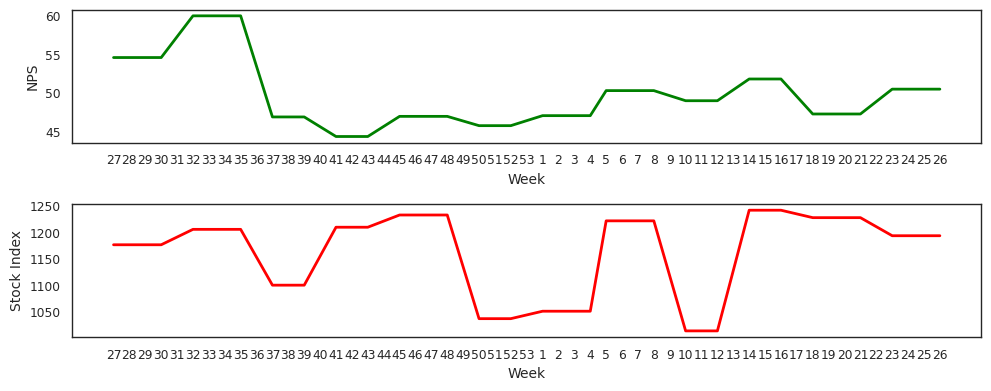

In [478]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(10, 4), dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.set_style("white") # white/whitegrid/dark/ticks
sns.set_context("paper") # talk/poster

# subplot 1
plt.subplot(2, 1, 1)
plt.plot(nps_stock_weekly1.iloc[0:,0], nps_stock_weekly1.iloc[:,1], 'g-', linewidth=2)
plt.xlabel('Week', fontsize=10);
plt.ylabel('NPS', fontsize=10);

# subplot 2
plt.subplot(2, 1, 2)
plt.plot(nps_stock_weekly1.iloc[0:,0], nps_stock_weekly1.iloc[:,2], 'r-', linewidth=2)
plt.xlabel('Week', fontsize=10);
plt.ylabel('Stock Index', fontsize=10);

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

In [479]:
media_investment_weekly1 = media_investment_weekly.copy()
media_investment_weekly1['Week'] = media_investment_weekly['Week'].astype(str)

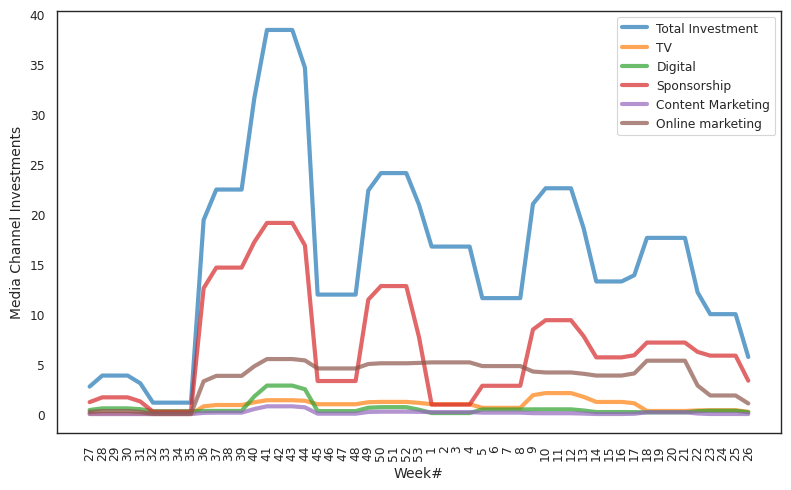

In [483]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(8, 5), dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.set_style("white") # white/whitegrid/dark/ticks
sns.set_context("paper") # talk/poster

# subplot 1
plt.subplot(1, 1, 1)
plt.plot(media_investment_weekly1.iloc[:,0], media_investment_weekly1.iloc[:,1:7], linewidth=3, alpha = 0.7)
plt.xticks(rotation=90)
plt.xlabel('Week#', fontsize=10)
plt.ylabel('Media Channel Investments', fontsize=10)
plt.legend(media_investment_weekly1.iloc[:,1:7])
# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

# **Modelling**

## **Additive Linear Regression Model**

**Data Preparation for Modelling**

In [244]:
# making a copy of original dataframes
cameraaccessory_df_weekly_model = cameraaccessory_df_weekly.copy()
gamingaccessory_df_weekly_model = gamingaccessory_df_weekly.copy()
homeaudio_df_weekly_model = homeaudio_df_weekly.copy()

**Dropping Week column as it is just a row identifier and not add anything as information to the model** 

In [245]:
cameraaccessory_df_weekly_model.drop('Week',axis=1,inplace=True)
gamingaccessory_df_weekly_model.drop('Week',axis=1,inplace=True)
homeaudio_df_weekly_model.drop('Week',axis=1,inplace=True)

In [246]:
cameraaccessory_df_weekly_model.head()

,gmv,Discount_Percent,sla,product_procurement_sla,is_cod,is_mass_market,product_vertical_CameraAccessory,product_vertical_CameraBag,product_vertical_CameraBattery,product_vertical_CameraBatteryCharger,product_vertical_CameraFilmRolls,product_vertical_CameraMount,product_vertical_CameraRemoteControl,product_vertical_CameraTripod,product_vertical_Filter,product_vertical_Flash,product_vertical_Lens,product_vertical_Others,product_vertical_Strap,product_vertical_Telescope,Total Investment,Total Investment_SMA_3,Total Investment_SMA_5,Total Investment_EMA_7,Total_Investment_Ad_Stock,TV,TV_SMA_3,TV_SMA_5,TV_EMA_7,TV_Ad_Stock,Digital,Digital_SMA_3,Digital_SMA_5,Digital_EMA_7,Digital_Ad_Stock,Sponsorship,Sponsorship_SMA_3,Sponsorship_SMA_5,Sponsorship_EMA_7,Sponsorship_Ad_Stock,...,Content_Marketing_Ad_Stock,Online marketing,Online marketing_SMA_3,Online marketing_SMA_5,Online marketing_EMA_7,Online_marketing_Ad_Stock,Affiliates,Affiliates_SMA_3,Affiliates_SMA_5,Affiliates_EMA_7,Affiliates_Ad_Stock,SEM,SEM_SMA_3,SEM_SMA_5,SEM_EMA_7,SEM_Ad_Stock,Radio,Radio_SMA_3,Radio_SMA_5,Radio_EMA_7,Radio_Ad_Stock,Other,Other_SMA_3,Other_SMA_5,Other_EMA_7,Other_Ad_Stock,Sale_Dates,NPS,Stock Index,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm),payday_week,holiday_week
0,15731.0,50.621494,2.230769,2.884615,0,25,1,2.0,4.0,2.0,0,0,1.0,13.0,0.0,0.0,2.0,0,0,0,2.751899,0.000000,0.000000,2.751899,2.751899,0.034731,0.000000,0.000000,0.034731,0.034731,0.408551,0.000000,0.000000,0.408551,0.408551,1.195850,0.000000,0.000000,1.195850,1.195850,...,0.000150,0.214077,0.000000,0.000000,0.214077,0.214077,0.088267,0.000000,0.000000,0.088267,0.088267,0.810274,0.000000,0.000000,0.810274,0.810274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.599588,1177.0,28.0,10.0,19.360000,0.100000,1.460000,0.000000,0.0,0.000000,0.0,0,0
1,3975505.0,43.971299,7.067365,2.780803,1909,2197,46,333.0,690.0,223.0,0,4,141.0,435.0,220.0,26.0,489.0,18,13,16,3.852659,0.000000,0.000000,3.027089,5.503799,0.048623,0.000000,0.000000,0.038204,0.069461,0.571971,0.000000,0.000000,0.449406,0.817101,1.674190,0.000000,0.000000,1.315435,2.391700,...,0.000301,0.299708,0.000000,0.000000,0.235485,0.428154,0.123573,0.000000,0.000000,0.097093,0.176534,1.134383,0.000000,0.000000,0.891301,1.620548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.599588,1177.0,28.0,12.5,20.100000,0.283333,2.383333,4.416667,0.0,4.416667,0.0,0,0
2,4390316.0,44.335060,6.436647,2.812865,2033,2350,36,356.0,752.0,225.0,0,11,142.0,495.0,186.0,27.0,526.0,9,24,22,3.852659,3.485739,0.000000,3.233482,7.154938,0.048623,0.043992,0.000000,0.040809,0.090300,0.571971,0.517497,0.000000,0.480047,1.062232,1.674190,1.514743,0.000000,1.405124,3.109210,...,0.000391,0.299708,0.271164,0.000000,0.251541,0.556600,0.123573,0.111805,0.000000,0.103713,0.229494,1.134383,1.026347,0.000000,0.952072,2.106712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,54.599588,1177.0,33.0,11.0,23.183333,0.000000,5.183333,1.400000,0.0,1.400000,0.0,1,0
3,4368719.0,43.608486,6.437069,2.865922,2053,2324,48,295.0,773.0,267.0,0,7,108.0,465.0,186.0,31.0,573.0,12,23,30,3.852659,3.852659,0.000000,3.388276,8.145622,0.048623,0.048623,0.000000,0.042762,0.102803,0.571971,0.571971,0.000000,0.503028,1.209310,1.674190,1.674190,0.000000,1.472390,3.539716,...,0.000445,0.299708,0.299708,0.000000,0.263582,0.633668,0.123573,0.123573,0.000000,0.108678,0.261270,1.134383,1.134383,0.000000,0.997650,2.398410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.599588,1177.0,31.5,14.5,23.060000,0.000000,5.060000,1.080000,0.0,1.080000,0.0,0,0
4,2790458.0,42.999851,6.394240,2.823237,1406,1537,45,185.0,484.0,180.0,0,2,84.0,360.0,109.0,28.0,331.0,12,23,13,3.078629,3.594649,3.477701,3.310864,7.966002,0.035146,0.044131,0.043149,0.040858,0.096828,0.491007,0.544983,0.523094,0.500023,1.216593,1.264452,1.537611,1.496574,1.420406,3.388282,...,0.000418,0.222415,0.273944,0.267123,0.253291,0.602616,0.093021,0.113389,0.110402,0.104764,0.249782,0.97243

**Train test split**

In [247]:
cameraaccessory_df_weekly_model_train, cameraaccessory_df_weekly_model_test = train_test_split(cameraaccessory_df_weekly_model, train_size=0.7, test_size=0.3, random_state=100)
gamingaccessory_df_weekly_model_train, gamingaccessory_df_weekly_model_test = train_test_split(gamingaccessory_df_weekly_model, train_size=0.7, test_size=0.3, random_state=100)
homeaudio_df_weekly_model_train, homeaudio_df_weekly_model_test = train_test_split(homeaudio_df_weekly_model, train_size=0.7, test_size=0.3, random_state=100)

In [248]:
cameraaccessory_df_weekly_model_train.head()

,gmv,Discount_Percent,sla,product_procurement_sla,is_cod,is_mass_market,product_vertical_CameraAccessory,product_vertical_CameraBag,product_vertical_CameraBattery,product_vertical_CameraBatteryCharger,product_vertical_CameraFilmRolls,product_vertical_CameraMount,product_vertical_CameraRemoteControl,product_vertical_CameraTripod,product_vertical_Filter,product_vertical_Flash,product_vertical_Lens,product_vertical_Others,product_vertical_Strap,product_vertical_Telescope,Total Investment,Total Investment_SMA_3,Total Investment_SMA_5,Total Investment_EMA_7,Total_Investment_Ad_Stock,TV,TV_SMA_3,TV_SMA_5,TV_EMA_7,TV_Ad_Stock,Digital,Digital_SMA_3,Digital_SMA_5,Digital_EMA_7,Digital_Ad_Stock,Sponsorship,Sponsorship_SMA_3,Sponsorship_SMA_5,Sponsorship_EMA_7,Sponsorship_Ad_Stock,...,Content_Marketing_Ad_Stock,Online marketing,Online marketing_SMA_3,Online marketing_SMA_5,Online marketing_EMA_7,Online_marketing_Ad_Stock,Affiliates,Affiliates_SMA_3,Affiliates_SMA_5,Affiliates_EMA_7,Affiliates_Ad_Stock,SEM,SEM_SMA_3,SEM_SMA_5,SEM_EMA_7,SEM_Ad_Stock,Radio,Radio_SMA_3,Radio_SMA_5,Radio_EMA_7,Radio_Ad_Stock,Other,Other_SMA_3,Other_SMA_5,Other_EMA_7,Other_Ad_Stock,Sale_Dates,NPS,Stock Index,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm),payday_week,holiday_week
48,4929109.0,56.332159,5.755358,2.369415,4443,4743,44,361.0,613.0,331.0,106,2,91.0,228.0,213.0,2275.0,862.0,18,35,64,9.994650,13.265132,15.009389,14.290861,32.786708,0.387967,0.354276,0.336308,0.520505,0.994488,0.331511,0.263951,0.227919,0.252140,0.666459,5.844660,6.405612,6.704786,6.496254,15.889124,...,0.188465,1.859970,3.351550,4.147059,3.774745,8.220107,0.645872,1.027134,1.230474,1.164672,2.546231,0.871620,1.166778,1.324196,1.207523,2.855988,0.000000,0.106452,0.163226,0.119372,0.241103,0.000000,0.482613,0.740006,0.649681,1.123984,0.0,50.516687,1194.0,35.0,9.0,20.70,0.566667,3.266667,0.00,0.0,0.00,0.0,0,0
44,5514854.0,55.864677,5.720317,2.446493,4539,4827,43,453.0,716.0,406.0,68,11,93.0,612.0,233.0,1933.0,795.0,17,55,52,17.625774,16.379721,15.133669,16.345436,41.162261,0.309355,0.567981,0.826607,0.881305,1.612876,0.173871,0.182320,0.190768,0.229961,0.485463,7.153548,6.730234,6.306920,6.664384,16.920090,...,0.309461,5.340323,4.915483,4.490644,4.615396,12.125750,1.535484,1.476338,1.417192,1.442993,3.672006,1.560323,1.395847,1.231371,1.280976,3.430449,0.248387,0.177419,0.106452,0.142031,0.427868,1.126097,0.804355,0.482613,0.986798,2.178298,0.0,47.306951,1228.0,25.5,2.5,12.85,5.225000,0.075000,4.25,0.0,4.25,0.0,1,0
37,4582096.0,49.083795,5.814055,2.497305,3267,4055,29,288.0,1082.0,503.0,41,30,101.0,491.0,180.0,1279.0,484.0,16,44,50,22.586205,22.586205,20.074789,19.618976,52.811783,2.100000,2.100000,1.762676,1.652439,4.742569,0.474194,0.474194,0.471332,0.451907,1.168569,9.391290,9.391290,7.891637,7.319375,21.120834,...,0.232936,4.163378,4.163378,4.309259,4.405681,10.649829,1.403989,1.403989,1.439768,1.462379,3.569318,1.172746,1.172746,1.173580,1.195308,2.930366,0.196452,0.196452,0.151548,0.175127,0.444268,3.600607,3.600607,2.777611,2.846496,7.953093,0.0,49.020550,1015.0,20.5,-3.5,5.72,12.280000,0.000000,12.80,0.0,12.80,0.0,0,1
17,5904660.0,48.274482,6.211004,2.907892,3791,3828,36,321.0,638.0,216.0,21,29,142.0,791.0,259.0,1294.0,684.0,15,29,14,11.950451,28.337842,32.371661,26.629479,64.572198,0.984814,1.234105,1.295469,1.125336,2.944351,0.297609,1.877808,2.266780,1.630458,3.974124,3.306827,13.095689,15.505255,13.004700,29.724236,...,1.044973,4.564367,5.145614,5.288690,4.681671,12.424326,1.539012,1.561110,1.566550,1.416845,3.819138,1.218474,4.927096,5.839988,4.334756,10.641049,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,47.000000,1233.0,23.0,5.0,13.92,4.080000,0.000000,1.72,0.0,1.72,0.0,0,0
7,1190.0,40.964888,10.333333,2.000000,1,3,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,3.0,0,0,0,1.143553,1.143553,1.530568,1.829304,3.520765,0.001454,0.001454,0.008192,0.013922,0.015712,0

**Feature Scaling**

In [249]:
cameraaccessory_cols = list(cameraaccessory_df_weekly_model.columns)
gamingaccessory_cols = list(gamingaccessory_df_weekly_model.columns)
homeaudio_cols = list(homeaudio_df_weekly_model.columns)

In [250]:
scaler = StandardScaler()
cameraaccessory_df_weekly_model_train[cameraaccessory_cols] = scaler.fit_transform(cameraaccessory_df_weekly_model_train[cameraaccessory_cols])
cameraaccessory_df_weekly_model_test[cameraaccessory_cols] = scaler.transform(cameraaccessory_df_weekly_model_test[cameraaccessory_cols])
gamingaccessory_df_weekly_model_train[gamingaccessory_cols] = scaler.fit_transform(gamingaccessory_df_weekly_model_train[gamingaccessory_cols])
gamingaccessory_df_weekly_model_test[gamingaccessory_cols] = scaler.transform(gamingaccessory_df_weekly_model_test[gamingaccessory_cols])
homeaudio_df_weekly_model_train[homeaudio_cols] = scaler.fit_transform(homeaudio_df_weekly_model_train[homeaudio_cols])
homeaudio_df_weekly_model_test[homeaudio_cols] = scaler.transform(homeaudio_df_weekly_model_test[homeaudio_cols])

In [251]:
cameraaccessory_df_weekly_model_X_train = cameraaccessory_df_weekly_model_train.drop("gmv",axis=1)
cameraaccessory_df_weekly_model_y_train = cameraaccessory_df_weekly_model_train.gmv
cameraaccessory_df_weekly_model_X_test = cameraaccessory_df_weekly_model_test.drop("gmv",axis=1)
cameraaccessory_df_weekly_model_y_test = cameraaccessory_df_weekly_model_test.gmv

gamingaccessory_df_weekly_model_X_train = gamingaccessory_df_weekly_model_train.drop("gmv",axis=1)
gamingaccessory_df_weekly_model_y_train = gamingaccessory_df_weekly_model_train.gmv
gamingaccessory_df_weekly_model_X_test = gamingaccessory_df_weekly_model_test.drop("gmv",axis=1)
gamingaccessory_df_weekly_model_y_test = gamingaccessory_df_weekly_model_test.gmv

homeaudio_df_weekly_model_X_train = homeaudio_df_weekly_model_train.drop("gmv",axis=1)
homeaudio_df_weekly_model_y_train = homeaudio_df_weekly_model_train.gmv
homeaudio_df_weekly_model_X_test = homeaudio_df_weekly_model_test.drop("gmv",axis=1)
homeaudio_df_weekly_model_y_test = homeaudio_df_weekly_model_test.gmv

In [252]:
cameraaccessory_df_weekly_model_X_train.head()

,Discount_Percent,sla,product_procurement_sla,is_cod,is_mass_market,product_vertical_CameraAccessory,product_vertical_CameraBag,product_vertical_CameraBattery,product_vertical_CameraBatteryCharger,product_vertical_CameraFilmRolls,product_vertical_CameraMount,product_vertical_CameraRemoteControl,product_vertical_CameraTripod,product_vertical_Filter,product_vertical_Flash,product_vertical_Lens,product_vertical_Others,product_vertical_Strap,product_vertical_Telescope,Total Investment,Total Investment_SMA_3,Total Investment_SMA_5,Total Investment_EMA_7,Total_Investment_Ad_Stock,TV,TV_SMA_3,TV_SMA_5,TV_EMA_7,TV_Ad_Stock,Digital,Digital_SMA_3,Digital_SMA_5,Digital_EMA_7,Digital_Ad_Stock,Sponsorship,Sponsorship_SMA_3,Sponsorship_SMA_5,Sponsorship_EMA_7,Sponsorship_Ad_Stock,Content Marketing,...,Content_Marketing_Ad_Stock,Online marketing,Online marketing_SMA_3,Online marketing_SMA_5,Online marketing_EMA_7,Online_marketing_Ad_Stock,Affiliates,Affiliates_SMA_3,Affiliates_SMA_5,Affiliates_EMA_7,Affiliates_Ad_Stock,SEM,SEM_SMA_3,SEM_SMA_5,SEM_EMA_7,SEM_Ad_Stock,Radio,Radio_SMA_3,Radio_SMA_5,Radio_EMA_7,Radio_Ad_Stock,Other,Other_SMA_3,Other_SMA_5,Other_EMA_7,Other_Ad_Stock,Sale_Dates,NPS,Stock Index,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm),payday_week,holiday_week
48,1.668052,-0.708356,-1.388645,0.979883,0.828199,0.200793,0.202950,-0.360405,0.440540,2.301470,-1.419486,-0.433031,-0.908904,-0.190854,1.861413,0.527205,1.126543,0.227716,1.680120,-0.767421,-0.381392,-0.126138,-0.259272,-0.428472,-0.841486,-0.932077,-0.949462,-0.659778,-0.889089,-0.444949,-0.497870,-0.523126,-0.731231,-0.577016,-0.395432,-0.212457,-0.085849,-0.181783,-0.245430,-0.759509,...,-0.530673,-1.092456,-0.199963,0.281890,0.132454,-0.227925,-1.030294,-0.251753,0.156871,0.087020,-0.258920,-0.619774,-0.431597,-0.287816,-0.525878,-0.505132,-0.454803,0.153933,0.550985,0.371962,0.126898,-0.416951,-0.198573,-0.056311,-0.109000,-0.236534,-0.559523,0.374902,0.392148,1.356218,0.567259,0.862338,-0.827864,0.730137,-0.841329,-0.246047,-0.885948,-0.228882,-0.866025,-0.408248
44,1.567332,-0.751193,-1.046668,1.046158,0.882447,0.109524,0.842383,0.060476,1.045044,1.038700,-0.667993,-0.391164,-0.083354,-0.042905,1.407493,0.333276,0.928408,1.703656,0.998332,-0.001750,-0.052524,-0.112414,0.016450,-0.036010,-0.985533,-0.515046,0.021757,0.140125,-0.381484,-0.642435,-0.609322,-0.581851,-0.775982,-0.693007,-0.170499,-0.153108,-0.163646,-0.140817,-0.160583,-0.027930,...,-0.263719,0.878485,0.685337,0.474216,0.638747,0.692704,0.667589,0.583893,0.492780,0.625231,0.604435,-0.261673,-0.302516,-0.347197,-0.466315,-0.355132,1.149928,0.628425,0.143034,0.576711,0.702309,0.288459,0.010979,-0.238954,0.183837,0.077854,-0.559523,-0.487188,0.854412,0.309948,-0.203197,-0.045789,-0.166431,-0.705062,0.497340,-0.246047,0.449889,-0.228882,1.154701,-0.408248
37,0.106375,-0.636601,-0.821227,0.168015,0.383875,-1.168252,-0.304426,1.556034,1.826869,0.141468,0.918491,-0.223693,-0.343488,-0.434970,0.539471,-0.566900,0.730272,0.891889,0.884701,0.495955,0.602815,0.433238,0.455755,0.509864,2.295596,2.474587,1.875989,1.849750,2.187535,-0.266201,-0.210822,-0.138357,-0.328173,-0.255240,0.214058,0.333404,0.146223,0.018776,0.185130,-0.441242,...,-0.432555,0.211976,0.259591,0.372683,0.512443,0.344803,0.416623,0.449304,0.533395,0.662718,0.525684,-0.463199,-0.428234,-0.384167,-0.535784,-0.485711,0.814393,0.755675,0.467077,0.875777,0.752839,1.838545,1.832188,1.389544,1.799263,1.799849,-0.559523,-0.026939,-2.041537,-0.240721,-0.914388,-0.870623,0.835301,-0.738788,3.190426,-0.246047,3.137277,-0.228882,-0.866025,2.449490
17,-0.067993,-0.151341,1.000449,0.529766,0.237274,-0.529364,-0.075064,-0.258249,-0.486367,-0.523148,0.834992,0.634594,0.301473,0.149428,0.559379,0.011991,0.532136,-0.215065,-1.160662,-0.571185,1.210128,1.791191,1.396555,1.060934,0.252159,0.784851,0.950513,0.681149,0.711462,-0.487419,1.705556,2.699751,2.049726,1.542696,-0.831559,1.010666

### **Simple Linear Regression Model for CameraAccessory**

In [253]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

cameraaccessory_model = LinearRegression().fit(cameraaccessory_df_weekly_model_X_train, cameraaccessory_df_weekly_model_y_train)

cameraaccessory_rfe = RFECV(cameraaccessory_model,cv=5,scoring='neg_mean_squared_error')             # running RFE
cameraaccessory_rfe = cameraaccessory_rfe.fit(cameraaccessory_df_weekly_model_X_train, cameraaccessory_df_weekly_model_y_train)

In [254]:
num_features = cameraaccessory_df_weekly_model_X_train.shape
num_features[1]

83

In [255]:
cameraaccessory_rfe.n_features_

34

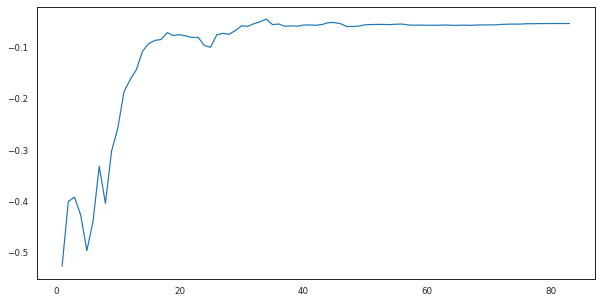

In [256]:
plt.figure(figsize=[10, 5])
plt.plot(range(1, num_features[1]+1), cameraaccessory_rfe.grid_scores_)
plt.show();

In [257]:
cameraaccessory_model = LinearRegression().fit(cameraaccessory_df_weekly_model_X_train, cameraaccessory_df_weekly_model_y_train)

cameraaccessory_rfe = RFE(cameraaccessory_model,15)             # 15 seems ideal number of features
cameraaccessory_rfe = cameraaccessory_rfe.fit(cameraaccessory_df_weekly_model_X_train, cameraaccessory_df_weekly_model_y_train)

col = list(cameraaccessory_df_weekly_model_X_train.columns[cameraaccessory_rfe.support_])

cameraaccessory_model = LinearRegression().fit(cameraaccessory_df_weekly_model_X_train[col], cameraaccessory_df_weekly_model_y_train)

cameraaccessory_df_weekly_model_y_test_pred = cameraaccessory_model.predict(cameraaccessory_df_weekly_model_X_test[col])

print('R2 Score: {}'.format(r2_score(cameraaccessory_df_weekly_model_y_test, cameraaccessory_df_weekly_model_y_test_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(cameraaccessory_df_weekly_model_y_test, cameraaccessory_df_weekly_model_y_test_pred)))

R2 Score: 0.7010568442884613
Mean Squared Error: 0.31524869740536615


#### **Simple Linear Regression for CameraAccessory with K-Fold Cross validation**

In [258]:
cameraaccessory_df_weekly_cv = cameraaccessory_df_weekly_model.copy()

**Feature Scaling**

In [259]:
scaler = StandardScaler()
cameraaccessory_df_weekly_cv[cameraaccessory_df_weekly_cv.columns]=scaler.fit_transform(cameraaccessory_df_weekly_cv[cameraaccessory_df_weekly_cv.columns])

In [260]:
cameraaccessory_df_weekly_cv_X = cameraaccessory_df_weekly_cv.drop("gmv",axis=1)
cameraaccessory_df_weekly_cv_y = cameraaccessory_df_weekly_cv.gmv

**Model Building**

In [261]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn import metrics

cameraaccessory_model_cv = LinearRegression().fit(cameraaccessory_df_weekly_cv_X[col], cameraaccessory_df_weekly_cv_y)

cameraaccessory_predictions_cv = cross_val_predict(cameraaccessory_model_cv, cameraaccessory_df_weekly_cv_X[col], cameraaccessory_df_weekly_cv_y, cv=5)
accuracy = metrics.r2_score(cameraaccessory_df_weekly_cv_y, cameraaccessory_predictions_cv)
print("Cross-Predicted Accuracy:", accuracy)
print('Mean Squared Error: {}'.format(mean_squared_error(cameraaccessory_df_weekly_cv_y, cameraaccessory_predictions_cv)))

Cross-Predicted Accuracy: 0.8554282097273858
Mean Squared Error: 0.14457179027261421


#### **Determining Feature Importance for cameraaccessory from model without cv**

In [262]:
# linear regression model parameters
#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 
pd.set_option('display.precision',1)

cameraaccessory_model = LinearRegression().fit(cameraaccessory_df_weekly_model_X_train[col], cameraaccessory_df_weekly_model_y_train)
cameraaccessory_lr_model_parameters = list(cameraaccessory_model.coef_)
#cameraaccessory_lr_model_parameters.insert(0, cameraaccessory_model.intercept_)
cameraaccessory_lr_model_parameters = [abs(round(x, 3)) for x in cameraaccessory_lr_model_parameters]
cameraaccessory_lr_coef = list(zip(col, cameraaccessory_lr_model_parameters))
cameraaccessory_lr_coef

[('product_vertical_CameraBattery', 0.382),
 ('product_vertical_CameraTripod', 0.147),
 ('product_vertical_Lens', 0.377),
 ('product_vertical_Others', 0.094),
 ('Total Investment_SMA_3', 9.079),
 ('TV_SMA_5', 0.728),
 ('Digital_SMA_3', 2.144),
 ('Sponsorship_SMA_3', 5.361),
 ('Online marketing_SMA_3', 2.77),
 ('Online_marketing_Ad_Stock', 2.153),
 ('Affiliates_SMA_3', 0.26),
 ('Affiliates_Ad_Stock', 2.479),
 ('Radio', 0.227),
 ('Other_SMA_3', 1.895),
 ('Sale_Dates', 0.172)]

In [263]:
cameraaccessory_lr_coef_df = pd.DataFrame(cameraaccessory_lr_coef)
col_rename = {0:'Features',1: 'Coefficients'}
cameraaccessory_lr_coef_df = cameraaccessory_lr_coef_df.rename(columns=col_rename)
cameraaccessory_lr_coef_df = cameraaccessory_lr_coef_df.loc[cameraaccessory_lr_coef_df['Coefficients']!=0.0]
cameraaccessory_lr_coef_df = cameraaccessory_lr_coef_df.sort_values(by=['Coefficients'], ascending = False)
cameraaccessory_lr_coef_df

,Features,Coefficients
4,Total Investment_SMA_3,9.079
7,Sponsorship_SMA_3,5.361
8,Online marketing_SMA_3,2.770
11,Affiliates_Ad_Stock,2.479
9,Online_marketing_Ad_Stock,2.153
6,Digital_SMA_3,2.144
13,Other_SMA_3,1.895
5,TV_SMA_5,0.728
0,product_vertical_CameraBattery,0.382
2,product_vertical_Lens,0.377


#### **Plotting the Features in descending order of Importance for cameraaccessory**

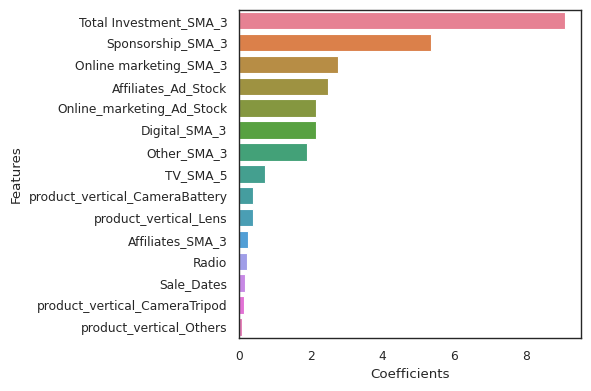

In [264]:
# Slightly alter the figure size to make it more horizontal.
plt.figure( dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.barplot(y='Features', x='Coefficients', palette='husl', data=cameraaccessory_lr_coef_df, estimator=np.sum)
# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

### **Simple Linear Regression for GamingAccessory**

In [265]:
gamingaccessory_model = LinearRegression().fit(gamingaccessory_df_weekly_model_X_train, gamingaccessory_df_weekly_model_y_train)

gamingaccessory_rfe = RFECV(gamingaccessory_model, cv=5,scoring='neg_mean_squared_error')             # running RFE
gamingaccessory_rfe = gamingaccessory_rfe.fit(gamingaccessory_df_weekly_model_X_train, gamingaccessory_df_weekly_model_y_train)

In [266]:
gamingaccessory_rfe.n_features_

30

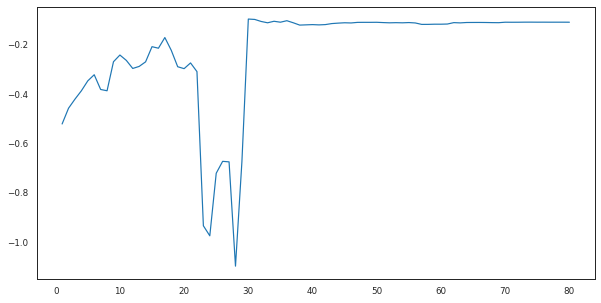

In [267]:
plt.figure(figsize=[10, 5])
plt.plot(range(1, gamingaccessory_df_weekly_model_X_train.shape[1]+1), gamingaccessory_rfe.grid_scores_)
plt.show();

In [268]:
gamingaccessory_model = LinearRegression().fit(gamingaccessory_df_weekly_model_X_train, gamingaccessory_df_weekly_model_y_train)

gamingaccessory_rfe = RFE(gamingaccessory_model, 12)             # running RFE
gamingaccessory_rfe = gamingaccessory_rfe.fit(gamingaccessory_df_weekly_model_X_train, gamingaccessory_df_weekly_model_y_train)

col = list(gamingaccessory_df_weekly_model_X_train.columns[gamingaccessory_rfe.support_])

gamingaccessory_model = LinearRegression().fit(gamingaccessory_df_weekly_model_X_train[col], gamingaccessory_df_weekly_model_y_train)

gamingaccessory_df_weekly_model_y_test_pred = gamingaccessory_model.predict(gamingaccessory_df_weekly_model_X_test[col])

print('R2 Score: {}'.format(r2_score(gamingaccessory_df_weekly_model_y_test, gamingaccessory_df_weekly_model_y_test_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(gamingaccessory_df_weekly_model_y_test, gamingaccessory_df_weekly_model_y_test_pred)))

R2 Score: 0.8651941612796668
Mean Squared Error: 0.17452152694501952


#### **Simple Linear Regression for GamingAccessory with K-Fold Cross validation**

In [269]:
gamingaccessory_df_weekly_cv = gamingaccessory_df_weekly_model.copy()

**Feature Scaling**

In [270]:
scaler = StandardScaler()
gamingaccessory_df_weekly_cv[gamingaccessory_df_weekly_cv.columns]=scaler.fit_transform(gamingaccessory_df_weekly_cv[gamingaccessory_df_weekly_cv.columns])

In [271]:
gamingaccessory_df_weekly_cv_X = gamingaccessory_df_weekly_cv.drop("gmv",axis=1)
gamingaccessory_df_weekly_cv_y = gamingaccessory_df_weekly_cv.gmv

**Model Building**

In [272]:
gamingaccessory_model_cv = LinearRegression().fit(gamingaccessory_df_weekly_cv_X[col], gamingaccessory_df_weekly_cv_y)

gamingaccessory_predictions_cv = cross_val_predict(gamingaccessory_model_cv, gamingaccessory_df_weekly_cv_X[col], gamingaccessory_df_weekly_cv_y, cv=5)
accuracy = metrics.r2_score(gamingaccessory_df_weekly_cv_y, gamingaccessory_predictions_cv)
print("Cross-Predicted Accuracy:", accuracy)
print('Mean Squared Error: {}'.format(mean_squared_error(gamingaccessory_df_weekly_cv_y, gamingaccessory_predictions_cv)))

Cross-Predicted Accuracy: 0.5285992756467595
Mean Squared Error: 0.4714007243532403


#### **Determining Feature Importance for gamingaccessory from model without cv**

In [273]:
# linear regression model parameters
#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 
pd.set_option('display.precision',1)

gamingaccessory_model = LinearRegression().fit(gamingaccessory_df_weekly_model_X_train[col], gamingaccessory_df_weekly_model_y_train)
gamingaccessory_lr_model_parameters = list(gamingaccessory_model.coef_)
gamingaccessory_lr_model_parameters = [abs(round(x, 3)) for x in gamingaccessory_lr_model_parameters]
gamingaccessory_lr_coef = list(zip(col, gamingaccessory_lr_model_parameters))
gamingaccessory_lr_coef

[('is_mass_market', 0.807),
 ('product_vertical_Others', 0.48),
 ('TV', 0.301),
 ('TV_SMA_5', 1.296),
 ('TV_EMA_7', 0.659),
 ('Sponsorship', 0.611),
 ('Sponsorship_EMA_7', 0.851),
 ('Online marketing_EMA_7', 1.813),
 ('Online_marketing_Ad_Stock', 3.687),
 ('Affiliates_SMA_3', 0.961),
 ('SEM_SMA_5', 0.316),
 ('NPS', 0.885)]

In [274]:
gamingaccessory_lr_coef_df = pd.DataFrame(gamingaccessory_lr_coef)
col_rename = {0:'Features',1: 'Coefficients'}
gamingaccessory_lr_coef_df = gamingaccessory_lr_coef_df.rename(columns=col_rename)
gamingaccessory_lr_coef_df = gamingaccessory_lr_coef_df.loc[gamingaccessory_lr_coef_df['Coefficients']!=0.0]
gamingaccessory_lr_coef_df = gamingaccessory_lr_coef_df.sort_values(by=['Coefficients'], ascending = False)
gamingaccessory_lr_coef_df

,Features,Coefficients
8,Online_marketing_Ad_Stock,3.687
7,Online marketing_EMA_7,1.813
3,TV_SMA_5,1.296
9,Affiliates_SMA_3,0.961
11,NPS,0.885
6,Sponsorship_EMA_7,0.851
0,is_mass_market,0.807
4,TV_EMA_7,0.659
5,Sponsorship,0.611
1,product_vertical_Others,0.480


#### **Plotting the Features in descending order of Importance for gamingaccessory**

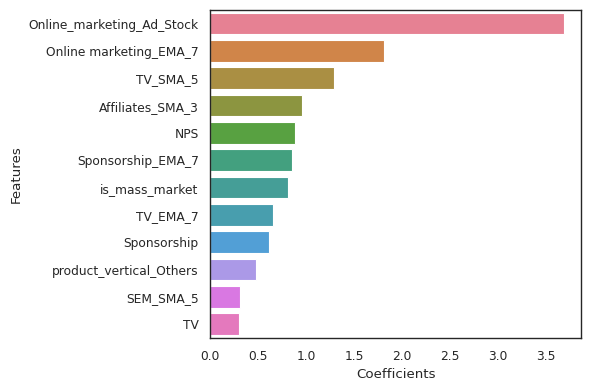

In [275]:
# Slightly alter the figure size to make it more horizontal.
plt.figure( dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.barplot(y='Features', x='Coefficients', palette='husl', data=gamingaccessory_lr_coef_df, estimator=np.sum)
# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

### **Simple Linear Regression for HomeAudio**

In [276]:
homeaudio_model = LinearRegression().fit(homeaudio_df_weekly_model_X_train, homeaudio_df_weekly_model_y_train)

homeaudio_rfe = RFECV(homeaudio_model, cv=5, scoring='neg_mean_squared_error')             # running RFE
homeaudio_rfe = homeaudio_rfe.fit(homeaudio_df_weekly_model_X_train, homeaudio_df_weekly_model_y_train)

In [277]:
homeaudio_rfe.n_features_

11

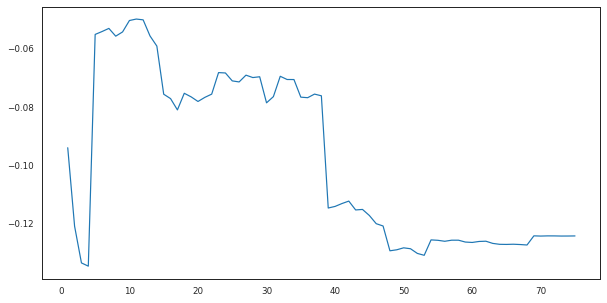

In [278]:
plt.figure(figsize=[10, 5])
plt.plot(range(1, homeaudio_df_weekly_model_X_train.shape[1]+1), homeaudio_rfe.grid_scores_)
plt.show();

In [279]:
homeaudio_model = LinearRegression().fit(homeaudio_df_weekly_model_X_train, homeaudio_df_weekly_model_y_train)

homeaudio_rfe = RFE(homeaudio_model, 11)             # running RFE
homeaudio_rfe = homeaudio_rfe.fit(homeaudio_df_weekly_model_X_train, homeaudio_df_weekly_model_y_train)

col = list(homeaudio_df_weekly_model_X_train.columns[homeaudio_rfe.support_])

homeaudio_model = LinearRegression().fit(homeaudio_df_weekly_model_X_train[col], homeaudio_df_weekly_model_y_train)

homeaudio_df_weekly_model_y_test_pred = homeaudio_model.predict(homeaudio_df_weekly_model_X_test[col])

print('R2 Score: {}'.format(r2_score(homeaudio_df_weekly_model_y_test, homeaudio_df_weekly_model_y_test_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(homeaudio_df_weekly_model_y_test, homeaudio_df_weekly_model_y_test_pred)))

R2 Score: 0.9931229829533548
Mean Squared Error: 0.0033194659179161855


#### **Simple Linear Regression for HomeAudio with K-Fold Cross validation**

In [280]:
homeaudio_df_weekly_cv = homeaudio_df_weekly_model.copy()

**Feature Scaling**

In [281]:
scaler = StandardScaler()
homeaudio_df_weekly_cv[homeaudio_df_weekly_cv.columns]=scaler.fit_transform(homeaudio_df_weekly_cv[homeaudio_df_weekly_cv.columns])

In [282]:
homeaudio_df_weekly_cv_X = homeaudio_df_weekly_cv.drop("gmv",axis=1)
homeaudio_df_weekly_cv_y = homeaudio_df_weekly_cv.gmv

**Model Building**

In [283]:
homeaudio_model_cv = LinearRegression().fit(homeaudio_df_weekly_cv_X[col], homeaudio_df_weekly_cv_y)

homeaudio_predictions_cv = cross_val_predict(homeaudio_model_cv, homeaudio_df_weekly_cv_X[col], homeaudio_df_weekly_cv_y, cv=5)
accuracy = metrics.r2_score(homeaudio_df_weekly_cv_y, homeaudio_predictions_cv)
print("Cross-Predicted Accuracy:", accuracy)
print('Mean Squared Error: {}'.format(mean_squared_error(homeaudio_df_weekly_cv_y, homeaudio_predictions_cv)))

Cross-Predicted Accuracy: 0.9344665681731373
Mean Squared Error: 0.06553343182686268


#### **Determining Feature Importance for gamingaccessory from model without cv**

In [284]:
# linear regression model parameters
#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 
pd.set_option('display.precision',1)

homeaudio_model = LinearRegression().fit(homeaudio_df_weekly_model_X_train[col], homeaudio_df_weekly_model_y_train)
homeaudio_lr_model_parameters = list(homeaudio_model.coef_)
homeaudio_lr_model_parameters = [abs(round(x, 3)) for x in homeaudio_lr_model_parameters]
homeaudio_lr_coef = list(zip(col, homeaudio_lr_model_parameters))
homeaudio_lr_coef

[('is_cod', 0.018),
 ('is_mass_market', 0.313),
 ('product_vertical_FMRadio', 0.144),
 ('product_vertical_HomeAudioSpeaker', 1.146),
 ('product_vertical_Others', 0.079),
 ('Total Investment_SMA_5', 0.045),
 ('Content Marketing_SMA_5', 0.18),
 ('Content_Marketing_Ad_Stock', 0.268),
 ('Online marketing', 0.399),
 ('Affiliates', 0.37),
 ('Affiliates_Ad_Stock', 0.107)]

In [285]:
homeaudio_lr_coef_df = pd.DataFrame(homeaudio_lr_coef)
col_rename = {0:'Features',1: 'Coefficients'}
homeaudio_lr_coef_df = homeaudio_lr_coef_df.rename(columns=col_rename)
homeaudio_lr_coef_df = homeaudio_lr_coef_df.loc[homeaudio_lr_coef_df['Coefficients']!=0.0]
homeaudio_lr_coef_df = homeaudio_lr_coef_df.sort_values(by=['Coefficients'], ascending = False)
homeaudio_lr_coef_df

,Features,Coefficients
3,product_vertical_HomeAudioSpeaker,1.146
8,Online marketing,0.399
9,Affiliates,0.370
1,is_mass_market,0.313
7,Content_Marketing_Ad_Stock,0.268
6,Content Marketing_SMA_5,0.180
2,product_vertical_FMRadio,0.144
10,Affiliates_Ad_Stock,0.107
4,product_vertical_Others,0.079
5,Total Investment_SMA_5,0.045


#### **Plotting the Features in descending order of Importance for homeaudio**

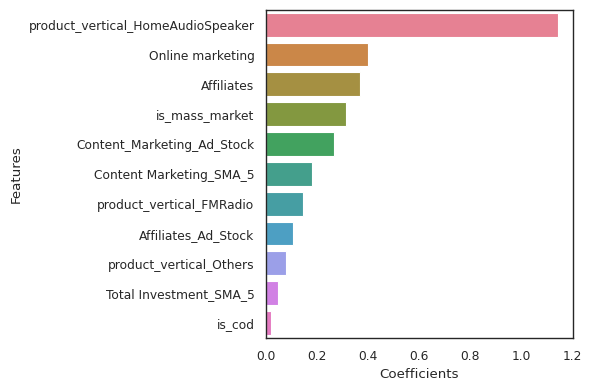

In [286]:
# Slightly alter the figure size to make it more horizontal.
plt.figure( dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.barplot(y='Features', x='Coefficients', palette='husl', data=homeaudio_lr_coef_df, estimator=np.sum)
# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

## **Multiplicative Linear Models**

**Data Preparation for Modelling**

In [287]:
# Making copy of dataframes from the original ones
cameraaccessory_mul_df = cameraaccessory_df_weekly.copy()
gamingaccessory_mul_df = gamingaccessory_df_weekly.copy()
homeaudio_mul_df = homeaudio_df_weekly.copy()

**Dropping Week column as it is just a row identifier and not add anything as information to the model**

In [288]:
cameraaccessory_mul_df.drop('Week',axis=1,inplace=True)
gamingaccessory_mul_df.drop('Week',axis=1,inplace=True)
homeaudio_mul_df.drop('Week',axis=1,inplace=True)

**Taking Logarithm of both the Dependent and the independent variables**

After taking log, all 0 values will be transformed to inf. Retransforming these values to 0.

In [289]:
cameraaccessory_mul_df = cameraaccessory_mul_df.applymap(lambda x: np.log(x))
cameraaccessory_mul_df = cameraaccessory_mul_df.replace([np.inf, -np.inf], 0)
cameraaccessory_mul_df = cameraaccessory_mul_df.replace(np.nan, 0)

gamingaccessory_mul_df = gamingaccessory_mul_df.applymap(lambda x: np.log(x))
gamingaccessory_mul_df = gamingaccessory_mul_df.replace([np.inf, -np.inf], 0)
gamingaccessory_mul_df = gamingaccessory_mul_df.replace(np.nan, 0)

homeaudio_mul_df = homeaudio_mul_df.applymap(lambda x: np.log(x))
homeaudio_mul_df = homeaudio_mul_df.replace([np.inf, -np.inf], 0)
homeaudio_mul_df = homeaudio_mul_df.replace(np.nan, 0)

**Train Test split**

In [290]:
cameraaccessory_mul_df_train, cameraaccessory_mul_df_test = train_test_split(cameraaccessory_mul_df, train_size=0.7, test_size=0.3, random_state=100)
gamingaccessory_mul_df_train, gamingaccessory_mul_df_test = train_test_split(gamingaccessory_mul_df, train_size=0.7, test_size=0.3, random_state=100)
homeaudio_mul_df_train, homeaudio_mul_df_test = train_test_split(homeaudio_mul_df, train_size=0.7, test_size=0.3, random_state=100)

**Feature Scaling**

In [291]:
cameraaccessory_cols = list(cameraaccessory_mul_df.columns)
gamingaccessory_cols = list(gamingaccessory_mul_df.columns)
homeaudio_cols = list(homeaudio_mul_df.columns)

In [292]:
scaler = StandardScaler()
cameraaccessory_mul_df_train[cameraaccessory_cols] = scaler.fit_transform(cameraaccessory_mul_df_train[cameraaccessory_cols])
cameraaccessory_mul_df_test[cameraaccessory_cols] = scaler.transform(cameraaccessory_mul_df_test[cameraaccessory_cols])
gamingaccessory_mul_df_train[gamingaccessory_cols] = scaler.fit_transform(gamingaccessory_mul_df_train[gamingaccessory_cols])
gamingaccessory_mul_df_test[gamingaccessory_cols] = scaler.transform(gamingaccessory_mul_df_test[gamingaccessory_cols])
homeaudio_mul_df_train[homeaudio_cols] = scaler.fit_transform(homeaudio_mul_df_train[homeaudio_cols])
homeaudio_mul_df_test[homeaudio_cols] = scaler.transform(homeaudio_mul_df_test[homeaudio_cols])

In [293]:
cameraaccessory_mul_df_X_train = cameraaccessory_mul_df_train.drop("gmv",axis=1)
cameraaccessory_mul_df_y_train = cameraaccessory_mul_df_train.gmv
cameraaccessory_mul_df_X_test = cameraaccessory_mul_df_test.drop("gmv",axis=1)
cameraaccessory_mul_df_y_test = cameraaccessory_mul_df_test.gmv

gamingaccessory_mul_df_X_train = gamingaccessory_mul_df_train.drop("gmv",axis=1)
gamingaccessory_mul_df_y_train = gamingaccessory_mul_df_train.gmv
gamingaccessory_mul_df_X_test = gamingaccessory_mul_df_test.drop("gmv",axis=1)
gamingaccessory_mul_df_y_test = gamingaccessory_mul_df_test.gmv

homeaudio_mul_df_X_train = homeaudio_mul_df_train.drop("gmv",axis=1)
homeaudio_mul_df_y_train = homeaudio_mul_df_train.gmv
homeaudio_mul_df_X_test = homeaudio_mul_df_test.drop("gmv",axis=1)
homeaudio_mul_df_y_test = homeaudio_mul_df_test.gmv

### **Simple Linear Regression Model for CameraAccessory**

In [294]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

cameraaccessory_mul_model = LinearRegression().fit(cameraaccessory_mul_df_X_train, cameraaccessory_mul_df_y_train)

cameraaccessory_mul_rfe = RFECV(cameraaccessory_mul_model,cv=5,scoring='neg_mean_squared_error')             # running RFE
cameraaccessory_mul_rfe = cameraaccessory_mul_rfe.fit(cameraaccessory_mul_df_X_train, cameraaccessory_mul_df_y_train)

In [295]:
cameraaccessory_mul_rfe.n_features_

23

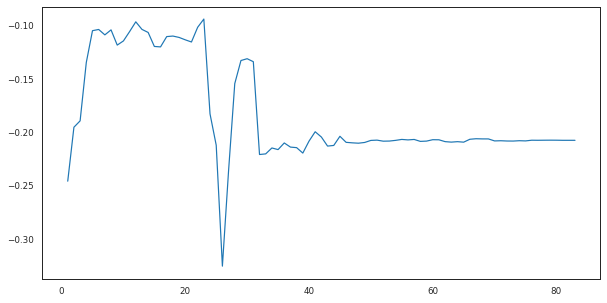

In [296]:
plt.figure(figsize=[10, 5])
plt.plot(range(1, cameraaccessory_mul_df_X_train.shape[1]+1), cameraaccessory_mul_rfe.grid_scores_)
plt.show();

In [297]:
cameraaccessory_mul_model = LinearRegression().fit(cameraaccessory_mul_df_X_train, cameraaccessory_mul_df_y_train)

cameraaccessory_mul_rfe = RFE(cameraaccessory_mul_model,12)             # 12 seems ideal number of features
cameraaccessory_mul_rfe = cameraaccessory_mul_rfe.fit(cameraaccessory_mul_df_X_train, cameraaccessory_mul_df_y_train)

col = list(cameraaccessory_mul_df_X_train.columns[cameraaccessory_mul_rfe.support_])

cameraaccessory_mul_model = LinearRegression().fit(cameraaccessory_mul_df_X_train[col], cameraaccessory_mul_df_y_train)

cameraaccessory_mul_df_y_test_pred = cameraaccessory_mul_model.predict(cameraaccessory_mul_df_X_test[col])

print('R2 Score: {}'.format(r2_score(cameraaccessory_mul_df_y_test, cameraaccessory_mul_df_y_test_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(cameraaccessory_mul_df_y_test, cameraaccessory_mul_df_y_test_pred)))

R2 Score: 0.9659069272240428
Mean Squared Error: 0.16217615827187737


#### **Simple Linear Regression for CameraAccessory with K-Fold Cross validation**

In [298]:
cameraaccessory_mul_df_cv = cameraaccessory_mul_df.copy()

**Feature Scaling**

In [299]:
scaler = StandardScaler()
cameraaccessory_mul_df_cv[cameraaccessory_mul_df_cv.columns]=scaler.fit_transform(cameraaccessory_mul_df_cv[cameraaccessory_mul_df_cv.columns])

In [300]:
cameraaccessory_mul_df_cv_X = cameraaccessory_mul_df_cv.drop("gmv",axis=1)
cameraaccessory_mul_df_cv_y = cameraaccessory_mul_df_cv.gmv

**Model Building**

In [301]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn import metrics

cameraaccessory_mul_model_cv = LinearRegression().fit(cameraaccessory_mul_df_cv_X[col], cameraaccessory_mul_df_cv_y)

cameraaccessory_mul_predictions_cv = cross_val_predict(cameraaccessory_mul_model_cv, cameraaccessory_mul_df_cv_X[col], cameraaccessory_mul_df_cv_y, cv=5)
accuracy = metrics.r2_score(cameraaccessory_mul_df_cv_y, cameraaccessory_mul_predictions_cv)
print("Cross-Predicted Accuracy:", accuracy)
print('Mean Squared Error: {}'.format(mean_squared_error(cameraaccessory_mul_df_cv_y, cameraaccessory_mul_predictions_cv)))

Cross-Predicted Accuracy: 0.8416655645248919
Mean Squared Error: 0.15833443547510798


#### **Determining Feature Importance for cameraaccessory from model without cv**

In [302]:
# linear regression model parameters
#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 
pd.set_option('display.precision',1)

cameraaccessory_mul_model = LinearRegression().fit(cameraaccessory_mul_df_X_train[col], cameraaccessory_mul_df_y_train)
cameraaccessory_lr_model_parameters = list(cameraaccessory_mul_model.coef_)
#cameraaccessory_lr_model_parameters.insert(0, cameraaccessory_model.intercept_)
cameraaccessory_lr_model_parameters = [abs(round(x, 3)) for x in cameraaccessory_lr_model_parameters]
cameraaccessory_lr_coef = list(zip(col, cameraaccessory_lr_model_parameters))
cameraaccessory_lr_coef

[('Discount_Percent', 0.148),
 ('product_vertical_CameraBatteryCharger', 0.259),
 ('product_vertical_CameraRemoteControl', 0.035),
 ('product_vertical_CameraTripod', 0.431),
 ('product_vertical_Lens', 0.343),
 ('Digital_Ad_Stock', 0.086),
 ('Online marketing_SMA_3', 0.076),
 ('Online marketing_SMA_5', 0.934),
 ('Online_marketing_Ad_Stock', 0.755),
 ('Affiliates_SMA_5', 0.449),
 ('Affiliates_Ad_Stock', 1.033),
 ('NPS', 0.14)]

In [303]:
cameraaccessory_lr_coef_df = pd.DataFrame(cameraaccessory_lr_coef)
col_rename = {0:'Features',1: 'Coefficients'}
cameraaccessory_lr_coef_df = cameraaccessory_lr_coef_df.rename(columns=col_rename)
cameraaccessory_lr_coef_df = cameraaccessory_lr_coef_df.loc[cameraaccessory_lr_coef_df['Coefficients']!=0.0]
cameraaccessory_lr_coef_df = cameraaccessory_lr_coef_df.sort_values(by=['Coefficients'], ascending = False)
cameraaccessory_lr_coef_df

,Features,Coefficients
10,Affiliates_Ad_Stock,1.033
7,Online marketing_SMA_5,0.934
8,Online_marketing_Ad_Stock,0.755
9,Affiliates_SMA_5,0.449
3,product_vertical_CameraTripod,0.431
4,product_vertical_Lens,0.343
1,product_vertical_CameraBatteryCharger,0.259
0,Discount_Percent,0.148
11,NPS,0.140
5,Digital_Ad_Stock,0.086


#### **Plotting the Features in descending order of Importance for cameraaccessory**

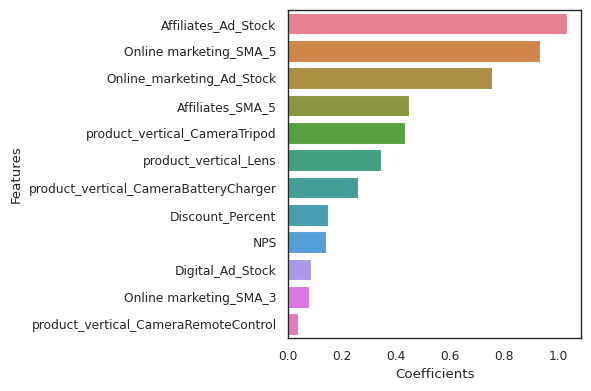

In [304]:
# Slightly alter the figure size to make it more horizontal.
plt.figure( dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.barplot(y='Features', x='Coefficients', palette='husl', data=cameraaccessory_lr_coef_df, estimator=np.sum)
# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

### **Simple Linear Regression for GamingAccessory**

In [305]:
gamingaccessory_mul_model = LinearRegression().fit(gamingaccessory_mul_df_X_train, gamingaccessory_mul_df_y_train)

gamingaccessory_mul_rfe = RFECV(gamingaccessory_mul_model, cv=5,scoring='neg_mean_squared_error')             # running RFE
gamingaccessory_mul_rfe = gamingaccessory_mul_rfe.fit(gamingaccessory_mul_df_X_train, gamingaccessory_mul_df_y_train)

In [306]:
gamingaccessory_mul_rfe.n_features_

2

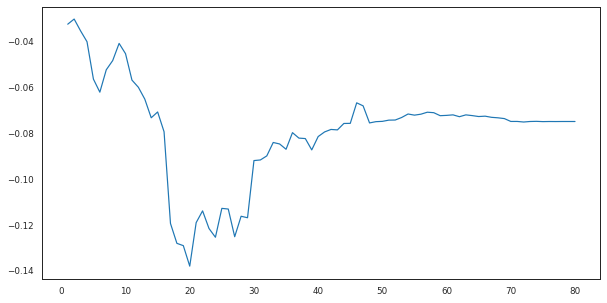

In [307]:
plt.figure(figsize=[10, 5])
plt.plot(range(1, gamingaccessory_mul_df_X_train.shape[1]+1), gamingaccessory_mul_rfe.grid_scores_)
plt.show();

In [308]:
gamingaccessory_mul_model = LinearRegression().fit(gamingaccessory_mul_df_X_train, gamingaccessory_mul_df_y_train)

gamingaccessory_mul_rfe = RFE(gamingaccessory_mul_model, 8)             # running RFE
gamingaccessory_mul_rfe = gamingaccessory_mul_rfe.fit(gamingaccessory_mul_df_X_train, gamingaccessory_mul_df_y_train)

col = list(gamingaccessory_mul_df_X_train.columns[gamingaccessory_mul_rfe.support_])

gamingaccessory_mul_model = LinearRegression().fit(gamingaccessory_mul_df_X_train[col], gamingaccessory_mul_df_y_train)

gamingaccessory_mul_df_y_test_pred = gamingaccessory_mul_model.predict(gamingaccessory_mul_df_X_test[col])

print('R2 Score: {}'.format(r2_score(gamingaccessory_mul_df_y_test, gamingaccessory_mul_df_y_test_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(gamingaccessory_mul_df_y_test, gamingaccessory_mul_df_y_test_pred)))

R2 Score: 0.931944025797893
Mean Squared Error: 0.12035755616614857


#### **Simple Linear Regression for GamingAccessory with K-Fold Cross validation**

In [309]:
gamingaccessory_mul_df_cv = gamingaccessory_mul_df.copy()

**Feature Scaling**

In [310]:
scaler = StandardScaler()
gamingaccessory_mul_df_cv[gamingaccessory_mul_df_cv.columns]=scaler.fit_transform(gamingaccessory_mul_df_cv[gamingaccessory_mul_df_cv.columns])

In [311]:
gamingaccessory_mul_df_cv_X = gamingaccessory_mul_df_cv.drop("gmv",axis=1)
gamingaccessory_mul_df_cv_y = gamingaccessory_mul_df_cv.gmv

**Model Building**

In [312]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn import metrics

gamingaccessory_mul_model_cv = LinearRegression().fit(gamingaccessory_mul_df_cv_X[col], gamingaccessory_mul_df_cv_y)

gamingaccessory_mul_predictions_cv = cross_val_predict(gamingaccessory_mul_model_cv, gamingaccessory_mul_df_cv_X[col], gamingaccessory_mul_df_cv_y, cv=5)
accuracy = metrics.r2_score(gamingaccessory_mul_df_cv_y, gamingaccessory_mul_predictions_cv)
print("Cross-Predicted Accuracy:", accuracy)
print('Mean Squared Error: {}'.format(mean_squared_error(gamingaccessory_mul_df_cv_y, gamingaccessory_mul_predictions_cv)))

Cross-Predicted Accuracy: 0.8324980004864452
Mean Squared Error: 0.16750199951355477


#### **Determining Feature Importance for gamingaccessory from model without cv**

In [313]:
# linear regression model parameters
#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 
pd.set_option('display.precision',1)

gamingaccessory_mul_model = LinearRegression().fit(gamingaccessory_mul_df_X_train[col], gamingaccessory_mul_df_y_train)
gamingaccessory_lr_model_parameters = list(gamingaccessory_mul_model.coef_)
#cameraaccessory_lr_model_parameters.insert(0, cameraaccessory_model.intercept_)
gamingaccessory_lr_model_parameters = [abs(round(x, 3)) for x in gamingaccessory_lr_model_parameters]
gamingaccessory_lr_coef = list(zip(col, gamingaccessory_lr_model_parameters))
gamingaccessory_lr_coef

[('sla', 0.135),
 ('product_vertical_GamingAccessoryKit', 0.399),
 ('product_vertical_GamingMouse', 0.537),
 ('Total_Investment_Ad_Stock', 0.205),
 ('Digital_Ad_Stock', 0.083),
 ('Content Marketing_EMA_7', 0.572),
 ('Content_Marketing_Ad_Stock', 0.461),
 ('NPS', 0.132)]

In [314]:
gamingaccessory_lr_coef_df = pd.DataFrame(gamingaccessory_lr_coef)
col_rename = {0:'Features',1: 'Coefficients'}
gamingaccessory_lr_coef_df = gamingaccessory_lr_coef_df.rename(columns=col_rename)
gamingaccessory_lr_coef_df = gamingaccessory_lr_coef_df.loc[gamingaccessory_lr_coef_df['Coefficients']!=0.0]
gamingaccessory_lr_coef_df = gamingaccessory_lr_coef_df.sort_values(by=['Coefficients'], ascending = False)
gamingaccessory_lr_coef_df

,Features,Coefficients
5,Content Marketing_EMA_7,0.572
2,product_vertical_GamingMouse,0.537
6,Content_Marketing_Ad_Stock,0.461
1,product_vertical_GamingAccessoryKit,0.399
3,Total_Investment_Ad_Stock,0.205
0,sla,0.135
7,NPS,0.132
4,Digital_Ad_Stock,0.083


#### **Plotting the Features in descending order of Importance for gaming accessory**

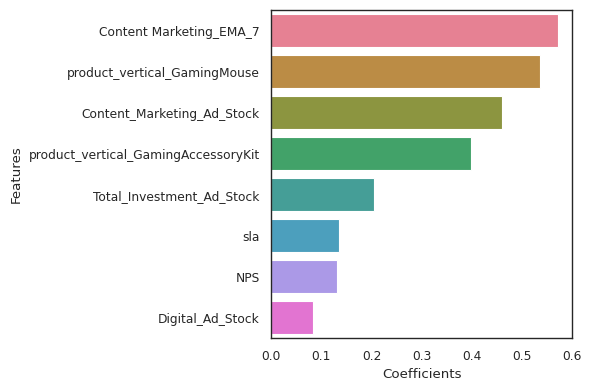

In [315]:
# Slightly alter the figure size to make it more horizontal.
plt.figure( dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.barplot(y='Features', x='Coefficients', palette='husl', data=gamingaccessory_lr_coef_df, estimator=np.sum)
# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

### **Simple Linear Regression for HomeAudio**

In [316]:
homeaudio_mul_model = LinearRegression().fit(homeaudio_mul_df_X_train, homeaudio_mul_df_y_train)

homeaudio_mul_rfe = RFECV(homeaudio_mul_model, cv=5,scoring='neg_mean_squared_error')             # running RFE
homeaudio_mul_rfe = homeaudio_mul_rfe.fit(homeaudio_mul_df_X_train, homeaudio_mul_df_y_train)

In [317]:
homeaudio_mul_rfe.n_features_

3

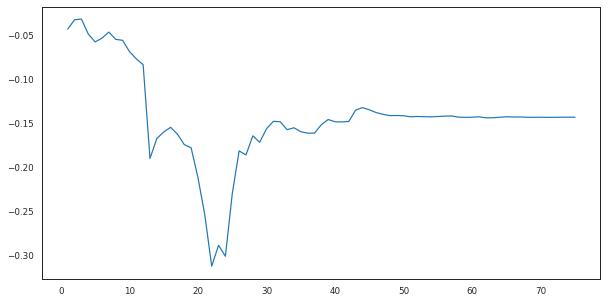

In [318]:
plt.figure(figsize=[10, 5])
plt.plot(range(1, homeaudio_mul_df_X_train.shape[1]+1), homeaudio_mul_rfe.grid_scores_)
plt.show();

In [319]:
homeaudio_mul_model = LinearRegression().fit(homeaudio_mul_df_X_train, homeaudio_mul_df_y_train)

homeaudio_mul_rfe = RFE(homeaudio_mul_model, 6)             # running RFE
homeaudio_mul_rfe = homeaudio_mul_rfe.fit(homeaudio_mul_df_X_train, homeaudio_mul_df_y_train)

col = list(homeaudio_mul_df_X_train.columns[homeaudio_mul_rfe.support_])

homeaudio_mul_model = LinearRegression().fit(homeaudio_mul_df_X_train[col], homeaudio_mul_df_y_train)

homeaudio_mul_df_y_test_pred = homeaudio_mul_model.predict(homeaudio_mul_df_X_test[col])

print('R2 Score: {}'.format(r2_score(homeaudio_mul_df_y_test, homeaudio_mul_df_y_test_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(homeaudio_mul_df_y_test, homeaudio_mul_df_y_test_pred)))

R2 Score: 0.9803698426002192
Mean Squared Error: 0.5837231866373871


#### **Simple Linear Regression for Homeaudio with K-Fold Cross validation**

In [320]:
homeaudio_mul_df_cv = homeaudio_mul_df.copy()

**Feature Scaling**

In [321]:
scaler = StandardScaler()
homeaudio_mul_df_cv[homeaudio_mul_df_cv.columns]=scaler.fit_transform(homeaudio_mul_df_cv[homeaudio_mul_df_cv.columns])

In [322]:
homeaudio_mul_df_cv_X = homeaudio_mul_df_cv.drop("gmv",axis=1)
homeaudio_mul_df_cv_y = homeaudio_mul_df_cv.gmv

**Model Building**

In [323]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn import metrics

homeaudio_mul_model_cv = LinearRegression().fit(homeaudio_mul_df_cv_X[col], homeaudio_mul_df_cv_y)

homeaudio_mul_predictions_cv = cross_val_predict(homeaudio_mul_model_cv, homeaudio_mul_df_cv_X[col], homeaudio_mul_df_cv_y, cv=5)
accuracy = metrics.r2_score(homeaudio_mul_df_cv_y, homeaudio_mul_predictions_cv)
print("Cross-Predicted Accuracy:", accuracy)
print('Mean Squared Error: {}'.format(mean_squared_error(homeaudio_mul_df_cv_y, homeaudio_mul_predictions_cv)))

Cross-Predicted Accuracy: 0.9747022021387033
Mean Squared Error: 0.025297797861296767


#### **Determining Feature Importance for homeaudio from model without cv**

In [324]:
# linear regression model parameters
#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 
pd.set_option('display.precision',1)

homeaudio_mul_model = LinearRegression().fit(homeaudio_mul_df_X_train[col], homeaudio_mul_df_y_train)
homeaudio_lr_model_parameters = list(homeaudio_mul_model.coef_)
#cameraaccessory_lr_model_parameters.insert(0, cameraaccessory_model.intercept_)
homeaudio_lr_model_parameters = [abs(round(x, 3)) for x in homeaudio_lr_model_parameters]
homeaudio_lr_coef = list(zip(col, homeaudio_lr_model_parameters))
homeaudio_lr_coef

[('is_cod', 0.121),
 ('is_mass_market', 0.372),
 ('product_vertical_FMRadio', 0.244),
 ('product_vertical_HomeAudioSpeaker', 1.261),
 ('Content_Marketing_Ad_Stock', 0.265),
 ('Affiliates', 0.276)]

In [325]:
homeaudio_lr_coef_df = pd.DataFrame(homeaudio_lr_coef)
col_rename = {0:'Features',1: 'Coefficients'}
homeaudio_lr_coef_df = homeaudio_lr_coef_df.rename(columns=col_rename)
homeaudio_lr_coef_df = homeaudio_lr_coef_df.loc[homeaudio_lr_coef_df['Coefficients']!=0.0]
homeaudio_lr_coef_df = homeaudio_lr_coef_df.sort_values(by=['Coefficients'], ascending = False)
homeaudio_lr_coef_df

,Features,Coefficients
3,product_vertical_HomeAudioSpeaker,1.261
1,is_mass_market,0.372
5,Affiliates,0.276
4,Content_Marketing_Ad_Stock,0.265
2,product_vertical_FMRadio,0.244
0,is_cod,0.121


#### **Plotting the Features in descending order of Importance for homeaudio**

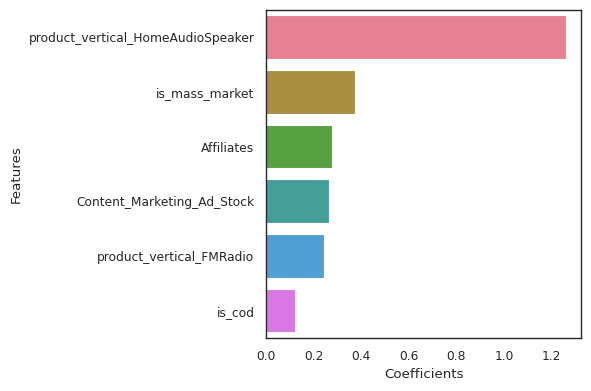

In [326]:
# Slightly alter the figure size to make it more horizontal.
plt.figure( dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.barplot(y='Features', x='Coefficients', palette='husl', data=homeaudio_lr_coef_df, estimator=np.sum)
# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

## **Koyck Model**

**The Additive and Multiplicative Linear Models that we have built till now can capture the current effect of the KPIs. However, if we want to capture the carry-over effect, we would want to model the current revenue figures based on the past figures of the KPIs.**

**The Koyck tells us that the current revenue generated is not just influenced by the different independent attributes, but also because of the revenue generated over the last periods. ie. Current revenue(Yt) is also dependent on the past revenue values(Yt-1).**

Yt = α + β1X1 + β2X2 + β3X3 + β4X4 + β5X5 + ϵ

Yt = α + µYt-1 + β1X1 + β2X2 + β3X3 + β4X4 + β5X5 + ϵ -- (sale at time t is dependent on sale at time t-1)

If X1 is the advertising effect, β1 is the current effect of advertising, carry over effect of advertising is β1*µ/(1-µ).

Therefore the total effect of advertising = Current effect + Carry over effect

                                        = β1 + β1 * µ/(1-µ) 

                                        = β1/(1-µ)

**Data Preparation for Modelling**

In [327]:
# Making copy of dataframes from the original ones
cameraaccessory_koy_df = cameraaccessory_df_weekly.copy()
gamingaccessory_koy_df = gamingaccessory_df_weekly.copy()
homeaudio_koy_df = homeaudio_df_weekly.copy()

**Creating a new variable which is the Lag of 1 week of the dependent variable (GMV)**

In [328]:
GMV_Lag = ['gmv']

In [329]:
def lag_variables(df,var,n):
    for i in var:
        loc_index = df.columns.get_loc(i) + 1
        df.insert(loc=loc_index,column= i+'_lag'+np.str(n),value=df[i].shift(n))
    return df

In [330]:
cameraaccessory_koy_df = lag_variables(cameraaccessory_koy_df,GMV_Lag,1) 
gamingaccessory_koy_df = lag_variables(gamingaccessory_koy_df,GMV_Lag,1) 
homeaudio_koy_df = lag_variables(homeaudio_koy_df,GMV_Lag,1) 

In [331]:
# Imputing all null values with 0
cameraaccessory_koy_df.fillna(value=0, inplace=True)
gamingaccessory_koy_df.fillna(value=0, inplace=True)
homeaudio_koy_df.fillna(value=0, inplace=True)

**Dropping Week column as it is just a row identifier and not add anything as information to the model**



In [332]:
cameraaccessory_koy_df = cameraaccessory_koy_df.drop('Week', axis=1)
gamingaccessory_koy_df = gamingaccessory_koy_df.drop('Week', axis=1)
homeaudio_koy_df = homeaudio_koy_df.drop('Week', axis=1)

**Train Test split**

In [333]:
cameraaccessory_koy_df_train, cameraaccessory_koy_df_test = train_test_split(cameraaccessory_koy_df, train_size=0.7, test_size=0.3, random_state=100)
gamingaccessory_koy_df_train, gamingaccessory_koy_df_test = train_test_split(gamingaccessory_koy_df, train_size=0.7, test_size=0.3, random_state=100)
homeaudio_koy_df_train, homeaudio_koy_df_test = train_test_split(homeaudio_koy_df, train_size=0.7, test_size=0.3, random_state=100)

**Feature Scaling**

In [334]:
cameraaccessory_cols = list(cameraaccessory_koy_df.columns)
gamingaccessory_cols = list(gamingaccessory_koy_df.columns)
homeaudio_cols = list(homeaudio_koy_df.columns)

In [335]:
scaler = StandardScaler()
cameraaccessory_koy_df_train[cameraaccessory_cols] = scaler.fit_transform(cameraaccessory_koy_df_train[cameraaccessory_cols])
cameraaccessory_koy_df_test[cameraaccessory_cols] = scaler.transform(cameraaccessory_koy_df_test[cameraaccessory_cols])
gamingaccessory_koy_df_train[gamingaccessory_cols] = scaler.fit_transform(gamingaccessory_koy_df_train[gamingaccessory_cols])
gamingaccessory_koy_df_test[gamingaccessory_cols] = scaler.transform(gamingaccessory_koy_df_test[gamingaccessory_cols])
homeaudio_koy_df_train[homeaudio_cols] = scaler.fit_transform(homeaudio_koy_df_train[homeaudio_cols])
homeaudio_koy_df_test[homeaudio_cols] = scaler.transform(homeaudio_koy_df_test[homeaudio_cols])

In [336]:
cameraaccessory_koy_df_X_train = cameraaccessory_koy_df_train.drop("gmv",axis=1)
cameraaccessory_koy_df_y_train = cameraaccessory_koy_df_train.gmv
cameraaccessory_koy_df_X_test = cameraaccessory_koy_df_test.drop("gmv",axis=1)
cameraaccessory_koy_df_y_test = cameraaccessory_koy_df_test.gmv

gamingaccessory_koy_df_X_train = gamingaccessory_koy_df_train.drop("gmv",axis=1)
gamingaccessory_koy_df_y_train = gamingaccessory_koy_df_train.gmv
gamingaccessory_koy_df_X_test = gamingaccessory_koy_df_test.drop("gmv",axis=1)
gamingaccessory_koy_df_y_test = gamingaccessory_koy_df_test.gmv

homeaudio_koy_df_X_train = homeaudio_koy_df_train.drop("gmv",axis=1)
homeaudio_koy_df_y_train = homeaudio_koy_df_train.gmv
homeaudio_koy_df_X_test = homeaudio_koy_df_test.drop("gmv",axis=1)
homeaudio_koy_df_y_test = homeaudio_koy_df_test.gmv

In [337]:
cameraaccessory_koy_df_X_train.head()

,gmv_lag1,Discount_Percent,sla,product_procurement_sla,is_cod,is_mass_market,product_vertical_CameraAccessory,product_vertical_CameraBag,product_vertical_CameraBattery,product_vertical_CameraBatteryCharger,product_vertical_CameraFilmRolls,product_vertical_CameraMount,product_vertical_CameraRemoteControl,product_vertical_CameraTripod,product_vertical_Filter,product_vertical_Flash,product_vertical_Lens,product_vertical_Others,product_vertical_Strap,product_vertical_Telescope,Total Investment,Total Investment_SMA_3,Total Investment_SMA_5,Total Investment_EMA_7,Total_Investment_Ad_Stock,TV,TV_SMA_3,TV_SMA_5,TV_EMA_7,TV_Ad_Stock,Digital,Digital_SMA_3,Digital_SMA_5,Digital_EMA_7,Digital_Ad_Stock,Sponsorship,Sponsorship_SMA_3,Sponsorship_SMA_5,Sponsorship_EMA_7,Sponsorship_Ad_Stock,...,Content_Marketing_Ad_Stock,Online marketing,Online marketing_SMA_3,Online marketing_SMA_5,Online marketing_EMA_7,Online_marketing_Ad_Stock,Affiliates,Affiliates_SMA_3,Affiliates_SMA_5,Affiliates_EMA_7,Affiliates_Ad_Stock,SEM,SEM_SMA_3,SEM_SMA_5,SEM_EMA_7,SEM_Ad_Stock,Radio,Radio_SMA_3,Radio_SMA_5,Radio_EMA_7,Radio_Ad_Stock,Other,Other_SMA_3,Other_SMA_5,Other_EMA_7,Other_Ad_Stock,Sale_Dates,NPS,Stock Index,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm),payday_week,holiday_week
48,0.016,1.668,-0.708,-1.389,0.980,0.828,0.201,0.203,-0.360,0.441,2.301,-1.419,-0.433,-0.909,-0.191,1.861,0.527,1.127,0.228,1.680,-0.767,-0.381,-0.126,-0.259,-0.428,-0.841,-0.932,-0.949,-0.660,-0.889,-0.445,-0.498,-0.523,-0.731,-0.577,-0.395,-0.212,-0.086,-0.182,-0.245,...,-0.531,-1.092,-0.200,0.282,0.132,-0.228,-1.030,-0.252,0.157,0.087,-0.259,-0.620,-0.432,-0.288,-0.526,-0.505,-0.455,0.154,0.551,0.372,0.127,-0.417,-0.199,-0.056,-0.109,-0.237,-0.560,0.375,0.392,1.356,0.567,0.862,-0.828,0.730,-0.841,-0.246,-0.886,-0.229,-0.866,-0.408
44,0.398,1.567,-0.751,-1.047,1.046,0.882,0.110,0.842,0.060,1.045,1.039,-0.668,-0.391,-0.083,-0.043,1.407,0.333,0.928,1.704,0.998,-0.002,-0.053,-0.112,0.016,-0.036,-0.986,-0.515,0.022,0.140,-0.381,-0.642,-0.609,-0.582,-0.776,-0.693,-0.170,-0.153,-0.164,-0.141,-0.161,...,-0.264,0.878,0.685,0.474,0.639,0.693,0.668,0.584,0.493,0.625,0.604,-0.262,-0.303,-0.347,-0.466,-0.355,1.150,0.628,0.143,0.577,0.702,0.288,0.011,-0.239,0.184,0.078,-0.560,-0.487,0.854,0.310,-0.203,-0.046,-0.166,-0.705,0.497,-0.246,0.450,-0.229,1.155,-0.408
37,-0.154,0.106,-0.637,-0.821,0.168,0.384,-1.168,-0.304,1.556,1.827,0.141,0.918,-0.224,-0.343,-0.435,0.539,-0.567,0.730,0.892,0.885,0.496,0.603,0.433,0.456,0.510,2.296,2.475,1.876,1.850,2.188,-0.266,-0.211,-0.138,-0.328,-0.255,0.214,0.333,0.146,0.019,0.185,...,-0.433,0.212,0.260,0.373,0.512,0.345,0.417,0.449,0.533,0.663,0.526,-0.463,-0.428,-0.384,-0.536,-0.486,0.814,0.756,0.467,0.876,0.753,1.839,1.832,1.390,1.799,1.800,-0.560,-0.027,-2.042,-0.241,-0.914,-0.871,0.835,-0.739,3.190,-0.246,3.137,-0.229,-0.866,2.449
17,0.196,-0.068,-0.151,1.000,0.530,0.237,-0.529,-0.075,-0.258,-0.486,-0.523,0.835,0.635,0.301,0.149,0.559,0.012,0.532,-0.215,-1.161,-0.571,1.210,1.791,1.397,1.061,0.252,0.785,0.951,0.681,0.711,-0.487,1.706,2.700,2.050,1.543,-0.832,1.011,1.635,1.404,0.893,...,1.359,0.439,0.816,0.921,0.679,0.763,0.674,0.742,0.761,0.575,0.717,-0.439,1.687,2.601,2.010,1.528,-0.455,-0.558,-0.622,-0.707,-0.616,-0.417,-0.513,-0.581,-0.673,-0.572,1.221,-0.570,0.922,0.035,0.093,0.078,-0.329,-0.739,-0.300,-0.246,-0.345,-0.229,-0.866,-0.408
7,-2.138,-1.643,4.888,-3.028,-2.087,-2.233,-3.815,-2.306,-2.865,-2.227,-1.221,-1.586,-2.338,-1.399,-1.767,-1.158,-1.959,-2.440,-2.355,-1.956,-1.655,-1.661,-1.615,-1.932,-1.800,-1.550,-1.621,-1.599,-1.783,-1.693,-0.499,-0.464,-0.363,-0.523,-0.501,-1.359,-1.340,-1.310,-1.615,-1.474,...,-0.946,-2.129,-2.081,-2.002,-2.081,-2.132,-2.231,-2.132,-1.999,-2.079,-2.159,-0.778,-0.769,-0.720,-0.936,-0.847,-0.455,-0.558,-0.622,-0.707,-0.616,-0.417,-0.513,-0.581,-0.673,-0.572,2.111,2.919,0.555,0.695,1.160,0.810,-0.802,0.610,-0.841,-0.246,-0.886,-0.229,-0.866

### **Simple Linear Regression Model for CameraAccessory**

In [338]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

cameraaccessory_koy_model = LinearRegression().fit(cameraaccessory_koy_df_X_train, cameraaccessory_koy_df_y_train)

cameraaccessory_koy_rfe = RFECV(cameraaccessory_koy_model,cv=5,scoring='neg_mean_squared_error')             # running RFE
cameraaccessory_koy_rfe = cameraaccessory_koy_rfe.fit(cameraaccessory_koy_df_X_train, cameraaccessory_koy_df_y_train)

In [339]:
cameraaccessory_koy_rfe.n_features_

34

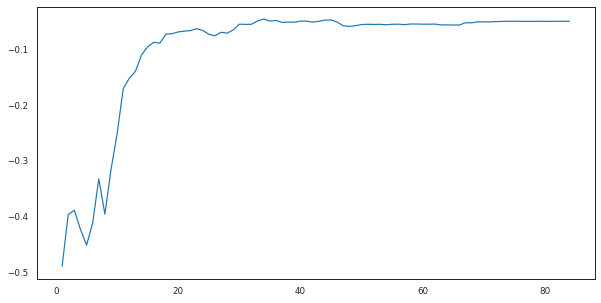

In [340]:
plt.figure(figsize=[10, 5])
plt.plot(range(1, cameraaccessory_koy_df_X_train.shape[1]+1), cameraaccessory_koy_rfe.grid_scores_)
plt.show();

In [341]:
cameraaccessory_koy_model = LinearRegression().fit(cameraaccessory_koy_df_X_train, cameraaccessory_koy_df_y_train)

cameraaccessory_koy_rfe = RFE(cameraaccessory_koy_model,12)             # 12 seems ideal number of features
cameraaccessory_koy_rfe = cameraaccessory_koy_rfe.fit(cameraaccessory_koy_df_X_train, cameraaccessory_koy_df_y_train)

col = list(cameraaccessory_koy_df_X_train.columns[cameraaccessory_koy_rfe.support_])

cameraaccessory_koy_model = LinearRegression().fit(cameraaccessory_koy_df_X_train[col], cameraaccessory_koy_df_y_train)

cameraaccessory_koy_df_y_test_pred = cameraaccessory_koy_model.predict(cameraaccessory_koy_df_X_test[col])

print('R2 Score: {}'.format(r2_score(cameraaccessory_koy_df_y_test, cameraaccessory_koy_df_y_test_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(cameraaccessory_koy_df_y_test, cameraaccessory_koy_df_y_test_pred)))

R2 Score: 0.797392291088171
Mean Squared Error: 0.21365873443970718


#### **Simple Linear Regression for CameraAccessory with K-Fold Cross validation**

In [342]:
cameraaccessory_koy_df_cv = cameraaccessory_koy_df.copy()

**Feature Scaling**

In [343]:
scaler = StandardScaler()
cameraaccessory_koy_df_cv[cameraaccessory_koy_df_cv.columns]=scaler.fit_transform(cameraaccessory_koy_df_cv[cameraaccessory_koy_df_cv.columns])

In [344]:
cameraaccessory_koy_df_cv_X = cameraaccessory_koy_df_cv.drop("gmv",axis=1)
cameraaccessory_koy_df_cv_y = cameraaccessory_koy_df_cv.gmv

**Model Building**

In [345]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn import metrics

cameraaccessory_koy_model_cv = LinearRegression().fit(cameraaccessory_koy_df_cv_X[col], cameraaccessory_koy_df_cv_y)

cameraaccessory_koy_predictions_cv = cross_val_predict(cameraaccessory_koy_model_cv, cameraaccessory_koy_df_cv_X[col], cameraaccessory_koy_df_cv_y, cv=5)
accuracy = metrics.r2_score(cameraaccessory_koy_df_cv_y, cameraaccessory_koy_predictions_cv)
print("Cross-Predicted Accuracy:", accuracy)
print('Mean Squared Error: {}'.format(mean_squared_error(cameraaccessory_koy_df_cv_y, cameraaccessory_koy_predictions_cv)))

Cross-Predicted Accuracy: 0.909187936031901
Mean Squared Error: 0.09081206396809899


#### **Determining Feature Importance for cameraaccessory from model without cv**

In [346]:
# linear regression model parameters
#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 
pd.set_option('display.precision',1)

cameraaccessory_koy_model = LinearRegression().fit(cameraaccessory_koy_df_X_train[col], cameraaccessory_koy_df_y_train)
cameraaccessory_lr_model_parameters = list(cameraaccessory_koy_model.coef_)
#cameraaccessory_lr_model_parameters.insert(0, cameraaccessory_model.intercept_)
cameraaccessory_lr_model_parameters = [abs(round(x, 3)) for x in cameraaccessory_lr_model_parameters]
cameraaccessory_lr_coef = list(zip(col, cameraaccessory_lr_model_parameters))
cameraaccessory_lr_coef

[('product_vertical_CameraBattery', 0.149),
 ('product_vertical_CameraRemoteControl', 0.208),
 ('product_vertical_Lens', 0.486),
 ('product_vertical_Others', 0.174),
 ('Online marketing_SMA_5', 1.159),
 ('Online_marketing_Ad_Stock', 0.585),
 ('Affiliates_SMA_5', 0.835),
 ('Other_SMA_3', 0.096),
 ('Other_SMA_5', 0.178),
 ('Sale_Dates', 0.146),
 ('Max Temp', 0.124),
 ('Cool Deg Days', 0.183)]

In [347]:
cameraaccessory_lr_coef_df = pd.DataFrame(cameraaccessory_lr_coef)
col_rename = {0:'Features',1: 'Coefficients'}
cameraaccessory_lr_coef_df = cameraaccessory_lr_coef_df.rename(columns=col_rename)
cameraaccessory_lr_coef_df = cameraaccessory_lr_coef_df.loc[cameraaccessory_lr_coef_df['Coefficients']!=0.0]
cameraaccessory_lr_coef_df = cameraaccessory_lr_coef_df.sort_values(by=['Coefficients'], ascending = False)
cameraaccessory_lr_coef_df

,Features,Coefficients
4,Online marketing_SMA_5,1.159
6,Affiliates_SMA_5,0.835
5,Online_marketing_Ad_Stock,0.585
2,product_vertical_Lens,0.486
1,product_vertical_CameraRemoteControl,0.208
11,Cool Deg Days,0.183
8,Other_SMA_5,0.178
3,product_vertical_Others,0.174
0,product_vertical_CameraBattery,0.149
9,Sale_Dates,0.146


#### **Plotting the Features in descending order of Importance for cameraaccessory**

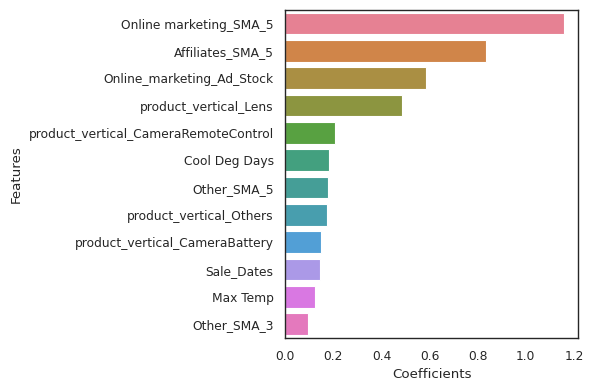

In [348]:
# Slightly alter the figure size to make it more horizontal.
plt.figure( dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.barplot(y='Features', x='Coefficients', palette='husl', data=cameraaccessory_lr_coef_df, estimator=np.sum)
# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

### **Simple Linear Regression for GamingAccessory**

In [349]:
gamingaccessory_koy_model = LinearRegression().fit(gamingaccessory_koy_df_X_train, gamingaccessory_koy_df_y_train)

gamingaccessory_koy_rfe = RFECV(gamingaccessory_koy_model, cv=5,scoring='neg_mean_squared_error')             # running RFE
gamingaccessory_koy_rfe = gamingaccessory_koy_rfe.fit(gamingaccessory_koy_df_X_train, gamingaccessory_koy_df_y_train)

In [350]:
gamingaccessory_koy_rfe.n_features_

32

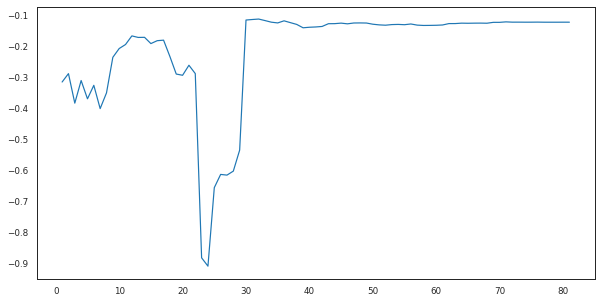

In [351]:
plt.figure(figsize=[10, 5])
plt.plot(range(1, gamingaccessory_koy_df_X_train.shape[1]+1), gamingaccessory_koy_rfe.grid_scores_)
plt.show();

In [352]:
gamingaccessory_koy_model = LinearRegression().fit(gamingaccessory_koy_df_X_train, gamingaccessory_koy_df_y_train)

gamingaccessory_koy_rfe = RFE(gamingaccessory_koy_model, 10)             # running RFE
gamingaccessory_koy_rfe = gamingaccessory_koy_rfe.fit(gamingaccessory_koy_df_X_train, gamingaccessory_koy_df_y_train)

col = list(gamingaccessory_koy_df_X_train.columns[gamingaccessory_koy_rfe.support_])

gamingaccessory_koy_model = LinearRegression().fit(gamingaccessory_koy_df_X_train[col], gamingaccessory_koy_df_y_train)

gamingaccessory_koy_df_y_test_pred = gamingaccessory_koy_model.predict(gamingaccessory_koy_df_X_test[col])

print('R2 Score: {}'.format(r2_score(gamingaccessory_koy_df_y_test, gamingaccessory_koy_df_y_test_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(gamingaccessory_koy_df_y_test, gamingaccessory_koy_df_y_test_pred)))

R2 Score: 0.9543391175741645
Mean Squared Error: 0.059113217930759084


#### **Simple Linear Regression for GamingAccessory with K-Fold Cross validation**

In [353]:
gamingaccessory_koy_df_cv = gamingaccessory_koy_df.copy()

**Feature Scaling**

In [354]:
scaler = StandardScaler()
gamingaccessory_koy_df_cv[gamingaccessory_koy_df_cv.columns]=scaler.fit_transform(gamingaccessory_koy_df_cv[gamingaccessory_koy_df_cv.columns])

In [355]:
gamingaccessory_koy_df_cv_X = gamingaccessory_koy_df_cv.drop("gmv",axis=1)
gamingaccessory_koy_df_cv_y = gamingaccessory_koy_df_cv.gmv

**Model Building**

In [356]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn import metrics

gamingaccessory_koy_model_cv = LinearRegression().fit(gamingaccessory_koy_df_cv_X[col], gamingaccessory_koy_df_cv_y)

gamingaccessory_koy_predictions_cv = cross_val_predict(gamingaccessory_koy_model_cv, gamingaccessory_koy_df_cv_X[col], gamingaccessory_koy_df_cv_y, cv=5)
accuracy = metrics.r2_score(gamingaccessory_koy_df_cv_y, gamingaccessory_koy_predictions_cv)
print("Cross-Predicted Accuracy:", accuracy)
print('Mean Squared Error: {}'.format(mean_squared_error(gamingaccessory_koy_df_cv_y, gamingaccessory_koy_predictions_cv)))

Cross-Predicted Accuracy: 0.9354485975440635
Mean Squared Error: 0.0645514024559365


#### **Determining Feature Importance for gamingaccessory from model without cv**

In [357]:
# linear regression model parameters
#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 
pd.set_option('display.precision',1)

gamingaccessory_koy_model = LinearRegression().fit(gamingaccessory_koy_df_X_train[col], gamingaccessory_koy_df_y_train)
gamingaccessory_lr_model_parameters = list(gamingaccessory_koy_model.coef_)
#cameraaccessory_lr_model_parameters.insert(0, cameraaccessory_model.intercept_)
gamingaccessory_lr_model_parameters = [abs(round(x, 3)) for x in gamingaccessory_lr_model_parameters]
gamingaccessory_lr_coef = list(zip(col, gamingaccessory_lr_model_parameters))
gamingaccessory_lr_coef

[('product_vertical_GamingAccessoryKit', 0.455),
 ('product_vertical_GamingHeadset', 0.324),
 ('product_vertical_GamingKeyboard', 0.373),
 ('TV_SMA_3', 0.052),
 ('Digital_Ad_Stock', 0.964),
 ('Online marketing_EMA_7', 0.442),
 ('Affiliates_EMA_7', 0.568),
 ('SEM_SMA_3', 0.884),
 ('Other_SMA_3', 0.178),
 ('Other_EMA_7', 0.226)]

In [358]:
gamingaccessory_lr_coef_df = pd.DataFrame(gamingaccessory_lr_coef)
col_rename = {0:'Features',1: 'Coefficients'}
gamingaccessory_lr_coef_df = gamingaccessory_lr_coef_df.rename(columns=col_rename)
gamingaccessory_lr_coef_df = gamingaccessory_lr_coef_df.loc[gamingaccessory_lr_coef_df['Coefficients']!=0.0]
gamingaccessory_lr_coef_df = gamingaccessory_lr_coef_df.sort_values(by=['Coefficients'], ascending = False)
gamingaccessory_lr_coef_df

,Features,Coefficients
4,Digital_Ad_Stock,0.964
7,SEM_SMA_3,0.884
6,Affiliates_EMA_7,0.568
0,product_vertical_GamingAccessoryKit,0.455
5,Online marketing_EMA_7,0.442
2,product_vertical_GamingKeyboard,0.373
1,product_vertical_GamingHeadset,0.324
9,Other_EMA_7,0.226
8,Other_SMA_3,0.178
3,TV_SMA_3,0.052


#### **Plotting the Features in descending order of Importance for gaming accessory**

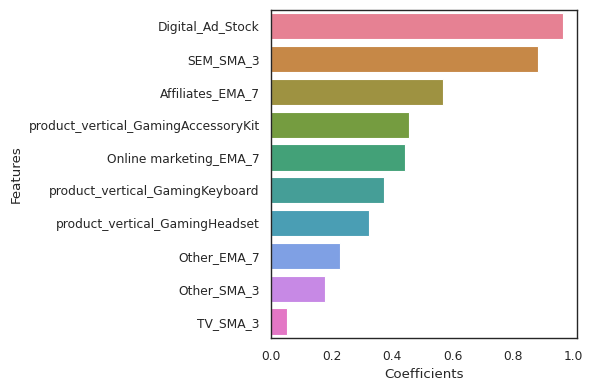

In [359]:
# Slightly alter the figure size to make it more horizontal.
plt.figure( dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.barplot(y='Features', x='Coefficients', palette='husl', data=gamingaccessory_lr_coef_df, estimator=np.sum)
# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

### **Simple Linear Regression for HomeAudio**

In [360]:
homeaudio_koy_model = LinearRegression().fit(homeaudio_koy_df_X_train, homeaudio_koy_df_y_train)

homeaudio_koy_rfe = RFECV(homeaudio_koy_model, cv=5,scoring='neg_mean_squared_error')             # running RFE
homeaudio_koy_rfe = homeaudio_koy_rfe.fit(homeaudio_koy_df_X_train, homeaudio_koy_df_y_train)

In [361]:
homeaudio_koy_rfe.n_features_

13

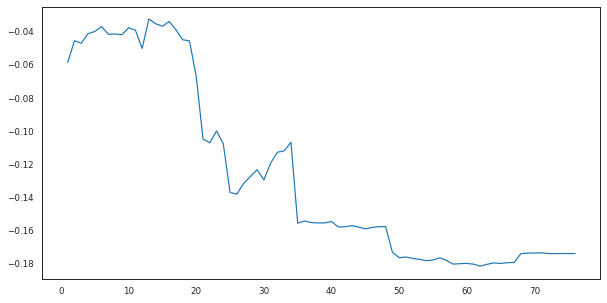

In [362]:
plt.figure(figsize=[10, 5])
plt.plot(range(1, homeaudio_koy_df_X_train.shape[1]+1), homeaudio_koy_rfe.grid_scores_)
plt.show();

In [363]:
homeaudio_koy_model = LinearRegression().fit(homeaudio_koy_df_X_train, homeaudio_koy_df_y_train)

homeaudio_koy_rfe = RFE(homeaudio_koy_model, 6)             # running RFE
homeaudio_koy_rfe = homeaudio_koy_rfe.fit(homeaudio_koy_df_X_train, homeaudio_koy_df_y_train)

col = list(homeaudio_koy_df_X_train.columns[homeaudio_koy_rfe.support_])

homeaudio_koy_model = LinearRegression().fit(homeaudio_koy_df_X_train[col], homeaudio_koy_df_y_train)

homeaudio_koy_df_y_test_pred = homeaudio_koy_model.predict(homeaudio_koy_df_X_test[col])

print('R2 Score: {}'.format(r2_score(homeaudio_koy_df_y_test, homeaudio_koy_df_y_test_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(homeaudio_koy_df_y_test, homeaudio_koy_df_y_test_pred)))

R2 Score: 0.964223708659316
Mean Squared Error: 0.017268850574214147


#### **Simple Linear Regression for Homeaudio with K-Fold Cross validation**

In [364]:
homeaudio_koy_df_cv = homeaudio_koy_df.copy()

**Feature Scaling**

In [365]:
scaler = StandardScaler()
homeaudio_koy_df_cv[homeaudio_koy_df_cv.columns]=scaler.fit_transform(homeaudio_koy_df_cv[homeaudio_koy_df_cv.columns])

In [366]:
homeaudio_koy_df_cv_X = homeaudio_koy_df_cv.drop("gmv",axis=1)
homeaudio_koy_df_cv_y = homeaudio_koy_df_cv.gmv

**Model Building**

In [367]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn import metrics

homeaudio_koy_model_cv = LinearRegression().fit(homeaudio_koy_df_cv_X[col], homeaudio_koy_df_cv_y)

homeaudio_koy_predictions_cv = cross_val_predict(homeaudio_koy_model_cv, homeaudio_koy_df_cv_X[col], homeaudio_koy_df_cv_y, cv=5)
accuracy = metrics.r2_score(homeaudio_koy_df_cv_y, homeaudio_koy_predictions_cv)
print("Cross-Predicted Accuracy:", accuracy)
print('Mean Squared Error: {}'.format(mean_squared_error(homeaudio_koy_df_cv_y, homeaudio_koy_predictions_cv)))

Cross-Predicted Accuracy: 0.8346758633094968
Mean Squared Error: 0.16532413669050308


#### **Determining Feature Importance for homeaudio from model without cv**

In [368]:
# linear regression model parameters
#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 
pd.set_option('display.precision',1)

homeaudio_koy_model = LinearRegression().fit(homeaudio_koy_df_X_train[col], homeaudio_koy_df_y_train)
homeaudio_lr_model_parameters = list(homeaudio_koy_model.coef_)
#cameraaccessory_lr_model_parameters.insert(0, cameraaccessory_model.intercept_)
homeaudio_lr_model_parameters = [abs(round(x, 3)) for x in homeaudio_lr_model_parameters]
homeaudio_lr_coef = list(zip(col, homeaudio_lr_model_parameters))
homeaudio_lr_coef

[('product_vertical_HomeAudioSpeaker', 0.989),
 ('Content Marketing_EMA_7', 0.029),
 ('Online marketing_SMA_5', 0.174),
 ('Online_marketing_Ad_Stock', 0.144),
 ('Affiliates_EMA_7', 0.194),
 ('Affiliates_Ad_Stock', 0.082)]

In [369]:
homeaudio_lr_coef_df = pd.DataFrame(homeaudio_lr_coef)
col_rename = {0:'Features',1: 'Coefficients'}
homeaudio_lr_coef_df = homeaudio_lr_coef_df.rename(columns=col_rename)
homeaudio_lr_coef_df = homeaudio_lr_coef_df.loc[homeaudio_lr_coef_df['Coefficients']!=0.0]
homeaudio_lr_coef_df = homeaudio_lr_coef_df.sort_values(by=['Coefficients'], ascending = False)
homeaudio_lr_coef_df

,Features,Coefficients
0,product_vertical_HomeAudioSpeaker,0.989
4,Affiliates_EMA_7,0.194
2,Online marketing_SMA_5,0.174
3,Online_marketing_Ad_Stock,0.144
5,Affiliates_Ad_Stock,0.082
1,Content Marketing_EMA_7,0.029


#### **Plotting the Features in descending order of Importance for homeaudio**

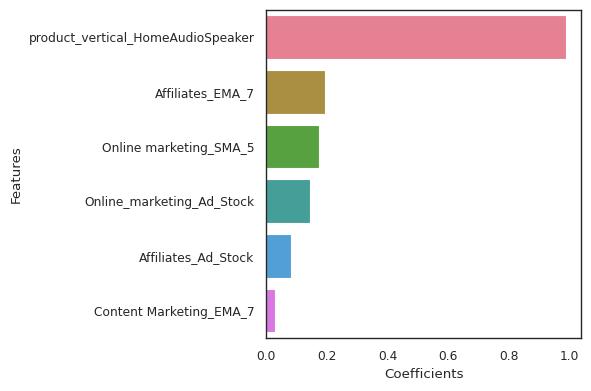

In [370]:
# Slightly alter the figure size to make it more horizontal.
plt.figure( dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.barplot(y='Features', x='Coefficients', palette='husl', data=homeaudio_lr_coef_df, estimator=np.sum)
# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

## **Distributive Lag Model(Additive)**

**The Additive and Multiplicative Linear Models that we have built till now can capture the current effect of the KPIs. However, if we want to capture the carry-over effect, we would want to model the current revenue figures based on the past figures of the KPIs.**

**In the distributed lag model, not only is the dependent variable entered in its lagged version, but the independent variables are as well. This is a more generalist model and captures the carry-over effect of all the variables. Thus, the Koyck model is a special type of distributed lag model, which includes the lag value of only the dependent variable.**

Yt = α+ µ1Yt-1 + µ2Yt-2 + µ3Yt-3 + ....

    + β1X1t + β1X1t-1 + β1X1t-2 + ....

    + β2X2t + β2X2t-1 + β2X2t-2 + ....

    + β3X3t + β3X3t-1 + β3X3t-2 + ....

    + β4X4t + β4X4t-1 + β4X4t-2 + ....

    + β5X5t + β5X5t-1 + β5X5t-2 + ....

    + ϵ

**Data Preparation for Modelling**

In [371]:
# Making copy of dataframes from the original ones
cameraaccessory_dladd_df = cameraaccessory_df_weekly.copy()
gamingaccessory_dladd_df = gamingaccessory_df_weekly.copy()
homeaudio_dladd_df = homeaudio_df_weekly.copy()

**Dropping Week column as it is just a row identifier and not add anything as information to the model**



In [372]:
cameraaccessory_dladd_df = cameraaccessory_dladd_df.drop('Week', axis=1)
gamingaccessory_dladd_df = gamingaccessory_dladd_df.drop('Week', axis=1)
homeaudio_dladd_df = homeaudio_dladd_df.drop('Week', axis=1)

**Creating new lag(Lag of 3 weeks) variables for the dependent variable (GMV) as well as independent variables**

In [373]:
cameraaccessory_dladd_df_columns = cameraaccessory_dladd_df.columns
gamingaccessory_dladd_df_columns = gamingaccessory_dladd_df.columns
homeaudio_dladd_df_columns = homeaudio_dladd_df.columns

In [374]:
cameraaccessory_dladd_df = lag_variables(cameraaccessory_dladd_df,cameraaccessory_dladd_df_columns,3)
gamingaccessory_dladd_df = lag_variables(gamingaccessory_dladd_df,gamingaccessory_dladd_df_columns,3)
homeaudio_dladd_df = lag_variables(homeaudio_dladd_df,homeaudio_dladd_df_columns,3)

**Creating new lag(Lag of 2 weeks) variables for the dependent variable (GMV) as well as independent variables**

In [375]:
cameraaccessory_dladd_df = lag_variables(cameraaccessory_dladd_df,cameraaccessory_dladd_df_columns,2)
gamingaccessory_dladd_df = lag_variables(gamingaccessory_dladd_df,gamingaccessory_dladd_df_columns,2)
homeaudio_dladd_df = lag_variables(homeaudio_dladd_df,homeaudio_dladd_df_columns,2)

**Creating new lag(Lag of 1 week) variables for the dependent variable (GMV) as well as independent variables**

In [376]:
cameraaccessory_dladd_df = lag_variables(cameraaccessory_dladd_df,cameraaccessory_dladd_df_columns,1)
gamingaccessory_dladd_df = lag_variables(gamingaccessory_dladd_df,gamingaccessory_dladd_df_columns,1)
homeaudio_dladd_df = lag_variables(homeaudio_dladd_df,homeaudio_dladd_df_columns,1)

**Imputing null with 0**

In [377]:
cameraaccessory_dladd_df.fillna(value=0, inplace=True)
gamingaccessory_dladd_df.fillna(value=0, inplace=True)
homeaudio_dladd_df.fillna(value=0, inplace=True)

**Train Test split**

In [378]:
cameraaccessory_dladd_df_train, cameraaccessory_dladd_df_test = train_test_split(cameraaccessory_dladd_df, train_size=0.7, test_size=0.3, random_state=100)
gamingaccessory_dladd_df_train, gamingaccessory_dladd_df_test = train_test_split(gamingaccessory_dladd_df, train_size=0.7, test_size=0.3, random_state=100)
homeaudio_dladd_df_train, homeaudio_dladd_df_test = train_test_split(homeaudio_dladd_df, train_size=0.7, test_size=0.3, random_state=100)

**Feature Scaling**

In [379]:
cameraaccessory_cols = list(cameraaccessory_dladd_df.columns)
gamingaccessory_cols = list(gamingaccessory_dladd_df.columns)
homeaudio_cols = list(homeaudio_dladd_df.columns)

In [380]:
scaler = StandardScaler()
cameraaccessory_dladd_df_train[cameraaccessory_cols] = scaler.fit_transform(cameraaccessory_dladd_df_train[cameraaccessory_cols])
cameraaccessory_dladd_df_test[cameraaccessory_cols] = scaler.transform(cameraaccessory_dladd_df_test[cameraaccessory_cols])
gamingaccessory_dladd_df_train[gamingaccessory_cols] = scaler.fit_transform(gamingaccessory_dladd_df_train[gamingaccessory_cols])
gamingaccessory_dladd_df_test[gamingaccessory_cols] = scaler.transform(gamingaccessory_dladd_df_test[gamingaccessory_cols])
homeaudio_dladd_df_train[homeaudio_cols] = scaler.fit_transform(homeaudio_dladd_df_train[homeaudio_cols])
homeaudio_dladd_df_test[homeaudio_cols] = scaler.transform(homeaudio_dladd_df_test[homeaudio_cols])

In [381]:
cameraaccessory_dladd_df_X_train = cameraaccessory_dladd_df_train.drop("gmv",axis=1)
cameraaccessory_dladd_df_y_train = cameraaccessory_dladd_df_train.gmv
cameraaccessory_dladd_df_X_test = cameraaccessory_dladd_df_test.drop("gmv",axis=1)
cameraaccessory_dladd_df_y_test = cameraaccessory_dladd_df_test.gmv

gamingaccessory_dladd_df_X_train = gamingaccessory_dladd_df_train.drop("gmv",axis=1)
gamingaccessory_dladd_df_y_train = gamingaccessory_dladd_df_train.gmv
gamingaccessory_dladd_df_X_test = gamingaccessory_dladd_df_test.drop("gmv",axis=1)
gamingaccessory_dladd_df_y_test = gamingaccessory_dladd_df_test.gmv

homeaudio_dladd_df_X_train = homeaudio_dladd_df_train.drop("gmv",axis=1)
homeaudio_dladd_df_y_train = homeaudio_dladd_df_train.gmv
homeaudio_dladd_df_X_test = homeaudio_dladd_df_test.drop("gmv",axis=1)
homeaudio_dladd_df_y_test = homeaudio_dladd_df_test.gmv

In [382]:
cameraaccessory_dladd_df_X_train.head()

,gmv_lag1,gmv_lag2,gmv_lag3,Discount_Percent,Discount_Percent_lag1,Discount_Percent_lag2,Discount_Percent_lag3,sla,sla_lag1,sla_lag2,sla_lag3,product_procurement_sla,product_procurement_sla_lag1,product_procurement_sla_lag2,product_procurement_sla_lag3,is_cod,is_cod_lag1,is_cod_lag2,is_cod_lag3,is_mass_market,is_mass_market_lag1,is_mass_market_lag2,is_mass_market_lag3,product_vertical_CameraAccessory,product_vertical_CameraAccessory_lag1,product_vertical_CameraAccessory_lag2,product_vertical_CameraAccessory_lag3,product_vertical_CameraBag,product_vertical_CameraBag_lag1,product_vertical_CameraBag_lag2,product_vertical_CameraBag_lag3,product_vertical_CameraBattery,product_vertical_CameraBattery_lag1,product_vertical_CameraBattery_lag2,product_vertical_CameraBattery_lag3,product_vertical_CameraBatteryCharger,product_vertical_CameraBatteryCharger_lag1,product_vertical_CameraBatteryCharger_lag2,product_vertical_CameraBatteryCharger_lag3,product_vertical_CameraFilmRolls,...,Min Temp,Min Temp_lag1,Min Temp_lag2,Min Temp_lag3,Mean Temp,Mean Temp_lag1,Mean Temp_lag2,Mean Temp_lag3,Heat Deg Days,Heat Deg Days_lag1,Heat Deg Days_lag2,Heat Deg Days_lag3,Cool Deg Days,Cool Deg Days_lag1,Cool Deg Days_lag2,Cool Deg Days_lag3,Total Rain (mm),Total Rain (mm)_lag1,Total Rain (mm)_lag2,Total Rain (mm)_lag3,Total Snow (cm),Total Snow (cm)_lag1,Total Snow (cm)_lag2,Total Snow (cm)_lag3,Total Precip (mm),Total Precip (mm)_lag1,Total Precip (mm)_lag2,Total Precip (mm)_lag3,Snow on Grnd (cm),Snow on Grnd (cm)_lag1,Snow on Grnd (cm)_lag2,Snow on Grnd (cm)_lag3,payday_week,payday_week_lag1,payday_week_lag2,payday_week_lag3,holiday_week,holiday_week_lag1,holiday_week_lag2,holiday_week_lag3
48,0.016,1.339,0.645,1.668,0.610,0.484,0.498,-0.708,-0.264,-0.310,-0.195,-1.389,-0.672,-0.281,-0.025,0.980,0.840,1.299,0.832,0.828,0.668,1.069,0.639,0.201,0.101,0.349,0.312,0.203,0.511,1.421,0.930,-0.360,0.001,0.503,0.350,0.441,0.559,1.189,0.864,2.301,...,0.567,1.203,0.658,0.097,0.862,1.026,1.272,0.099,-0.828,-0.966,-0.933,-0.145,0.730,0.958,1.948,-0.632,-0.841,0.610,-0.669,-0.705,-0.246,-0.273,-0.346,-0.351,-0.886,0.536,-0.668,-0.741,-0.229,-0.210,-0.241,-0.258,-0.866,1.029,-0.816,-0.866,-0.408,-0.306,3.266,-0.500
44,0.398,1.721,-0.677,1.567,0.885,0.486,0.458,-0.751,-0.368,0.209,-0.580,-1.047,-0.663,-0.017,0.013,1.046,1.189,0.754,-1.320,0.882,0.994,2.141,-0.563,0.110,-0.349,0.798,-0.714,0.842,0.778,2.013,-0.466,0.060,0.302,2.119,-0.820,1.045,1.051,2.677,-0.520,1.039,...,-0.203,-0.058,-0.002,0.097,-0.046,-0.111,-0.232,0.126,-0.166,-0.080,0.167,-0.180,-0.705,-0.722,-0.680,-0.632,0.497,-0.065,0.678,-0.801,-0.246,-0.273,-0.346,-0.351,0.450,-0.110,0.550,-0.832,-0.229,-0.210,-0.241,-0.258,1.155,-0.972,1.225,-0.866,-0.408,-0.306,-0.306,-0.500
37,-0.154,1.197,0.265,0.106,0.398,0.161,0.127,-0.637,-0.129,0.021,0.149,-0.821,-0.554,-0.027,0.051,0.168,0.424,0.866,0.809,0.384,0.267,0.778,0.730,-1.168,-0.671,0.405,1.287,-0.304,-0.185,0.326,0.091,1.556,-0.021,1.414,0.966,1.827,0.207,1.549,1.733,0.141,...,-0.914,-0.779,-0.721,-0.979,-0.871,-0.472,-0.264,-1.153,0.835,0.360,0.205,1.429,-0.739,-0.722,-0.680,-0.632,3.190,-0.615,1.705,-0.481,-0.246,-0.273,-0.346,3.123,3.137,-0.635,1.477,0.181,-0.229,-0.210,-0.241,1.237,-0.866,1.029,-0.816,1.155,2.449,-0.306,-0.306,-0.500
17,0.196,-0.092,3.327,-0.068,-0.460,-0.231,0.478,-0.151,0.334,0.596,0.260,1.000,1.023,0.375,0.709,0.530,0.464,-0.033,2.697,0.237,0.170,-0.329,2.860,-0.529,0.359,0.517,1.902,-0.075,0.101,-0.069,3.611,-0.258,0.066,-0.115,2.116,-0.486,-0.116,-0.173,1.038,-0.523,...,0.093,-0.239,0.598,0.157,0.078,-0.233,0.388,0.332,-0.329,0.069,-0.596,-0.376,-0.739,-0.722,-0.680,-0.415,-0.300,-0.482,-0.539,-0.801,-0.246,-0.273,-0.346,-0.351,-0.345,-0.509,-0.551,-0.832,-0.229,-0.210,-0.241,-0.258,-0.866,1.029,-0.816,1.155,-0.408,-0.306,-0.306,2.000
7,-2.138,-1.798,-0.617,-1.643,4.625,-2.752,-0.211,4.888,-0.186,2.022,0.282,-3.028,-4.435,2.282,0.381,-2.087,-1.721,-1.497,-0.630,-2.233,-1.968,-1.696,-0.819,-3.815,-2.474,-2.069,0.517,-2.306,-1.95

### **Simple Linear Regression Model for CameraAccessory**

In [383]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

cameraaccessory_dladd_model = LinearRegression().fit(cameraaccessory_dladd_df_X_train, cameraaccessory_dladd_df_y_train)

cameraaccessory_dladd_rfe = RFECV(cameraaccessory_dladd_model,cv=5,scoring='neg_mean_squared_error')             # running RFE
cameraaccessory_dladd_rfe = cameraaccessory_dladd_rfe.fit(cameraaccessory_dladd_df_X_train, cameraaccessory_dladd_df_y_train)

In [384]:
cameraaccessory_dladd_rfe.n_features_

54

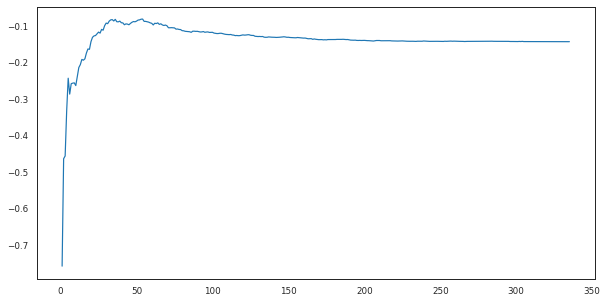

In [385]:
plt.figure(figsize=[10, 5])
plt.plot(range(1, cameraaccessory_dladd_df_X_train.shape[1]+1), cameraaccessory_dladd_rfe.grid_scores_)
plt.show();

In [386]:
cameraaccessory_dladd_model = LinearRegression().fit(cameraaccessory_dladd_df_X_train, cameraaccessory_dladd_df_y_train)

cameraaccessory_dladd_rfe = RFE(cameraaccessory_dladd_model,20)             # 20 seems ideal number of features
cameraaccessory_dladd_rfe = cameraaccessory_dladd_rfe.fit(cameraaccessory_dladd_df_X_train, cameraaccessory_dladd_df_y_train)

col = list(cameraaccessory_dladd_df_X_train.columns[cameraaccessory_dladd_rfe.support_])

cameraaccessory_dladd_model = LinearRegression().fit(cameraaccessory_dladd_df_X_train[col], cameraaccessory_dladd_df_y_train)

cameraaccessory_dladd_df_y_test_pred = cameraaccessory_dladd_model.predict(cameraaccessory_dladd_df_X_test[col])

print('R2 Score: {}'.format(r2_score(cameraaccessory_dladd_df_y_test, cameraaccessory_dladd_df_y_test_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(cameraaccessory_dladd_df_y_test, cameraaccessory_dladd_df_y_test_pred)))

R2 Score: 0.6753674243403458
Mean Squared Error: 0.34233931988998795


#### **Simple Linear Regression for CameraAccessory with K-Fold Cross validation**

In [387]:
cameraaccessory_dladd_df_cv = cameraaccessory_dladd_df.copy()

**Feature Scaling**

In [388]:
scaler = StandardScaler()
cameraaccessory_dladd_df_cv[cameraaccessory_dladd_df_cv.columns]=scaler.fit_transform(cameraaccessory_dladd_df_cv[cameraaccessory_dladd_df_cv.columns])

In [389]:
cameraaccessory_dladd_df_cv_X = cameraaccessory_dladd_df_cv.drop("gmv",axis=1)
cameraaccessory_dladd_df_cv_y = cameraaccessory_dladd_df_cv.gmv

**Model Building**

In [390]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn import metrics

cameraaccessory_dladd_model_cv = LinearRegression().fit(cameraaccessory_dladd_df_cv_X[col], cameraaccessory_dladd_df_cv_y)

cameraaccessory_dladd_predictions_cv = cross_val_predict(cameraaccessory_dladd_model_cv, cameraaccessory_dladd_df_cv_X[col], cameraaccessory_dladd_df_cv_y, cv=5)
accuracy = metrics.r2_score(cameraaccessory_dladd_df_cv_y, cameraaccessory_dladd_predictions_cv)
print("Cross-Predicted Accuracy:", accuracy)
print('Mean Squared Error: {}'.format(mean_squared_error(cameraaccessory_dladd_df_cv_y, cameraaccessory_dladd_predictions_cv)))

Cross-Predicted Accuracy: 0.6957460456636361
Mean Squared Error: 0.3042539543363639


#### **Determining Feature Importance for cameraaccessory from model without cv**

In [391]:
# linear regression model parameters
#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 
pd.set_option('display.precision',1)

cameraaccessory_dladd_model = LinearRegression().fit(cameraaccessory_dladd_df_X_train[col], cameraaccessory_dladd_df_y_train)
cameraaccessory_lr_model_parameters = list(cameraaccessory_dladd_model.coef_)
#cameraaccessory_lr_model_parameters.insert(0, cameraaccessory_model.intercept_)
cameraaccessory_lr_model_parameters = [abs(round(x, 3)) for x in cameraaccessory_lr_model_parameters]
cameraaccessory_lr_coef = list(zip(col, cameraaccessory_lr_model_parameters))
cameraaccessory_lr_coef

[('Discount_Percent_lag1', 0.106),
 ('Discount_Percent_lag3', 0.16),
 ('is_cod', 0.043),
 ('is_mass_market', 0.158),
 ('is_mass_market_lag1', 0.087),
 ('product_vertical_CameraAccessory', 0.092),
 ('product_vertical_CameraBattery', 0.278),
 ('product_vertical_CameraBatteryCharger_lag2', 0.102),
 ('product_vertical_CameraFilmRolls', 0.093),
 ('product_vertical_Lens', 0.286),
 ('Other_lag3', 0.13),
 ('Sale_Dates', 0.119),
 ('Sale_Dates_lag2', 0.082),
 ('Cool Deg Days_lag1', 0.215),
 ('Total Snow (cm)_lag1', 0.044),
 ('Total Snow (cm)_lag2', 0.045),
 ('Total Precip (mm)', 0.056),
 ('Snow on Grnd (cm)_lag2', 0.075),
 ('payday_week_lag3', 0.043),
 ('holiday_week', 0.051)]

In [392]:
cameraaccessory_lr_coef_df = pd.DataFrame(cameraaccessory_lr_coef)
col_rename = {0:'Features',1: 'Coefficients'}
cameraaccessory_lr_coef_df = cameraaccessory_lr_coef_df.rename(columns=col_rename)
cameraaccessory_lr_coef_df = cameraaccessory_lr_coef_df.loc[cameraaccessory_lr_coef_df['Coefficients']!=0.0]
cameraaccessory_lr_coef_df = cameraaccessory_lr_coef_df.sort_values(by=['Coefficients'], ascending = False)
cameraaccessory_lr_coef_df

,Features,Coefficients
9,product_vertical_Lens,0.286
6,product_vertical_CameraBattery,0.278
13,Cool Deg Days_lag1,0.215
1,Discount_Percent_lag3,0.160
3,is_mass_market,0.158
10,Other_lag3,0.130
11,Sale_Dates,0.119
0,Discount_Percent_lag1,0.106
7,product_vertical_CameraBatteryCharger_lag2,0.102
8,product_vertical_CameraFilmRolls,0.093


#### **Plotting the Features in descending order of Importance for cameraaccessory**

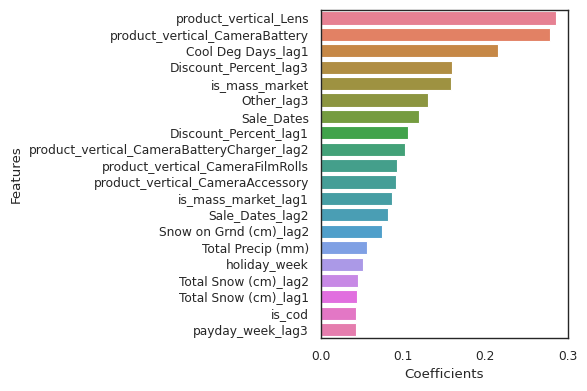

In [393]:
# Slightly alter the figure size to make it more horizontal.
plt.figure( dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.barplot(y='Features', x='Coefficients', palette='husl', data=cameraaccessory_lr_coef_df, estimator=np.sum)
# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

### **Simple Linear Regression for GamingAccessory**

In [394]:
gamingaccessory_dladd_model = LinearRegression().fit(gamingaccessory_dladd_df_X_train, gamingaccessory_dladd_df_y_train)

gamingaccessory_dladd_rfe = RFECV(gamingaccessory_dladd_model, cv=5,scoring='neg_mean_squared_error')             # running RFE
gamingaccessory_dladd_rfe = gamingaccessory_dladd_rfe.fit(gamingaccessory_dladd_df_X_train, gamingaccessory_dladd_df_y_train)

In [395]:
gamingaccessory_dladd_rfe.n_features_

31

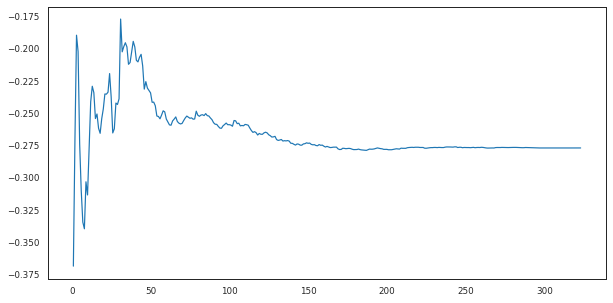

In [396]:
plt.figure(figsize=[10, 5])
plt.plot(range(1, gamingaccessory_dladd_df_X_train.shape[1]+1), gamingaccessory_dladd_rfe.grid_scores_)
plt.show();

In [397]:
gamingaccessory_dladd_model = LinearRegression().fit(gamingaccessory_dladd_df_X_train, gamingaccessory_dladd_df_y_train)

gamingaccessory_dladd_rfe = RFE(gamingaccessory_dladd_model, 8)             # running RFE
gamingaccessory_dladd_rfe = gamingaccessory_dladd_rfe.fit(gamingaccessory_dladd_df_X_train, gamingaccessory_dladd_df_y_train)

col = list(gamingaccessory_dladd_df_X_train.columns[gamingaccessory_dladd_rfe.support_])

gamingaccessory_dladd_model = LinearRegression().fit(gamingaccessory_dladd_df_X_train[col], gamingaccessory_dladd_df_y_train)

gamingaccessory_dladd_df_y_test_pred = gamingaccessory_dladd_model.predict(gamingaccessory_dladd_df_X_test[col])

print('R2 Score: {}'.format(r2_score(gamingaccessory_dladd_df_y_test, gamingaccessory_dladd_df_y_test_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(gamingaccessory_dladd_df_y_test, gamingaccessory_dladd_df_y_test_pred)))

R2 Score: 0.9653851350360523
Mean Squared Error: 0.044812889010219355


#### **Simple Linear Regression for GamingAccessory with K-Fold Cross validation**

In [398]:
gamingaccessory_dladd_df_cv = gamingaccessory_dladd_df.copy()

**Feature Scaling**

In [399]:
scaler = StandardScaler()
gamingaccessory_dladd_df_cv[gamingaccessory_dladd_df_cv.columns]=scaler.fit_transform(gamingaccessory_dladd_df_cv[gamingaccessory_dladd_df_cv.columns])

In [400]:
gamingaccessory_dladd_df_cv_X = gamingaccessory_dladd_df_cv.drop("gmv",axis=1)
gamingaccessory_dladd_df_cv_y = gamingaccessory_dladd_df_cv.gmv

**Model Building**

In [401]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn import metrics

gamingaccessory_dladd_model_cv = LinearRegression().fit(gamingaccessory_dladd_df_cv_X[col], gamingaccessory_dladd_df_cv_y)

gamingaccessory_dladd_predictions_cv = cross_val_predict(gamingaccessory_dladd_model_cv, gamingaccessory_dladd_df_cv_X[col], gamingaccessory_dladd_df_cv_y, cv=5)
accuracy = metrics.r2_score(gamingaccessory_dladd_df_cv_y, gamingaccessory_dladd_predictions_cv)
print("Cross-Predicted Accuracy:", accuracy)
print('Mean Squared Error: {}'.format(mean_squared_error(gamingaccessory_dladd_df_cv_y, gamingaccessory_dladd_predictions_cv)))

Cross-Predicted Accuracy: 0.9290607099511108
Mean Squared Error: 0.07093929004888917


#### **Determining Feature Importance for gamingaccessory from model without cv**

In [402]:
# linear regression model parameters
#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 
pd.set_option('display.precision',1)

gamingaccessory_dladd_model = LinearRegression().fit(gamingaccessory_dladd_df_X_train[col], gamingaccessory_dladd_df_y_train)
gamingaccessory_lr_model_parameters = list(gamingaccessory_dladd_model.coef_)
#cameraaccessory_lr_model_parameters.insert(0, cameraaccessory_model.intercept_)
gamingaccessory_lr_model_parameters = [abs(round(x, 3)) for x in gamingaccessory_lr_model_parameters]
gamingaccessory_lr_coef = list(zip(col, gamingaccessory_lr_model_parameters))
gamingaccessory_lr_coef

[('is_cod', 0.111),
 ('product_vertical_GamingAccessoryKit', 0.183),
 ('product_vertical_GamingHeadset', 0.175),
 ('product_vertical_GamingMouse', 0.281),
 ('product_vertical_GamingMousePad', 0.218),
 ('product_vertical_MotionController', 0.278),
 ('product_vertical_Others', 0.15),
 ('product_vertical_TVOutCableAccessory', 0.139)]

In [403]:
gamingaccessory_lr_coef_df = pd.DataFrame(gamingaccessory_lr_coef)
col_rename = {0:'Features',1: 'Coefficients'}
gamingaccessory_lr_coef_df = gamingaccessory_lr_coef_df.rename(columns=col_rename)
gamingaccessory_lr_coef_df = gamingaccessory_lr_coef_df.loc[gamingaccessory_lr_coef_df['Coefficients']!=0.0]
gamingaccessory_lr_coef_df = gamingaccessory_lr_coef_df.sort_values(by=['Coefficients'], ascending = False)
gamingaccessory_lr_coef_df

,Features,Coefficients
3,product_vertical_GamingMouse,0.281
5,product_vertical_MotionController,0.278
4,product_vertical_GamingMousePad,0.218
1,product_vertical_GamingAccessoryKit,0.183
2,product_vertical_GamingHeadset,0.175
6,product_vertical_Others,0.150
7,product_vertical_TVOutCableAccessory,0.139
0,is_cod,0.111


#### **Plotting the Features in descending order of Importance for gaming accessory**

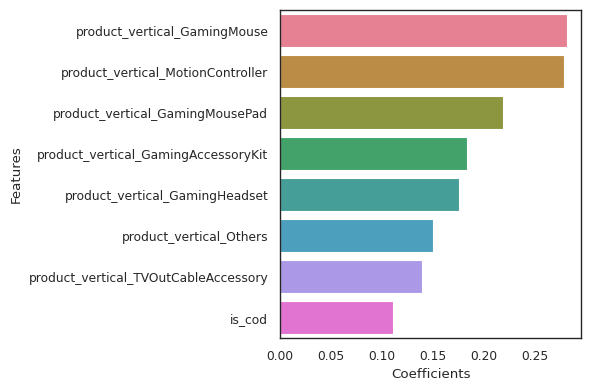

In [404]:
# Slightly alter the figure size to make it more horizontal.
plt.figure( dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.barplot(y='Features', x='Coefficients', palette='husl', data=gamingaccessory_lr_coef_df, estimator=np.sum)
# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

### **Simple Linear Regression for HomeAudio**

In [405]:
homeaudio_dladd_model = LinearRegression().fit(homeaudio_dladd_df_X_train, homeaudio_dladd_df_y_train)

homeaudio_dladd_rfe = RFECV(homeaudio_dladd_model, cv=5,scoring='neg_mean_squared_error')             # running RFE
homeaudio_dladd_rfe = homeaudio_dladd_rfe.fit(homeaudio_dladd_df_X_train, homeaudio_dladd_df_y_train)

In [406]:
homeaudio_dladd_rfe.n_features_

5

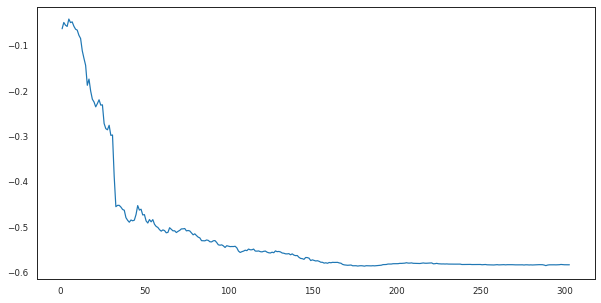

In [407]:
plt.figure(figsize=[10, 5])
plt.plot(range(1, homeaudio_dladd_df_X_train.shape[1]+1), homeaudio_dladd_rfe.grid_scores_)
plt.show();

In [408]:
homeaudio_dladd_model = LinearRegression().fit(homeaudio_dladd_df_X_train, homeaudio_dladd_df_y_train)

homeaudio_dladd_rfe = RFE(homeaudio_dladd_model, 6)             # running RFE
homeaudio_dladd_rfe = homeaudio_dladd_rfe.fit(homeaudio_dladd_df_X_train, homeaudio_dladd_df_y_train)

col = list(homeaudio_dladd_df_X_train.columns[homeaudio_dladd_rfe.support_])

homeaudio_dladd_model = LinearRegression().fit(homeaudio_dladd_df_X_train[col], homeaudio_dladd_df_y_train)

homeaudio_dladd_df_y_test_pred = homeaudio_dladd_model.predict(homeaudio_dladd_df_X_test[col])

print('R2 Score: {}'.format(r2_score(homeaudio_dladd_df_y_test, homeaudio_dladd_df_y_test_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(homeaudio_dladd_df_y_test, homeaudio_dladd_df_y_test_pred)))

R2 Score: 0.929676771458357
Mean Squared Error: 0.033944304456201474


#### **Simple Linear Regression for Homeaudio with K-Fold Cross validation**

In [409]:
homeaudio_dladd_df_cv = homeaudio_dladd_df.copy()

**Feature Scaling**

In [410]:
scaler = StandardScaler()
homeaudio_dladd_df_cv[homeaudio_dladd_df_cv.columns]=scaler.fit_transform(homeaudio_dladd_df_cv[homeaudio_dladd_df_cv.columns])

In [411]:
homeaudio_dladd_df_cv_X = homeaudio_dladd_df_cv.drop("gmv",axis=1)
homeaudio_dladd_df_cv_y = homeaudio_dladd_df_cv.gmv

**Model Building**

In [412]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn import metrics

homeaudio_dladd_model_cv = LinearRegression().fit(homeaudio_dladd_df_cv_X[col], homeaudio_dladd_df_cv_y)

homeaudio_dladd_predictions_cv = cross_val_predict(homeaudio_dladd_model_cv, homeaudio_dladd_df_cv_X[col], homeaudio_dladd_df_cv_y, cv=5)
accuracy = metrics.r2_score(homeaudio_dladd_df_cv_y, homeaudio_dladd_predictions_cv)
print("Cross-Predicted Accuracy:", accuracy)
print('Mean Squared Error: {}'.format(mean_squared_error(homeaudio_dladd_df_cv_y, homeaudio_dladd_predictions_cv)))

Cross-Predicted Accuracy: 0.9640693873914978
Mean Squared Error: 0.03593061260850219


#### **Determining Feature Importance for homeaudio from model without cv**

In [413]:
# linear regression model parameters
#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 
pd.set_option('display.precision',1)

homeaudio_dladd_model = LinearRegression().fit(homeaudio_dladd_df_X_train[col], homeaudio_dladd_df_y_train)
homeaudio_lr_model_parameters = list(homeaudio_dladd_model.coef_)
#cameraaccessory_lr_model_parameters.insert(0, cameraaccessory_model.intercept_)
homeaudio_lr_model_parameters = [abs(round(x, 3)) for x in homeaudio_lr_model_parameters]
homeaudio_lr_coef = list(zip(col, homeaudio_lr_model_parameters))
homeaudio_lr_coef

[('Discount_Percent', 0.125),
 ('product_vertical_Dock', 0.093),
 ('product_vertical_Dock_lag2', 0.045),
 ('product_vertical_HomeAudioSpeaker', 0.971),
 ('Total Investment_SMA_5_lag2', 0.026),
 ('SEM_lag1', 0.059)]

In [414]:
homeaudio_lr_coef_df = pd.DataFrame(homeaudio_lr_coef)
col_rename = {0:'Features',1: 'Coefficients'}
homeaudio_lr_coef_df = homeaudio_lr_coef_df.rename(columns=col_rename)
homeaudio_lr_coef_df = homeaudio_lr_coef_df.loc[homeaudio_lr_coef_df['Coefficients']!=0.0]
homeaudio_lr_coef_df = homeaudio_lr_coef_df.sort_values(by=['Coefficients'], ascending = False)
homeaudio_lr_coef_df

,Features,Coefficients
3,product_vertical_HomeAudioSpeaker,0.971
0,Discount_Percent,0.125
1,product_vertical_Dock,0.093
5,SEM_lag1,0.059
2,product_vertical_Dock_lag2,0.045
4,Total Investment_SMA_5_lag2,0.026


#### **Plotting the Features in descending order of Importance for homeaudio**

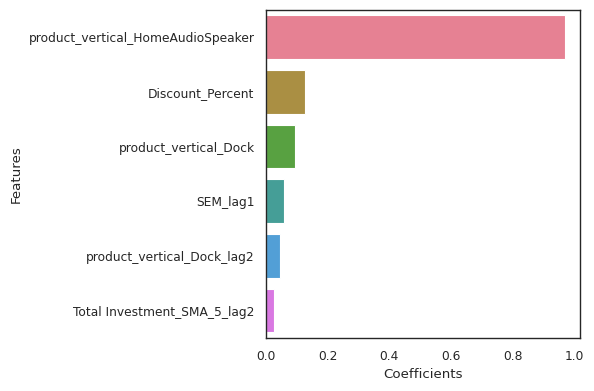

In [415]:
# Slightly alter the figure size to make it more horizontal.
plt.figure( dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.barplot(y='Features', x='Coefficients', palette='husl', data=homeaudio_lr_coef_df, estimator=np.sum)
# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

## **Distributive Lag Model(Multiplicative)**

**The Distributive Lag Model(Additive) helped us capture the not only the current, but also the carry-over effect of all the variables(depedent and independent).**

Yt = α+ µ1Yt-1 + µ2Yt-2 + µ3Yt-3 + ....

    + β1X1t + β1X1t-1 + β1X1t-2 + ....

    + β2X2t + β2X2t-1 + β2X2t-2 + ....

    + β3X3t + β3X3t-1 + β3X3t-2 + ....

    + β4X4t + β4X4t-1 + β4X4t-2 + ....

    + β5X5t + β5X5t-1 + β5X5t-2 + ....

    + ϵ

**Now the Distributive Lag Model(Multiplicative) will help us capture the interactions between current and carry over effects of the KPIs.**

To fit a multiplicative model, take logarithms of the data(on both sides of the model), then analyse the log data as before.

Yt = α+ µ1ln(Yt-1) + µ2ln(Yt-2) + µ3ln(Yt-3) + ....

    + β1ln(X1t) + β1ln(X1t-1) + β1ln(X1t-2) + ....

    + β2ln(X2t) + β2ln(X2t-1) + β2ln(X2t-2) + ....

    + β3ln(X3t) + β3ln(X3t-1) + β3ln(X3t-2) + ....

    + β4ln(X4t) + β4ln(X4t-1) + β4ln(X4t-2) + ....

    + β5ln(X5t) + β5ln(X5t-1) + β5ln(X5t-2) + ....

    + ϵ'

**Data Preparation for Modelling**

In [416]:
# Making copy of dataframes from the original ones
cameraaccessory_dlmul_df = cameraaccessory_df_weekly.copy()
gamingaccessory_dlmul_df = gamingaccessory_df_weekly.copy()
homeaudio_dlmul_df = homeaudio_df_weekly.copy()

**Dropping Week column as it is just a row identifier and not add anything as information to the model**



In [417]:
cameraaccessory_dlmul_df = cameraaccessory_dlmul_df.drop('Week', axis=1)
gamingaccessory_dlmul_df = gamingaccessory_dlmul_df.drop('Week', axis=1)
homeaudio_dlmul_df = homeaudio_dlmul_df.drop('Week', axis=1)

**Creating new lag(Lag of 3 weeks) variables for the dependent variable (GMV) as well as independent variables**

In [418]:
cameraaccessory_dlmul_df_columns = cameraaccessory_dlmul_df.columns
gamingaccessory_dlmul_df_columns = gamingaccessory_dlmul_df.columns
homeaudio_dlmul_df_columns = homeaudio_dlmul_df.columns

In [419]:
cameraaccessory_dlmul_df = lag_variables(cameraaccessory_dlmul_df,cameraaccessory_dlmul_df_columns,3)
gamingaccessory_dlmul_df = lag_variables(gamingaccessory_dlmul_df,gamingaccessory_dlmul_df_columns,3)
homeaudio_dlmul_df = lag_variables(homeaudio_dlmul_df,homeaudio_dlmul_df_columns,3)

**Creating new lag(Lag of 2 weeks) variables for the dependent variable (GMV) as well as independent variables**

In [420]:
cameraaccessory_dlmul_df = lag_variables(cameraaccessory_dlmul_df,cameraaccessory_dlmul_df_columns,2)
gamingaccessory_dlmul_df = lag_variables(gamingaccessory_dlmul_df,gamingaccessory_dlmul_df_columns,2)
homeaudio_dlmul_df = lag_variables(homeaudio_dlmul_df,homeaudio_dlmul_df_columns,2)

**Creating new lag(Lag of 1 week) variables for the dependent variable (GMV) as well as independent variables**

In [421]:
cameraaccessory_dlmul_df = lag_variables(cameraaccessory_dlmul_df,cameraaccessory_dlmul_df_columns,1)
gamingaccessory_dlmul_df = lag_variables(gamingaccessory_dlmul_df,gamingaccessory_dlmul_df_columns,1)
homeaudio_dlmul_df = lag_variables(homeaudio_dlmul_df,homeaudio_dlmul_df_columns,1)

**Imputing null with 0**

In [422]:
cameraaccessory_dladd_df.fillna(value=0, inplace=True)
gamingaccessory_dladd_df.fillna(value=0, inplace=True)
homeaudio_dladd_df.fillna(value=0, inplace=True)

**Taking Logarithm of both the Dependent and the independent variables**

After taking log, all 0 values will be transformed to inf. Retransforming these values to 0

In [423]:
cameraaccessory_dlmul_df = cameraaccessory_dlmul_df.applymap(lambda x: np.log(x))
cameraaccessory_dlmul_df = cameraaccessory_dlmul_df.replace([np.inf, -np.inf], 0)
cameraaccessory_dlmul_df = cameraaccessory_dlmul_df.replace(np.nan, 0)

gamingaccessory_dlmul_df = gamingaccessory_dlmul_df.applymap(lambda x: np.log(x))
gamingaccessory_dlmul_df = gamingaccessory_dlmul_df.replace([np.inf, -np.inf], 0)
gamingaccessory_dlmul_df = gamingaccessory_dlmul_df.replace(np.nan, 0)

homeaudio_dlmul_df = homeaudio_dlmul_df.applymap(lambda x: np.log(x))
homeaudio_dlmul_df = homeaudio_dlmul_df.replace([np.inf, -np.inf], 0)
homeaudio_dlmul_df = homeaudio_dlmul_df.replace(np.nan, 0)

**Train Test split**

In [424]:
cameraaccessory_dlmul_df_train, cameraaccessory_dlmul_df_test = train_test_split(cameraaccessory_dlmul_df, train_size=0.7, test_size=0.3, random_state=100)
gamingaccessory_dlmul_df_train, gamingaccessory_dlmul_df_test = train_test_split(gamingaccessory_dlmul_df, train_size=0.7, test_size=0.3, random_state=100)
homeaudio_dlmul_df_train, homeaudio_dlmul_df_test = train_test_split(homeaudio_dlmul_df, train_size=0.7, test_size=0.3, random_state=100)

**Feature Scaling**

In [425]:
cameraaccessory_cols = list(cameraaccessory_dlmul_df.columns)
gamingaccessory_cols = list(gamingaccessory_dlmul_df.columns)
homeaudio_cols = list(homeaudio_dlmul_df.columns)

In [426]:
scaler = StandardScaler()
cameraaccessory_dlmul_df_train[cameraaccessory_cols] = scaler.fit_transform(cameraaccessory_dlmul_df_train[cameraaccessory_cols])
cameraaccessory_dlmul_df_test[cameraaccessory_cols] = scaler.transform(cameraaccessory_dlmul_df_test[cameraaccessory_cols])
gamingaccessory_dlmul_df_train[gamingaccessory_cols] = scaler.fit_transform(gamingaccessory_dlmul_df_train[gamingaccessory_cols])
gamingaccessory_dlmul_df_test[gamingaccessory_cols] = scaler.transform(gamingaccessory_dlmul_df_test[gamingaccessory_cols])
homeaudio_dlmul_df_train[homeaudio_cols] = scaler.fit_transform(homeaudio_dlmul_df_train[homeaudio_cols])
homeaudio_dlmul_df_test[homeaudio_cols] = scaler.transform(homeaudio_dlmul_df_test[homeaudio_cols])

In [427]:
cameraaccessory_dlmul_df_X_train = cameraaccessory_dlmul_df_train.drop("gmv",axis=1)
cameraaccessory_dlmul_df_y_train = cameraaccessory_dlmul_df_train.gmv
cameraaccessory_dlmul_df_X_test = cameraaccessory_dlmul_df_test.drop("gmv",axis=1)
cameraaccessory_dlmul_df_y_test = cameraaccessory_dlmul_df_test.gmv

gamingaccessory_dlmul_df_X_train = gamingaccessory_dlmul_df_train.drop("gmv",axis=1)
gamingaccessory_dlmul_df_y_train = gamingaccessory_dlmul_df_train.gmv
gamingaccessory_dlmul_df_X_test = gamingaccessory_dlmul_df_test.drop("gmv",axis=1)
gamingaccessory_dlmul_df_y_test = gamingaccessory_dlmul_df_test.gmv

homeaudio_dlmul_df_X_train = homeaudio_dlmul_df_train.drop("gmv",axis=1)
homeaudio_dlmul_df_y_train = homeaudio_dlmul_df_train.gmv
homeaudio_dlmul_df_X_test = homeaudio_dlmul_df_test.drop("gmv",axis=1)
homeaudio_dlmul_df_y_test = homeaudio_dlmul_df_test.gmv

In [428]:
cameraaccessory_dlmul_df_X_train.head()

,gmv_lag1,gmv_lag2,gmv_lag3,Discount_Percent,Discount_Percent_lag1,Discount_Percent_lag2,Discount_Percent_lag3,sla,sla_lag1,sla_lag2,sla_lag3,product_procurement_sla,product_procurement_sla_lag1,product_procurement_sla_lag2,product_procurement_sla_lag3,is_cod,is_cod_lag1,is_cod_lag2,is_cod_lag3,is_mass_market,is_mass_market_lag1,is_mass_market_lag2,is_mass_market_lag3,product_vertical_CameraAccessory,product_vertical_CameraAccessory_lag1,product_vertical_CameraAccessory_lag2,product_vertical_CameraAccessory_lag3,product_vertical_CameraBag,product_vertical_CameraBag_lag1,product_vertical_CameraBag_lag2,product_vertical_CameraBag_lag3,product_vertical_CameraBattery,product_vertical_CameraBattery_lag1,product_vertical_CameraBattery_lag2,product_vertical_CameraBattery_lag3,product_vertical_CameraBatteryCharger,product_vertical_CameraBatteryCharger_lag1,product_vertical_CameraBatteryCharger_lag2,product_vertical_CameraBatteryCharger_lag3,product_vertical_CameraFilmRolls,...,Min Temp,Min Temp_lag1,Min Temp_lag2,Min Temp_lag3,Mean Temp,Mean Temp_lag1,Mean Temp_lag2,Mean Temp_lag3,Heat Deg Days,Heat Deg Days_lag1,Heat Deg Days_lag2,Heat Deg Days_lag3,Cool Deg Days,Cool Deg Days_lag1,Cool Deg Days_lag2,Cool Deg Days_lag3,Total Rain (mm),Total Rain (mm)_lag1,Total Rain (mm)_lag2,Total Rain (mm)_lag3,Total Snow (cm),Total Snow (cm)_lag1,Total Snow (cm)_lag2,Total Snow (cm)_lag3,Total Precip (mm),Total Precip (mm)_lag1,Total Precip (mm)_lag2,Total Precip (mm)_lag3,Snow on Grnd (cm),Snow on Grnd (cm)_lag1,Snow on Grnd (cm)_lag2,Snow on Grnd (cm)_lag3,payday_week,payday_week_lag1,payday_week_lag2,payday_week_lag3,holiday_week,holiday_week_lag1,holiday_week_lag2,holiday_week_lag3
48,0.280,0.508,0.465,1.616,0.740,0.330,0.362,-0.788,-0.138,-0.108,0.004,-1.379,-0.449,-0.209,0.024,0.500,0.516,0.642,0.614,0.456,0.432,0.558,0.519,0.228,0.285,0.428,0.459,0.273,0.425,0.664,0.607,0.057,0.269,0.459,0.469,0.381,0.443,0.644,0.615,1.167,...,0.756,1.172,0.829,0.198,0.731,0.726,0.813,0.405,-1.394,-0.838,-0.854,0.353,0.844,1.131,1.577,-0.350,-0.641,0.967,-1.492,-1.941,-0.246,-0.140,-0.151,-0.138,-0.680,0.901,-1.476,-1.952,-0.250,-0.227,-0.264,-0.280,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
44,0.351,0.541,0.268,1.527,1.023,0.331,0.350,-0.842,-0.230,0.260,-0.291,-1.012,-0.442,0.047,0.061,0.514,0.570,0.566,-0.490,0.470,0.492,0.688,0.249,0.193,0.105,0.556,-0.012,0.498,0.489,0.752,0.225,0.195,0.338,0.697,0.112,0.587,0.559,0.862,0.200,0.845,...,-0.407,-0.099,0.053,0.198,0.257,0.276,0.216,0.419,0.347,0.441,0.616,0.322,-3.375,-0.655,-0.400,-0.350,0.863,0.290,0.997,-0.647,-0.246,-0.140,-0.151,-0.138,0.809,0.237,0.925,-0.699,-0.250,-0.227,-0.264,-0.280,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
37,0.244,0.495,0.423,0.155,0.514,0.216,0.246,-0.698,-0.021,0.133,0.238,-0.777,-0.353,0.036,0.098,0.298,0.440,0.583,0.611,0.328,0.348,0.514,0.533,-0.408,-0.049,0.445,0.727,0.050,0.215,0.445,0.416,0.562,0.264,0.608,0.580,0.803,0.346,0.706,0.762,0.478,...,-1.239,-1.247,-1.191,-1.035,-0.548,0.052,0.197,-0.939,1.016,0.727,0.641,1.117,-0.479,-0.655,-0.400,-0.350,2.009,-1.200,1.498,-0.647,-0.246,-0.140,-0.151,2.781,1.944,-1.226,1.408,0.555,-0.250,-0.227,-0.264,2.029,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
17,0.315,0.336,0.645,-0.022,-0.474,0.065,0.356,-0.113,0.359,0.505,0.308,0.967,0.788,0.397,0.687,0.396,0.448,0.415,0.813,0.281,0.325,0.278,0.764,-0.078,0.374,0.478,0.856,0.157,0.310,0.335,0.947,0.092,0.285,0.321,0.732,-0.049,0.241,0.304,0.648,-0.008,...,0.223,-0.612,0.780,0.303,0.337,0.207,0.521,0.516,0.153,0.551,-0.242,0.123,-0.479,-0.655,-0.400,-1.506,-0.077,-0.602,-0.718,-0.647,-0.246,-0.140,-0.151,-0.138,-0.122,-0.638,-0.729,-0.699,-0.250,-0.227,-0.264,-0.280,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,-3.949,-1.816,0.281,-1.763,4.091,-1.724,0.127,4.392,-0.070,1.253,0.322,-3.320,-5.083,1.758,0.407,-5.005,-3.031,-2.333,0.265,-5.569,-3.890,-2.291,0.151,-5.545,-3.163,-2.407,0.525,-5.552,-3.350,-2.488,0.208,-5.650,-3.480,-2.137,0.290,-5.469,-3.338,-2.477,0.2

### **Simple Linear Regression Model for CameraAccessory**

In [429]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

cameraaccessory_dlmul_model = LinearRegression().fit(cameraaccessory_dlmul_df_X_train, cameraaccessory_dlmul_df_y_train)

cameraaccessory_dlmul_rfe = RFECV(cameraaccessory_dlmul_model,cv=5,scoring='neg_mean_squared_error')             # running RFE
cameraaccessory_dlmul_rfe = cameraaccessory_dlmul_rfe.fit(cameraaccessory_dlmul_df_X_train, cameraaccessory_dlmul_df_y_train)

In [430]:
cameraaccessory_dlmul_rfe.n_features_

6

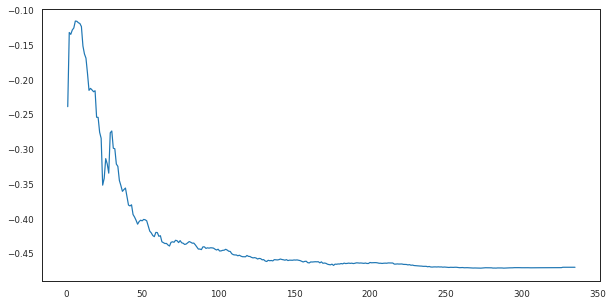

In [431]:
plt.figure(figsize=[10, 5])
plt.plot(range(1, cameraaccessory_dlmul_df_X_train.shape[1]+1), cameraaccessory_dlmul_rfe.grid_scores_)
plt.show();

In [432]:
cameraaccessory_dlmul_model = LinearRegression().fit(cameraaccessory_dlmul_df_X_train, cameraaccessory_dlmul_df_y_train)

cameraaccessory_dlmul_rfe = RFE(cameraaccessory_dlmul_model,6)             # 20 seems ideal number of features
cameraaccessory_dlmul_rfe = cameraaccessory_dlmul_rfe.fit(cameraaccessory_dlmul_df_X_train, cameraaccessory_dlmul_df_y_train)

col = list(cameraaccessory_dlmul_df_X_train.columns[cameraaccessory_dlmul_rfe.support_])

cameraaccessory_dlmul_model = LinearRegression().fit(cameraaccessory_dlmul_df_X_train[col], cameraaccessory_dlmul_df_y_train)

cameraaccessory_dlmul_df_y_test_pred = cameraaccessory_dlmul_model.predict(cameraaccessory_dlmul_df_X_test[col])

print('R2 Score: {}'.format(r2_score(cameraaccessory_dlmul_df_y_test, cameraaccessory_dlmul_df_y_test_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(cameraaccessory_dlmul_df_y_test, cameraaccessory_dlmul_df_y_test_pred)))

R2 Score: 0.9710905150112603
Mean Squared Error: 0.13751852887835447


#### **Simple Linear Regression for CameraAccessory with K-Fold Cross validation**

In [433]:
cameraaccessory_dlmul_df_cv = cameraaccessory_dlmul_df.copy()

**Feature Scaling**

In [434]:
scaler = StandardScaler()
cameraaccessory_dlmul_df_cv[cameraaccessory_dlmul_df_cv.columns]=scaler.fit_transform(cameraaccessory_dlmul_df_cv[cameraaccessory_dlmul_df_cv.columns])

In [435]:
cameraaccessory_dlmul_df_cv_X = cameraaccessory_dlmul_df_cv.drop("gmv",axis=1)
cameraaccessory_dlmul_df_cv_y = cameraaccessory_dlmul_df_cv.gmv

**Model Building**

In [436]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn import metrics

cameraaccessory_dlmul_model_cv = LinearRegression().fit(cameraaccessory_dlmul_df_cv_X[col], cameraaccessory_dlmul_df_cv_y)

cameraaccessory_dlmul_predictions_cv = cross_val_predict(cameraaccessory_dlmul_model_cv, cameraaccessory_dlmul_df_cv_X[col], cameraaccessory_dlmul_df_cv_y, cv=5)
accuracy = metrics.r2_score(cameraaccessory_dlmul_df_cv_y, cameraaccessory_dlmul_predictions_cv)
print("Cross-Predicted Accuracy:", accuracy)
print('Mean Squared Error: {}'.format(mean_squared_error(cameraaccessory_dlmul_df_cv_y, cameraaccessory_dlmul_predictions_cv)))

Cross-Predicted Accuracy: 0.8966992743657584
Mean Squared Error: 0.10330072563424161


#### **Determining Feature Importance for cameraaccessory from model without cv**

In [437]:
# linear regression model parameters
#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 
pd.set_option('display.precision',1)

cameraaccessory_dlmul_model = LinearRegression().fit(cameraaccessory_dlmul_df_X_train[col], cameraaccessory_dlmul_df_y_train)
cameraaccessory_lr_model_parameters = list(cameraaccessory_dlmul_model.coef_)
#cameraaccessory_lr_model_parameters.insert(0, cameraaccessory_model.intercept_)
cameraaccessory_lr_model_parameters = [abs(round(x, 3)) for x in cameraaccessory_lr_model_parameters]
cameraaccessory_lr_coef = list(zip(col, cameraaccessory_lr_model_parameters))
cameraaccessory_lr_coef

[('product_vertical_CameraAccessory', 0.169),
 ('product_vertical_CameraBag', 0.135),
 ('product_vertical_CameraBattery', 0.437),
 ('product_vertical_Lens', 0.227),
 ('Online marketing', 0.158),
 ('Affiliates', 0.224)]

In [438]:
cameraaccessory_lr_coef_df = pd.DataFrame(cameraaccessory_lr_coef)
col_rename = {0:'Features',1: 'Coefficients'}
cameraaccessory_lr_coef_df = cameraaccessory_lr_coef_df.rename(columns=col_rename)
cameraaccessory_lr_coef_df = cameraaccessory_lr_coef_df.loc[cameraaccessory_lr_coef_df['Coefficients']!=0.0]
cameraaccessory_lr_coef_df = cameraaccessory_lr_coef_df.sort_values(by=['Coefficients'], ascending = False)
cameraaccessory_lr_coef_df

,Features,Coefficients
2,product_vertical_CameraBattery,0.437
3,product_vertical_Lens,0.227
5,Affiliates,0.224
0,product_vertical_CameraAccessory,0.169
4,Online marketing,0.158
1,product_vertical_CameraBag,0.135


#### **Plotting the Features in descending order of Importance for cameraaccessory**

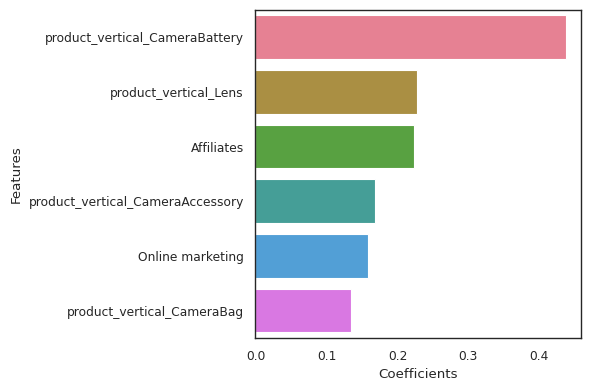

In [439]:
# Slightly alter the figure size to make it more horizontal.
plt.figure( dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.barplot(y='Features', x='Coefficients', palette='husl', data=cameraaccessory_lr_coef_df, estimator=np.sum)
# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

### **Simple Linear Regression for GamingAccessory**

In [440]:
gamingaccessory_dlmul_model = LinearRegression().fit(gamingaccessory_dlmul_df_X_train, gamingaccessory_dlmul_df_y_train)

gamingaccessory_dlmul_rfe = RFECV(gamingaccessory_dlmul_model, cv=5,scoring='neg_mean_squared_error')             # running RFE
gamingaccessory_dlmul_rfe = gamingaccessory_dlmul_rfe.fit(gamingaccessory_dlmul_df_X_train, gamingaccessory_dlmul_df_y_train)

In [441]:
gamingaccessory_dlmul_rfe.n_features_

3

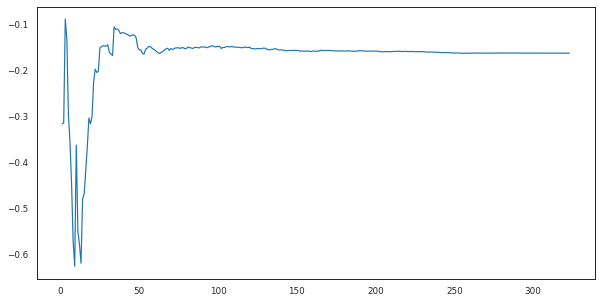

In [442]:
plt.figure(figsize=[10, 5])
plt.plot(range(1, gamingaccessory_dlmul_df_X_train.shape[1]+1), gamingaccessory_dlmul_rfe.grid_scores_)
plt.show();

In [443]:
gamingaccessory_dlmul_model = LinearRegression().fit(gamingaccessory_dlmul_df_X_train, gamingaccessory_dlmul_df_y_train)

gamingaccessory_dlmul_rfe = RFE(gamingaccessory_dlmul_model, 5)             # running RFE
gamingaccessory_dlmul_rfe = gamingaccessory_dlmul_rfe.fit(gamingaccessory_dlmul_df_X_train, gamingaccessory_dlmul_df_y_train)

col = list(gamingaccessory_dlmul_df_X_train.columns[gamingaccessory_dlmul_rfe.support_])

gamingaccessory_dlmul_model = LinearRegression().fit(gamingaccessory_dlmul_df_X_train[col], gamingaccessory_dlmul_df_y_train)

gamingaccessory_dlmul_df_y_test_pred = gamingaccessory_dlmul_model.predict(gamingaccessory_dlmul_df_X_test[col])

print('R2 Score: {}'.format(r2_score(gamingaccessory_dlmul_df_y_test, gamingaccessory_dlmul_df_y_test_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(gamingaccessory_dlmul_df_y_test, gamingaccessory_dlmul_df_y_test_pred)))

R2 Score: 0.9601277229320095
Mean Squared Error: 0.07051445347665497


#### **Simple Linear Regression for GamingAccessory with K-Fold Cross validation**

In [444]:
gamingaccessory_dlmul_df_cv = gamingaccessory_dlmul_df.copy()

**Feature Scaling**

In [445]:
scaler = StandardScaler()
gamingaccessory_dlmul_df_cv[gamingaccessory_dlmul_df_cv.columns]=scaler.fit_transform(gamingaccessory_dlmul_df_cv[gamingaccessory_dlmul_df_cv.columns])

In [446]:
gamingaccessory_dlmul_df_cv_X = gamingaccessory_dlmul_df_cv.drop("gmv",axis=1)
gamingaccessory_dlmul_df_cv_y = gamingaccessory_dlmul_df_cv.gmv

**Model Building**

In [447]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn import metrics

gamingaccessory_dlmul_model_cv = LinearRegression().fit(gamingaccessory_dlmul_df_cv_X[col], gamingaccessory_dlmul_df_cv_y)

gamingaccessory_dlmul_predictions_cv = cross_val_predict(gamingaccessory_dlmul_model_cv, gamingaccessory_dlmul_df_cv_X[col], gamingaccessory_dlmul_df_cv_y, cv=5)
accuracy = metrics.r2_score(gamingaccessory_dlmul_df_cv_y, gamingaccessory_dlmul_predictions_cv)
print("Cross-Predicted Accuracy:", accuracy)
print('Mean Squared Error: {}'.format(mean_squared_error(gamingaccessory_dlmul_df_cv_y, gamingaccessory_dlmul_predictions_cv)))

Cross-Predicted Accuracy: 0.8974613431140817
Mean Squared Error: 0.10253865688591832


#### **Determining Feature Importance for gamingaccessory from model without cv**

In [448]:
# linear regression model parameters
#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 
pd.set_option('display.precision',1)

gamingaccessory_dlmul_model = LinearRegression().fit(gamingaccessory_dlmul_df_X_train[col], gamingaccessory_dlmul_df_y_train)
gamingaccessory_lr_model_parameters = list(gamingaccessory_dlmul_model.coef_)
#cameraaccessory_lr_model_parameters.insert(0, cameraaccessory_model.intercept_)
gamingaccessory_lr_model_parameters = [abs(round(x, 3)) for x in gamingaccessory_lr_model_parameters]
gamingaccessory_lr_coef = list(zip(col, gamingaccessory_lr_model_parameters))
gamingaccessory_lr_coef

[('is_mass_market', 0.949),
 ('product_vertical_JoystickGamingWheel', 0.084),
 ('Total Investment_SMA_5_lag2', 0.107),
 ('TV_EMA_7_lag2', 0.177),
 ('TV_Ad_Stock_lag2', 0.227)]

In [449]:
gamingaccessory_lr_coef_df = pd.DataFrame(gamingaccessory_lr_coef)
col_rename = {0:'Features',1: 'Coefficients'}
gamingaccessory_lr_coef_df = gamingaccessory_lr_coef_df.rename(columns=col_rename)
gamingaccessory_lr_coef_df = gamingaccessory_lr_coef_df.loc[gamingaccessory_lr_coef_df['Coefficients']!=0.0]
gamingaccessory_lr_coef_df = gamingaccessory_lr_coef_df.sort_values(by=['Coefficients'], ascending = False)
gamingaccessory_lr_coef_df

,Features,Coefficients
0,is_mass_market,0.949
4,TV_Ad_Stock_lag2,0.227
3,TV_EMA_7_lag2,0.177
2,Total Investment_SMA_5_lag2,0.107
1,product_vertical_JoystickGamingWheel,0.084


#### **Plotting the Features in descending order of Importance for gaming accessory**

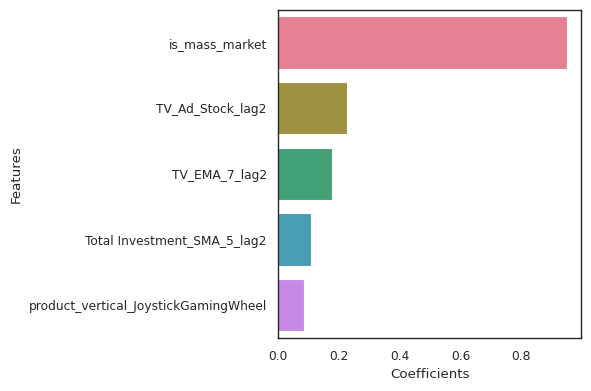

In [450]:
# Slightly alter the figure size to make it more horizontal.
plt.figure( dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.barplot(y='Features', x='Coefficients', palette='husl', data=gamingaccessory_lr_coef_df, estimator=np.sum)
# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

### **Simple Linear Regression for HomeAudio**

In [451]:
homeaudio_dlmul_model = LinearRegression().fit(homeaudio_dlmul_df_X_train, homeaudio_dlmul_df_y_train)

homeaudio_dlmul_rfe = RFECV(homeaudio_dlmul_model, cv=5,scoring='neg_mean_squared_error')             # running RFE
homeaudio_dlmul_rfe = homeaudio_dlmul_rfe.fit(homeaudio_dlmul_df_X_train, homeaudio_dlmul_df_y_train)

In [452]:
homeaudio_dlmul_rfe.n_features_

2

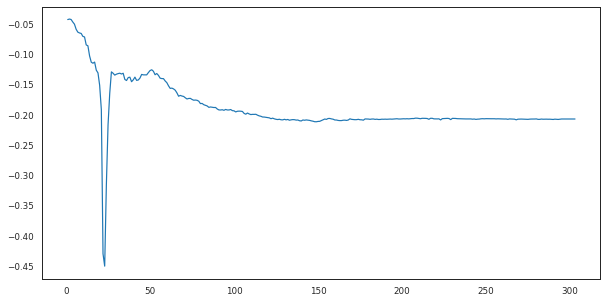

In [453]:
plt.figure(figsize=[10, 5])
plt.plot(range(1, homeaudio_dlmul_df_X_train.shape[1]+1), homeaudio_dlmul_rfe.grid_scores_)
plt.show();

In [454]:
homeaudio_dlmul_model = LinearRegression().fit(homeaudio_dlmul_df_X_train, homeaudio_dlmul_df_y_train)

homeaudio_dlmul_rfe = RFE(homeaudio_dlmul_model, 5)             # running RFE
homeaudio_dlmul_rfe = homeaudio_dlmul_rfe.fit(homeaudio_dlmul_df_X_train, homeaudio_dlmul_df_y_train)

col = list(homeaudio_dlmul_df_X_train.columns[homeaudio_dlmul_rfe.support_])

homeaudio_dlmul_model = LinearRegression().fit(homeaudio_dlmul_df_X_train[col], homeaudio_dlmul_df_y_train)

homeaudio_dlmul_df_y_test_pred = homeaudio_dlmul_model.predict(homeaudio_dlmul_df_X_test[col])

print('R2 Score: {}'.format(r2_score(homeaudio_dlmul_df_y_test, homeaudio_dlmul_df_y_test_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(homeaudio_dlmul_df_y_test, homeaudio_dlmul_df_y_test_pred)))

R2 Score: 0.9810044830845164
Mean Squared Error: 0.5648514904854671


#### **Simple Linear Regression for Homeaudio with K-Fold Cross validation**

In [455]:
homeaudio_dlmul_df_cv = homeaudio_dlmul_df.copy()

**Feature Scaling**

In [456]:
scaler = StandardScaler()
homeaudio_dlmul_df_cv[homeaudio_dlmul_df_cv.columns]=scaler.fit_transform(homeaudio_dlmul_df_cv[homeaudio_dlmul_df_cv.columns])

In [457]:
homeaudio_dlmul_df_cv_X = homeaudio_dlmul_df_cv.drop("gmv",axis=1)
homeaudio_dlmul_df_cv_y = homeaudio_dlmul_df_cv.gmv

**Model Building**

In [458]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn import metrics

homeaudio_dlmul_model_cv = LinearRegression().fit(homeaudio_dlmul_df_cv_X[col], homeaudio_dlmul_df_cv_y)

homeaudio_dlmul_predictions_cv = cross_val_predict(homeaudio_dlmul_model_cv, homeaudio_dlmul_df_cv_X[col], homeaudio_dlmul_df_cv_y, cv=5)
accuracy = metrics.r2_score(homeaudio_dlmul_df_cv_y, homeaudio_dlmul_predictions_cv)
print("Cross-Predicted Accuracy:", accuracy)
print('Mean Squared Error: {}'.format(mean_squared_error(homeaudio_dlmul_df_cv_y, homeaudio_dlmul_predictions_cv)))

Cross-Predicted Accuracy: 0.9792310369492266
Mean Squared Error: 0.020768963050773324


#### **Determining Feature Importance for homeaudio from model without cv**

In [459]:
# linear regression model parameters
#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 
pd.set_option('display.precision',1)

homeaudio_dlmul_model = LinearRegression().fit(homeaudio_dlmul_df_X_train[col], homeaudio_dlmul_df_y_train)
homeaudio_lr_model_parameters = list(homeaudio_dlmul_model.coef_)
#cameraaccessory_lr_model_parameters.insert(0, cameraaccessory_model.intercept_)
homeaudio_lr_model_parameters = [abs(round(x, 3)) for x in homeaudio_lr_model_parameters]
homeaudio_lr_coef = list(zip(col, homeaudio_lr_model_parameters))
homeaudio_lr_coef

[('is_mass_market', 0.494),
 ('product_vertical_FMRadio', 0.275),
 ('product_vertical_HomeAudioSpeaker', 1.272),
 ('Digital_EMA_7_lag1', 0.084),
 ('Digital_EMA_7_lag3', 0.109)]

In [460]:
homeaudio_lr_coef_df = pd.DataFrame(homeaudio_lr_coef)
col_rename = {0:'Features',1: 'Coefficients'}
homeaudio_lr_coef_df = homeaudio_lr_coef_df.rename(columns=col_rename)
homeaudio_lr_coef_df = homeaudio_lr_coef_df.loc[homeaudio_lr_coef_df['Coefficients']!=0.0]
homeaudio_lr_coef_df = homeaudio_lr_coef_df.sort_values(by=['Coefficients'], ascending = False)
homeaudio_lr_coef_df

,Features,Coefficients
2,product_vertical_HomeAudioSpeaker,1.272
0,is_mass_market,0.494
1,product_vertical_FMRadio,0.275
4,Digital_EMA_7_lag3,0.109
3,Digital_EMA_7_lag1,0.084


#### **Plotting the Features in descending order of Importance for homeaudio**

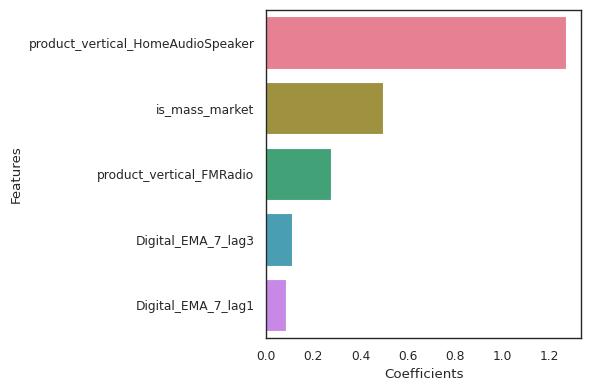

In [461]:
# Slightly alter the figure size to make it more horizontal.
plt.figure( dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.barplot(y='Features', x='Coefficients', palette='husl', data=homeaudio_lr_coef_df, estimator=np.sum)
# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

# **Model Dashboard**

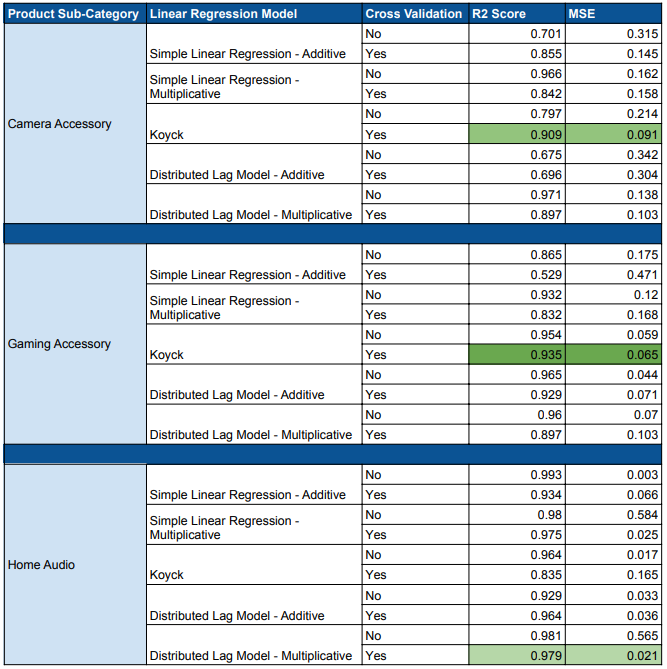

# **Model Selection**

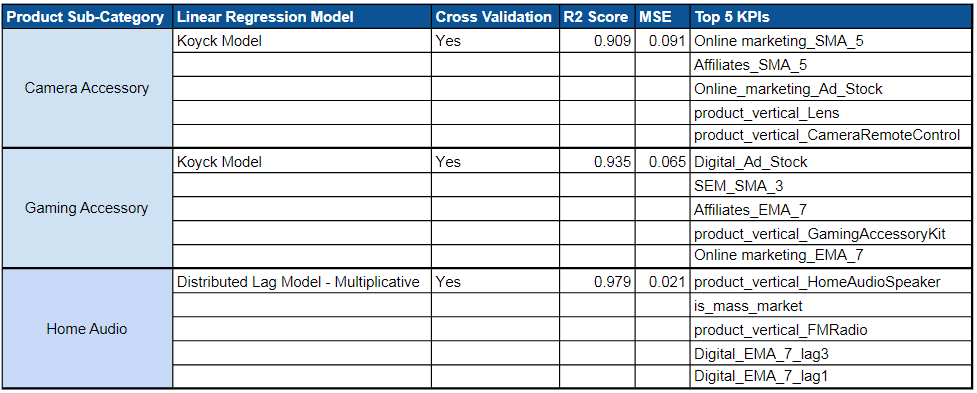

# **Recommendations**

General
- Most of the sales take place when Discount% is between 50-60%. However, that does not necessarily help in boosting the revenue. EDA shows that an average discount% between 10-20% is the most profitable for the company specially among luxury items.

Camera Accessory
- Company should promote Lens, Binoculars, and Camera Batteries as they fetch the highest revenue.
- Advertisement spends on Online Marketing and Affiliates marketing has a positive impact on revenue. So this type of marketing should be encouraged. (Referred from Koyck Model)
- Mass-market products are better contributors to the increased revenue in comparison to the Luxury products.

Gaming Accessory
- Company should promote GamePad, Gaming Headset, and Gaming Mouse  as they fetch the highest revenue.
- Digital marketing and Search Engine marketing have more impact on revenue. So this type of marketing should be encouraged. (Referred from Koyck Model)
- Mass-market products are better contributors to the increased revenue in comparison to the Luxury products.


Home Audio
- Company should promote Home Audio Speakers, FM Radios, and Voice Recorder as they fetch the highest revenue.
- Online marketing has a positive impact on revenue. (Referred from Koyck Model)
- In this sub-category, the highest revenue is generated in the discount range of 50-60%
- Mass-market products are better contributors to the increased revenue in comparison to the Luxury products.
- For Home Audio, customers prefer to pay before they receive the products